- knn con vecinos cercanos considerando pickup and dropoff data
- knn con el respecto al día de la semana (finde o no)
    -- hacer esto con todos los datos temporales (lunes a viernes y sábado y domingo) 
- distancia ==> sklearn.metrics.pairwise
    -- manhattan, euclidean, canberra, minkowski, cosine (Jere va a leer porque sí)
- es sólo de la ciudad de Nueva York
- no usar dummies ==> mejor usar seno o coseno de la fecha CHECK
- buscar librería para importar feriados y considerar como día de fin de semana CHECK
    -- (from pandas.tseries.holiday import USFederalHolidayCalendar) -- usamos "holidays" DOBLE CHECK
- si nos falta el dato objetivo está bien eliminar la fila del dataset CHECK
- semana del año CHECK (charlar)
- hay desde el 2009 maso. LA INFLACIÓN?!

# Contexto

#### Contexto  
El proyecto trata sobre **Uber Inc.**, la compañía de taxis más grande del mundo. En este trabajo, nuestro objetivo es **predecir la tarifa de futuros viajes**.  

Uber brinda servicio a millones de clientes cada día, por lo que gestionar adecuadamente sus datos es clave para desarrollar nuevas estrategias de negocio y obtener mejores resultados.  

### Variables del conjunto de datos  

**Variables explicativas:**  
- **key**: identificador único de cada viaje.  
- **pickup_datetime**: fecha y hora en que se inició el viaje.  
- **passenger_count**: cantidad de pasajeros en el vehículo (dato ingresado por el conductor).  
- **pickup_longitude**: longitud del punto de inicio del viaje.  
- **pickup_latitude**: latitud del punto de inicio del viaje.  
- **dropoff_longitude**: longitud del punto de destino.  
- **dropoff_latitude**: latitud del punto de destino.  

**Variable objetivo (target):**  
- **fare_amount**: costo del viaje en dólares.  

# Librerías

In [3]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
import random
import math

import plotly.express as px
import plotly.graph_objects as go
import plotly.figure_factory as ff

import holidays

from sklearn.impute import KNNImputer
from geopy.distance import geodesic
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler   # u otros scalers
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet, LassoCV, RidgeCV, ElasticNetCV
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split

# Carga de datos




In [4]:
### carga datos de dataset en dataframe
file_path= 'uber_fares.csv'

df = pd.read_csv(file_path)

In [5]:
df.head()

,key,date,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,24238194,2015-05-07 19:52:06.0000003,7.5,2015-05-07 19:52:06 UTC,-73.999817,40.738354,-73.999512,40.723217,1
1,27835199,2009-07-17 20:04:56.0000002,7.7,2009-07-17 20:04:56 UTC,-73.994355,40.728225,-73.994710,40.750325,1
2,44984355,2009-08-24 21:45:00.00000061,12.9,2009-08-24 21:45:00 UTC,-74.005043,40.740770,-73.962565,40.772647,1
3,25894730,2009-06-26 08:22:21.0000001,5.3,2009-06-26 08:22:21 UTC,-73.976124,40.790844,-73.965316,40.803349,3
4,17610152,2014-08-28 17:47:00.000000188,16.0,2014-08-28 17:47:00 UTC,-73.925023,40.744085,-73.973082,40.761247,5


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200000 entries, 0 to 199999
Data columns (total 9 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   key                200000 non-null  int64  
 1   date               200000 non-null  object 
 2   fare_amount        200000 non-null  float64
 3   pickup_datetime    200000 non-null  object 
 4   pickup_longitude   200000 non-null  float64
 5   pickup_latitude    200000 non-null  float64
 6   dropoff_longitude  199999 non-null  float64
 7   dropoff_latitude   199999 non-null  float64
 8   passenger_count    200000 non-null  int64  
dtypes: float64(5), int64(2), object(2)
memory usage: 13.7+ MB


# Análisis descriptivo

## Análisis exploratorio

In [4]:
# Dropeo filas donde el valor del viaje es nulo o negativo

df = df[df["fare_amount"].notna()]               # remove NaN / None
df = df[df["fare_amount"].astype(float) > 0]

df.head()

,key,date,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,24238194,2015-05-07 19:52:06.0000003,7.5,2015-05-07 19:52:06 UTC,-73.999817,40.738354,-73.999512,40.723217,1
1,27835199,2009-07-17 20:04:56.0000002,7.7,2009-07-17 20:04:56 UTC,-73.994355,40.728225,-73.994710,40.750325,1
2,44984355,2009-08-24 21:45:00.00000061,12.9,2009-08-24 21:45:00 UTC,-74.005043,40.740770,-73.962565,40.772647,1
3,25894730,2009-06-26 08:22:21.0000001,5.3,2009-06-26 08:22:21 UTC,-73.976124,40.790844,-73.965316,40.803349,3
4,17610152,2014-08-28 17:47:00.000000188,16.0,2014-08-28 17:47:00 UTC,-73.925023,40.744085,-73.973082,40.761247,5


In [7]:
# separo timestampm en date y time
df["dateTime"] = pd.to_datetime(df["pickup_datetime"]) # sin errors, ya que checkeamos que no hay valores nulos

df["dateTime"] = df["dateTime"].dt.tz_convert("America/New_York") # Esto cubre el horario de verano

df["time"] = df["dateTime"].dt.time
df["date"] = df["dateTime"].dt.date

print(df)


             key        date  fare_amount          pickup_datetime  \
0       24238194  2015-05-07          7.5  2015-05-07 19:52:06 UTC   
1       27835199  2009-07-17          7.7  2009-07-17 20:04:56 UTC   
2       44984355  2009-08-24         12.9  2009-08-24 21:45:00 UTC   
3       25894730  2009-06-26          5.3  2009-06-26 08:22:21 UTC   
4       17610152  2014-08-28         16.0  2014-08-28 17:47:00 UTC   
...          ...         ...          ...                      ...   
199995  42598914  2012-10-28          3.0  2012-10-28 10:49:00 UTC   
199996  16382965  2014-03-13          7.5  2014-03-14 01:09:00 UTC   
199997  27804658  2009-06-28         30.9  2009-06-29 00:42:00 UTC   
199998  20259894  2015-05-20         14.5  2015-05-20 14:56:25 UTC   
199999  11951496  2010-05-15         14.1  2010-05-15 04:08:00 UTC   

        pickup_longitude  pickup_latitude  dropoff_longitude  \
0             -73.999817        40.738354         -73.999512   
1             -73.994355       

In [29]:
print(df["dateTime"].dt.hour)

0         15
1         16
2         17
3          4
4         13
          ..
199995     6
199996    21
199997    20
199998    10
199999     0
Name: dateTime, Length: 199978, dtype: int32


In [11]:
df["date"] = pd.to_datetime(df["date"])
df["weekday_num"] = df["date"].dt.dayofweek + 1



In [18]:
print(df["weekday_num"])

k = (2*math.pi)/7

df["sen_weekday_num"] = np.sin(k*df["weekday_num"])
df["cos_weekday_num"] = np.cos(k*df["weekday_num"])

print(df)

0         4
1         5
2         1
3         5
4         4
         ..
199995    7
199996    4
199997    7
199998    3
199999    6
Name: weekday_num, Length: 199978, dtype: int32
             key       date  fare_amount          pickup_datetime  \
0       24238194 2015-05-07          7.5  2015-05-07 19:52:06 UTC   
1       27835199 2009-07-17          7.7  2009-07-17 20:04:56 UTC   
2       44984355 2009-08-24         12.9  2009-08-24 21:45:00 UTC   
3       25894730 2009-06-26          5.3  2009-06-26 08:22:21 UTC   
4       17610152 2014-08-28         16.0  2014-08-28 17:47:00 UTC   
...          ...        ...          ...                      ...   
199995  42598914 2012-10-28          3.0  2012-10-28 10:49:00 UTC   
199996  16382965 2014-03-13          7.5  2014-03-14 01:09:00 UTC   
199997  27804658 2009-06-28         30.9  2009-06-29 00:42:00 UTC   
199998  20259894 2015-05-20         14.5  2015-05-20 14:56:25 UTC   
199999  11951496 2010-05-15         14.1  2010-05-15 04:08:00

In [22]:

us_holidays = holidays.US(state="NY")

df["weekend_or_holiday"] = ((df["weekday_num"] >= 6) | (df["date"].dt.date.isin(us_holidays))).astype(int)


In [30]:
# 1 a 7 ==> madrugada ==> V = 1  ==> CODIFICACIÓN BINARIA ==> 0 | 0
# 7 a 11 ==> mañana ==> V = 2 ==> CODIFICACIÓN BINARIA ==> 0 | 1
# 11 a 19 ==> tarde ==> V = 3 ==> CODIFICACIÓN BINARIA ==> 1 | 1
# 19 a 1 ==> noche ==> V = 4 ==> CODIFICACIÓN BINARIA ==> 1 | 0

df["time"] = df["dateTime"].dt.hour

df["bin_time_1"] = 0
df["bin_time_2"] = 0

# apply your rules
df.loc[(df["time"] >= 7) & (df["time"] < 11), ["bin_time_1", "bin_time_2"]] = [0, 1]
df.loc[(df["time"] >= 11) & (df["time"] < 19), ["bin_time_1", "bin_time_2"]] = [1, 1]
df.loc[(df["time"] >= 19) | (df["time"] < 1), ["bin_time_1", "bin_time_2"]] = [1, 0]

In [32]:
df["week"] = df["date"].dt.isocalendar().week

df["sen_week_num"] = np.sin(k*df["week"])
df["cos_week_num"] = np.cos(k*df["week"])

In [ ]:
df.loc[(df['passenger_count'] < 0), 'passenger_count'] = 1
df.loc[(df['passenger_count'] > 6), 'passenger_count'] = 6


In [24]:
### Columnas, ¿cuáles son variables numéricas y cuales variables categóricas?
df.columns

Index(['key', 'date', 'fare_amount', 'pickup_datetime', 'pickup_longitude',
       'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude',
       'passenger_count', 'dateTime', 'time', 'weekday_num', 'sen_weekday_num',
       'cos_weekday_num', 'weekend_or_holiday', 'bin_time_1', 'bin_time_2'],
      dtype='object')

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200000 entries, 0 to 199999
Data columns (total 9 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   key                200000 non-null  int64  
 1   date               200000 non-null  object 
 2   fare_amount        200000 non-null  float64
 3   pickup_datetime    200000 non-null  object 
 4   pickup_longitude   200000 non-null  float64
 5   pickup_latitude    200000 non-null  float64
 6   dropoff_longitude  199999 non-null  float64
 7   dropoff_latitude   199999 non-null  float64
 8   passenger_count    200000 non-null  int64  
dtypes: float64(5), int64(2), object(2)
memory usage: 13.7+ MB


In [8]:
# Valores nulos

df.isna().sum()

,0
key,0
date,0
fare_amount,0
pickup_datetime,0
pickup_longitude,0
pickup_latitude,0
dropoff_longitude,1
dropoff_latitude,1
passenger_count,0


In [9]:
# Estadísticas descriptivas

print(df.describe(include='all'))

                 key                         date    fare_amount  \
count   2.000000e+05                       200000  200000.000000   
unique           NaN                       200000            NaN   
top              NaN  2009-08-29 02:36:56.0000003            NaN   
freq             NaN                            1            NaN   
mean    2.771250e+07                          NaN      11.359955   
std     1.601382e+07                          NaN       9.901776   
min     1.000000e+00                          NaN     -52.000000   
25%     1.382535e+07                          NaN       6.000000   
50%     2.774550e+07                          NaN       8.500000   
75%     4.155530e+07                          NaN      12.500000   
max     5.542357e+07                          NaN     499.000000   

                pickup_datetime  pickup_longitude  pickup_latitude  \
count                    200000     200000.000000    200000.000000   
unique                   196629            

In [10]:
# Cantidad de filas que contienen valor 0.000 en latitud y o longitud

zero_lat_long_count = len(df[(df['pickup_latitude'] == 0.000) | (df['pickup_longitude'] == 0.000) | (df['dropoff_latitude'] == 0.000) | (df['dropoff_longitude'] == 0.000)])

print(f"Cantidad de filas que contienen valor 0.000 en latitud y o longitud: {zero_lat_long_count}")


Cantidad de filas que contienen valor 0.000 en latitud y o longitud: 3968


In [11]:
# Eliminamos las filas del dataframe que contienen valores negativos en la variable target 'fare_amount'

def eliminar_precios_negativos(df):
  '''
  Elimina las filas del dataframe que contienen valores negativos en la variable
  target 'fare_amount' y devuelve el dataframe modificado
  '''
  df = df[df['fare_amount'] > 0]
  return df

In [12]:
df = eliminar_precios_negativos(df)

## Validación cruzada train - test


In [13]:
X_train, X_test, y_train, y_test = train_test_split(df.drop(columns='fare_amount'), df['fare_amount'], test_size=0.2, random_state=random.seed(0))

In [14]:
X_train.describe()

,key,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
count,1.599820e+05,159982.000000,159982.000000,159981.000000,159981.000000,159982.000000
mean,2.771668e+07,-72.507718,39.926873,-72.505261,39.917405,1.683708
std,1.602138e+07,10.879885,7.013139,10.990453,6.641630,1.404167
min,1.000000e+00,-768.550000,-74.015515,-737.916665,-881.985513,0.000000
25%,1.381372e+07,-73.992081,40.734765,-73.991428,40.733738,1.000000
50%,2.777412e+07,-73.981832,40.752566,-73.980118,40.753010,1.000000
75%,4.155797e+07,-73.967207,40.767182,-73.963623,40.768035,2.000000
max,5.542357e+07,57.418457,1292.016128,1153.572603,493.533332,208.000000


## Datos atípicos y faltantes

Valores atipicos o mal inputados
*   Para limitar las longitudes y latitudes dentro de los Estados Unidos, se pueden usar los rangos geográficos aproximados que corresponden a las fronteras del país. Los valores aproximados son: Latitudes: Desde 24.396308° N (en la frontera sur, en la Florida) hasta 49.384358° N (en la frontera norte, cerca de la línea entre EE. UU. y Canadá). Longitudes: Desde -125.0° W (en la costa oeste, en California) hasta -66.93457° W (en la costa este, en Maine).
*   un auto no puede llevar 208 pasajeros (el maximo es 6, en los uber XL)









In [15]:
# Imputamos por la moda de la columna 'passenger_count' las celdas que continen valores negativos o mayores que 6

def impute_passengers (df):
  '''
  Imputa las celdas que continen valores negativos o mayores que 6 en la columna
  'passenger_count' con la moda de la columna y devuelve el dataframe modificado
  '''
  passenger_mode = df['passenger_count'].mode()[0]
  df.loc[(df['passenger_count'] < 0) | (df['passenger_count'] > 6), 'passenger_count'] = passenger_mode
  return df

In [16]:
#  Imputamos por KNN las coordenadas inválidas

def impute_coordinates_train_test(X_train, X_test):
    """
    Imputa las coordenadas faltantes o inválidas por separado para train y test usando KNN.
    """
    # Columnas a imputar
    cols_to_impute = ['pickup_longitude', 'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude']

    # Crear copias para evitar modificar los originales
    X_train_imputed = X_train.copy()
    X_test_imputed = X_test.copy()

    # Marcar coordenadas inválidas como NaN
    for col in cols_to_impute:
        if 'longitude' in col:
            X_train_imputed.loc[(X_train_imputed[col] < -125.0) | (X_train_imputed[col] > -66.93457) | (X_train_imputed[col] == 0) | (X_train_imputed[col].isna()), col] = np.nan
            X_test_imputed.loc[(X_test_imputed[col] <  -125.0) | (X_test_imputed[col] > -66.93457) | (X_test_imputed[col] == 0) | (X_test_imputed[col].isna()), col] = np.nan
        elif 'latitude' in col:
            X_train_imputed.loc[(X_train_imputed[col] < 24.396308) | (X_train_imputed[col] >  49.384358) | (X_train_imputed[col] == 0) | (X_train_imputed[col].isna()), col] = np.nan
            X_test_imputed.loc[(X_test_imputed[col] < 24.396308) | (X_test_imputed[col] >  49.384358) | (X_test_imputed[col] == 0) | (X_test_imputed[col].isna()), col] = np.nan

    # Entrenar el imputador en el conjunto de entrenamiento
    imputer = KNNImputer(n_neighbors=10)
    imputer.fit(X_train_imputed[cols_to_impute])

    # Aplicar el imputador en ambos conjuntos (entrenamiento y prueba)
    X_train_imputed[cols_to_impute] = imputer.transform(X_train_imputed[cols_to_impute])
    X_test_imputed[cols_to_impute] = imputer.transform(X_test_imputed[cols_to_impute])

    return X_train_imputed, X_test_imputed

'''# Llamar a la función para imputar los conjuntos ESTO LO SACAMOS?
X_train_imputed, X_test_imputed = impute_coordinates_train_test(X_train, X_test)'''


'# Llamar a la función para imputar los conjuntos ESTO LO SACAMOS?\nX_train_imputed, X_test_imputed = impute_coordinates_train_test(X_train, X_test)'

In [17]:
# Llamamos a las funciones anteriores

X_train = impute_passengers(X_train)
X_test = impute_passengers(X_test)
X_train, X_test = impute_coordinates_train_test(X_train, X_test)

In [18]:
X_train.info()
X_test.info()

<class 'pandas.core.frame.DataFrame'>
Index: 159982 entries, 183960 to 121969
Data columns (total 8 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   key                159982 non-null  int64  
 1   date               159982 non-null  object 
 2   pickup_datetime    159982 non-null  object 
 3   pickup_longitude   159982 non-null  float64
 4   pickup_latitude    159982 non-null  float64
 5   dropoff_longitude  159982 non-null  float64
 6   dropoff_latitude   159982 non-null  float64
 7   passenger_count    159982 non-null  int64  
dtypes: float64(4), int64(2), object(2)
memory usage: 11.0+ MB
<class 'pandas.core.frame.DataFrame'>
Index: 39996 entries, 123358 to 124642
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   key                39996 non-null  int64  
 1   date               39996 non-null  object 
 2   pickup_datetime    39996 non-nu

In [19]:
print(X_train.describe(include='all'))
print(X_test.describe(include='all'))

                 key                         date          pickup_datetime  \
count   1.599820e+05                       159982                   159982   
unique           NaN                       159982                   157859   
top              NaN  2009-03-12 09:10:21.0000006  2014-04-13 18:19:00 UTC   
freq             NaN                            1                        4   
mean    2.771668e+07                          NaN                      NaN   
std     1.602138e+07                          NaN                      NaN   
min     1.000000e+00                          NaN                      NaN   
25%     1.381372e+07                          NaN                      NaN   
50%     2.777412e+07                          NaN                      NaN   
75%     4.155797e+07                          NaN                      NaN   
max     5.542357e+07                          NaN                      NaN   

        pickup_longitude  pickup_latitude  dropoff_longitude  \

## Creamos nuevas columnas

In [20]:
# Drop 'date' en ambos conjuntos
X_train = X_train.drop('date', axis=1)
X_test = X_test.drop('date', axis=1)

# Convertimos 'pickup_datetime' a objetos datetime en ambos conjuntos
X_train['pickup_datetime'] = pd.to_datetime(X_train['pickup_datetime'])
X_test['pickup_datetime'] = pd.to_datetime(X_test['pickup_datetime'])

# Creamos columnas separadas 'date' y 'time' en ambos conjuntos
X_train['pickup_date'] = X_train['pickup_datetime'].dt.date
X_train['pickup_time'] = X_train['pickup_datetime'].dt.time

X_test['pickup_date'] = X_test['pickup_datetime'].dt.date
X_test['pickup_time'] = X_test['pickup_datetime'].dt.time

# Dropeamos la columna 'pickup_datetime' porque ya no es necesaria en ambos conjuntos
X_train = X_train.drop('pickup_datetime', axis=1)
X_test = X_test.drop('pickup_datetime', axis=1)

In [21]:
# A partir de los datos de latitud y longitud creamos nueva columna con la distancia

X_train['distance_km'] = X_train.apply(
    lambda row: abs(geodesic(
        (row['pickup_latitude'], row['pickup_longitude']),
        (row['dropoff_latitude'], row['dropoff_longitude'])
    ).kilometers),
    axis=1
)
X_test['distance_km'] = X_test.apply(
    lambda row: abs(geodesic(
        (row['pickup_latitude'], row['pickup_longitude']),
        (row['dropoff_latitude'], row['dropoff_longitude'])
    ).kilometers),
    axis=1
)

In [22]:
# Calcula la mediana de la distancia para el grupo de entrenamiento donde la distancia es mayor que 0
median_distance = X_train[X_train['distance_km'] > 0]['distance_km'].median()

# Imputa las distancias de 0 en el grupo de entrenamiento con la mediana calculada
X_train.loc[X_train['distance_km'] == 0, 'distance_km'] = median_distance

# Imputa las distancias de 0 en el grupo de prueba con la mediana calculada
X_test.loc[X_test['distance_km'] == 0, 'distance_km'] = median_distance

## Codificación de variables categóricas

In [23]:
import holidays

# Define feriados de US
us_holidays = holidays.US()

def categorize_time(time):
  hour = time.hour
  if 5 <= hour < 12:
    return 'Morning'
  elif 12 <= hour < 18:
    return 'Afternoon'
  else:
    return 'Night'

def is_holiday_or_weekend(date):
    if date in us_holidays:
        return 'Holiday'
    elif date.weekday() >= 5:  # 5 y 6 representan Saturday y Sunday
        return 'Weekend'
    else:
        return 'Weekday'

# Aplicar funciones para crear nuevas columnas
X_train['day_category'] = X_train['pickup_date'].apply(is_holiday_or_weekend)
X_train['time_category'] = X_train['pickup_time'].apply(categorize_time)
X_test['day_category'] = X_test['pickup_date'].apply(is_holiday_or_weekend)
X_test['time_category'] = X_test['pickup_time'].apply(categorize_time)

X_train.drop(columns=['pickup_date','pickup_time'], inplace=True)
X_test.drop(columns=['pickup_date','pickup_time'], inplace=True)

In [24]:
print(X_train.describe(include='all'))
print(X_test.describe(include='all'))
X_train
X_test

                 key  pickup_longitude  pickup_latitude  dropoff_longitude  \
count   1.599820e+05     159982.000000    159982.000000      159982.000000   
unique           NaN               NaN              NaN                NaN   
top              NaN               NaN              NaN                NaN   
freq             NaN               NaN              NaN                NaN   
mean    2.771668e+07        -73.975324        40.750988         -73.974155   
std     1.602138e+07          0.080125         0.047785           0.043907   
min     1.000000e+00        -93.824668        32.005119         -75.458979   
25%     1.381372e+07        -73.992087        40.736803         -73.991431   
50%     2.777412e+07        -73.981848        40.752598         -73.980138   
75%     4.155797e+07        -73.968742        40.767194         -73.965897   
max     5.542357e+07        -67.370360        48.018760         -69.046738   

        dropoff_latitude  passenger_count    distance_km day_ca

,key,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,distance_km,day_category,time_category
123358,40428375,-73.986038,40.730762,-73.962192,40.800078,3,7.956456,Weekend,Night
50057,39371632,-73.994013,40.724697,-73.994923,40.762680,1,4.218673,Weekday,Night
167361,19467956,-73.961207,40.769098,-73.955095,40.767475,5,0.546600,Weekday,Night
88074,27382228,-73.956558,40.780788,-73.969658,40.761471,2,2.413515,Weekday,Morning
105143,14729674,-73.990570,40.756420,-73.943352,40.729980,1,4.952335,Weekday,Morning
...,...,...,...,...,...,...,...,...,...
80097,52430938,-73.973810,40.747487,-73.862085,40.767287,1,9.687221,Weekday,Afternoon
38123,46062504,-74.008488,40.732907,-73.972445,40.642000,1,10.544779,Weekend,Night
89114,36991857,-74.009783,40.711915,-74.013765,40.702392,5,1.109760,Holiday,Morning
182117,21397500,-74.003147,40.727767,-73.997797,40.735952,1,1.015092,Weekday,Night


## Visualizacion de datos

### Boxplots

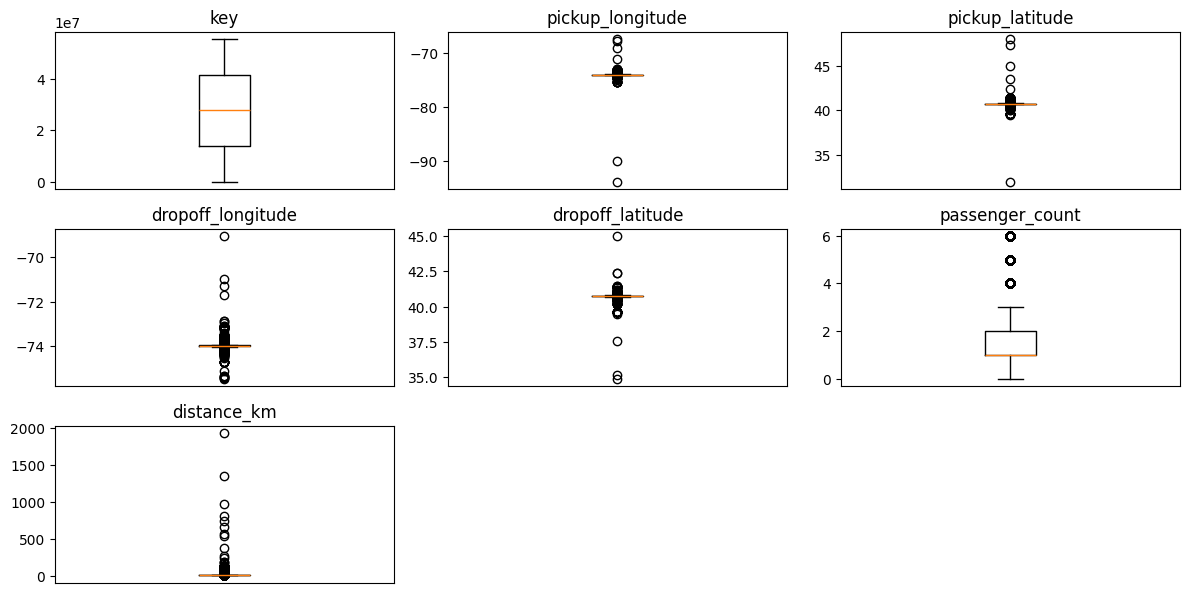

In [25]:
# Crear diagrama de caja para cada columna
numeric_columns = X_train.select_dtypes(include=[np.number]).columns

# Crear los diagramas de caja solo para columnas numéricas
plt.figure(figsize=(12, 8))
for i, column in enumerate(numeric_columns):
    plt.subplot(4, 3, i + 1)  # 4 filas, 3 columnas
    plt.boxplot(X_train[column].dropna())  # Excluir valores NaN
    plt.title(column)
    plt.xticks([])  # Eliminar marcas en el eje x

plt.tight_layout()
plt.show()


### Distribucion de precios


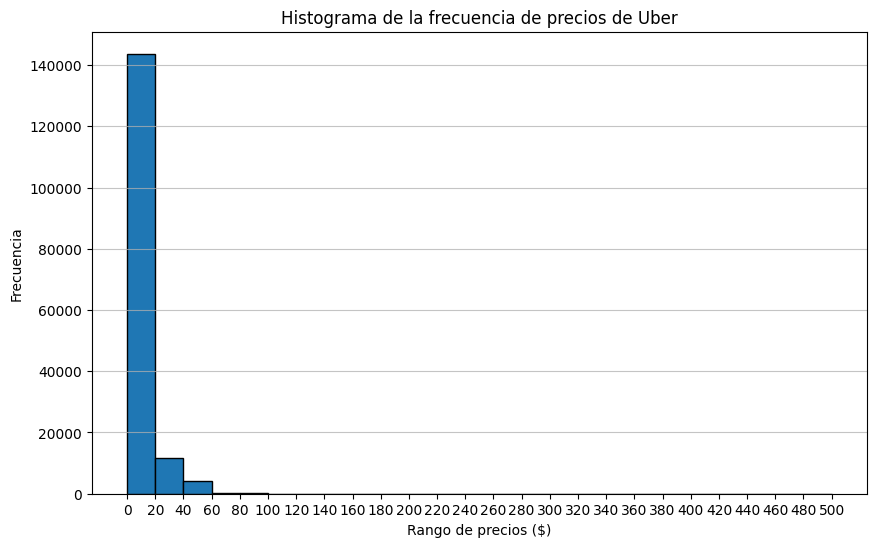

In [26]:
# Crea los rangos de precios
min_price = y_train.min()
max_price = y_train.max()
bins = np.arange(min_price, max_price + 20, 20)  # Rangos de 20 en 20

# Crea el histograma
plt.figure(figsize=(10, 6))
plt.hist(y_train, bins=bins, edgecolor='black')
plt.xlabel('Rango de precios ($)')
plt.ylabel('Frecuencia')
plt.title('Histograma de la frecuencia de precios de Uber')
plt.xticks(bins)  # Muestra todas las marcas en el eje x
plt.grid(axis='y', alpha=0.75)
plt.show()


## Matriz de correlación

                   fare_amount  pickup_longitude  pickup_latitude  \
fare_amount           1.000000          0.172993        -0.112117   
pickup_longitude      0.172993          1.000000        -0.034551   
pickup_latitude      -0.112117         -0.034551         1.000000   
dropoff_longitude     0.230723          0.265978         0.109533   
dropoff_latitude     -0.112627          0.268556         0.281797   
passenger_count       0.010929         -0.001350        -0.003238   
distance_km           0.349909         -0.406532         0.041043   

                   dropoff_longitude  dropoff_latitude  passenger_count  \
fare_amount                 0.230723         -0.112627         0.010929   
pickup_longitude            0.265978          0.268556        -0.001350   
pickup_latitude             0.109533          0.281797        -0.003238   
dropoff_longitude           1.000000          0.188870        -0.003033   
dropoff_latitude            0.188870          1.000000        -0.003504 

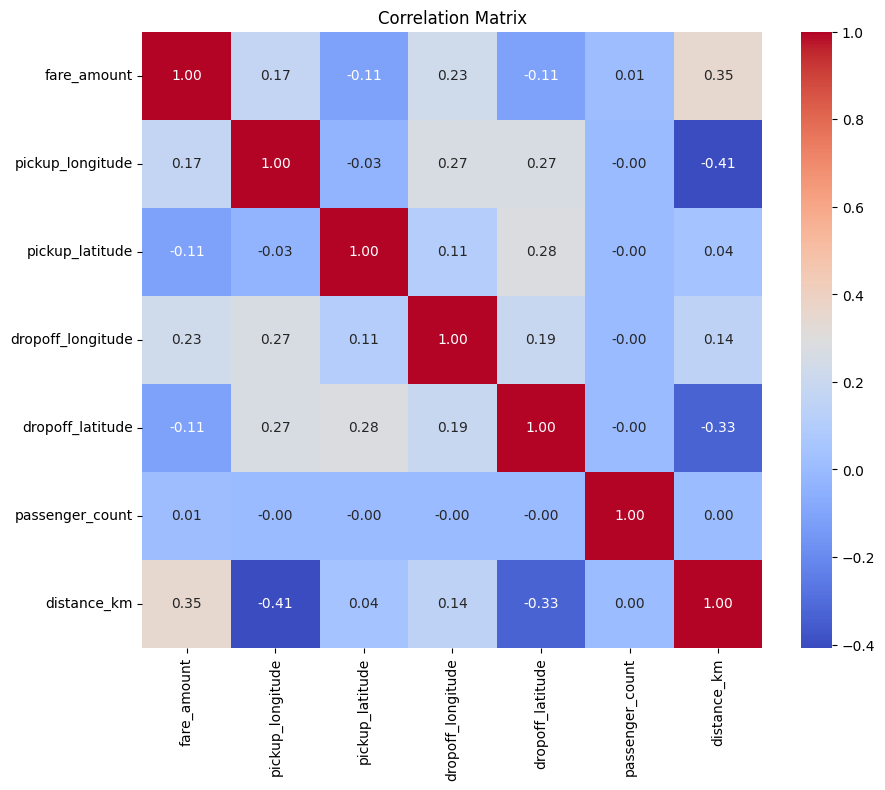

In [27]:
# Concatena X_train con y_train
train_data = pd.concat([X_train, y_train], axis=1)

# Calcula la matriz de correlación
correlation_matrix = train_data[['fare_amount', 'pickup_longitude', 'pickup_latitude',
                                 'dropoff_longitude', 'dropoff_latitude',
                                 'passenger_count', 'distance_km']].corr()

# Muestra la matriz de correlación
print(correlation_matrix)

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix')
plt.show()

## Estandarización o escalado de datos

In [28]:
# Store dropped columns
dropped_columns_train = X_train[['key','day_category','time_category']]
dropped_columns_test = X_test[['key','day_category','time_category']]

# Drop columns for scaling
X_train_to_scale = X_train.drop(columns=['key','day_category','time_category'])
X_test_to_scale = X_test.drop(columns=['key','day_category','time_category'])

# Scale the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_to_scale)
X_test_scaled = scaler.transform(X_test_to_scale)

# Convert scaled data back to DataFrames
X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train_to_scale.columns, index=X_train_to_scale.index)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test_to_scale.columns, index=X_test_to_scale.index)

# Concatenate scaled data with dropped columns
X_train = pd.concat([X_train_scaled, dropped_columns_train], axis=1)
X_test = pd.concat([X_test_scaled, dropped_columns_test], axis=1)

In [29]:
# Convertimos day_category en un binario (1 for weekend, 0 para el resto de los dias)
X_train['weekend'] = (X_train['day_category'] == 'Weekend').astype(int)
X_train.drop(columns=['day_category'], inplace=True)

X_test['weekend'] = (X_test['day_category'] == 'Weekend').astype(int)
X_test.drop(columns=['day_category'], inplace=True)

In [30]:
# Crear variables dummy para 'time_category' con solo dos columnas
time_category_dummies = pd.get_dummies(X_train['time_category'], drop_first=True, prefix='time')
X_train = pd.concat([X_train.drop('time_category', axis=1), time_category_dummies], axis=1)

time_category_dummies = pd.get_dummies(X_test['time_category'], drop_first=True, prefix='time')
X_test = pd.concat([X_test.drop('time_category', axis=1), time_category_dummies], axis=1)

# Regresión lineal múltiple

## Método LinearRegression

Mean Squared Error: 57.90907137470185
R-squared: 0.40026654196008193


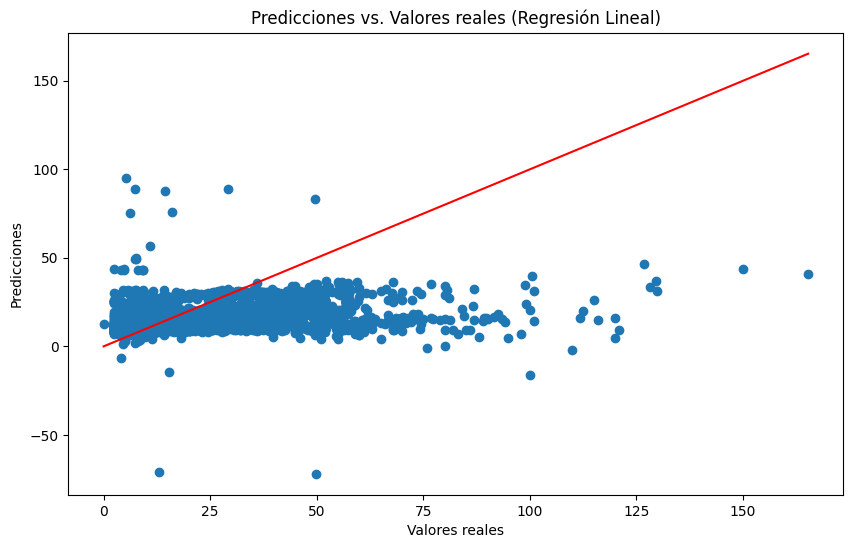

In [ ]:
# Regresión lineal múltiple con LinearRegression
model = LinearRegression()
model.fit(X_train, y_train)

# Realiza predicciones en el conjunto de prueba
y_pred = model.predict(X_test)

# Evalúa el modelo
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error: {mse}")
print(f"R-squared: {r2}")

# Visualiza las predicciones vs. los valores reales
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred)
plt.xlabel("Valores reales")
plt.ylabel("Predicciones")
plt.title("Predicciones vs. Valores reales (Regresión Lineal)")
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='-') # Línea de referencia
plt.show()

## Métodos de gradiente descendiente

### Gradiente descendiente

In [31]:
def gradient_descent(X, y, learning_rate=0.01, n_iterations=100):

    n_samples, n_features = X.shape
    # Inicializa coeficientes en 0.0001 en lugar de 0 para evitar problemas con valores de 0 en los predictores
    coefficients = np.ones(n_features) * 0.0001

    for _ in range(n_iterations):
        # Calcula las predicciones
        predictions = np.dot(X, coefficients)

        # Calcula los errores
        errors = predictions - y

        # Calcula el gradiente
        gradient = (2 / n_samples) * np.dot(X.T, errors)

        # Actualiza los coeficientes
        coefficients = coefficients - learning_rate * gradient

    return coefficients

# Example usage (assuming you have X_train and y_train from your previous code)

# Ensure X_train is a NumPy array
X_train_np = np.array(X_train)
y_train_np = np.array(y_train)

# Add a bias term to X_train
X_train_b = np.c_[np.ones(X_train_np.shape[0]), X_train_np]

# Perform gradient descent
optimal_coefficients = gradient_descent(X_train_b, y_train_np)

print("Optimal Coefficients:", optimal_coefficients)

# Make predictions on the test set
X_test_np = np.array(X_test)
X_test_b = np.c_[np.ones(X_test_np.shape[0]), X_test_np]
y_pred_gd = np.dot(X_test_b, optimal_coefficients)

# Evaluate the model
mse_gd = mean_squared_error(y_test, y_pred_gd)
r2_gd = r2_score(y_test, y_pred_gd)

print(f"Gradient Descent - Mean Squared Error: {mse_gd}")
print(f"Gradient Descent - R-squared: {r2_gd}")

<ipython-input-31-a736cb13a2d6>:18: RuntimeWarning: invalid value encountered in subtract
  coefficients = coefficients - learning_rate * gradient


Optimal Coefficients: [nan nan nan nan nan nan nan nan nan nan nan]


ValueError: Input contains NaN.

### Gradiente descendiente estocástico

In [ ]:
def stochastic_gradient_descent(X, y, learning_rate=0.01, n_iterations=1000, batch_size=32):
    """
    Performs stochastic gradient descent to find the optimal coefficients for a linear regression model.

    Args:
        X: A NumPy array of shape (n_samples, n_features) representing the features.
        y: A NumPy array of shape (n_samples,) representing the target variable.
        learning_rate: The learning rate for gradient descent.
        n_iterations: The number of iterations to perform.
        batch_size: The size of the mini-batches.

    Returns:
        A NumPy array of shape (n_features,) representing the optimal coefficients.
    """

    n_samples, n_features = X.shape
    coefficients = np.zeros(n_features)

    for _ in range(n_iterations):
        # Shuffle the data
        indices = np.random.permutation(n_samples)
        X_shuffled = X[indices]
        y_shuffled = y[indices]

        for i in range(0, n_samples, batch_size):
            X_batch = X_shuffled[i:i + batch_size]
            y_batch = y_shuffled[i:i + batch_size]

            predictions = np.dot(X_batch, coefficients)
            errors = predictions - y_batch
            gradient = (2 / len(X_batch)) * np.dot(X_batch.T, errors)
            coefficients = coefficients - learning_rate * gradient

    return coefficients

# Example usage (assuming X_train_b and y_train_np from previous code)
optimal_coefficients_sgd = stochastic_gradient_descent(X_train_b, y_train_np)

print("Optimal Coefficients (SGD):", optimal_coefficients_sgd)

# Make predictions on the test set
y_pred_sgd = np.dot(X_test_b, optimal_coefficients_sgd)

# Evaluate the model
mse_sgd = mean_squared_error(y_test, y_pred_sgd)
r2_sgd = r2_score(y_test, y_pred_sgd)

print(f"Stochastic Gradient Descent - Mean Squared Error: {mse_sgd}")
print(f"Stochastic Gradient Descent - R-squared: {r2_sgd}")


<ipython-input-63-ab66d8a1b47d>:32: RuntimeWarning: invalid value encountered in subtract
  coefficients = coefficients - learning_rate * gradient


Optimal Coefficients (SGD): [nan nan nan nan nan nan nan nan nan nan nan]


ValueError: Input contains NaN.

eeeeeeeeeeeeeeeeeee por aca no va

In [32]:
def stochastic_gradient_descent(X_train, y_train, X_test, y_test, lr=0.01, epochs=100):

    n = X_train.shape[0]
    m = X_train.shape[1]

    X_train = np.hstack((np.ones((n, 1)), X_train))
    X_test = np.hstack((np.ones((X_test.shape[0], 1)), X_test))

    W = np.random.randn(m + 1).reshape(-1, 1)

    train_errors = []
    test_errors = []

    for i in range(epochs):
        # Permutación aleatoria de los datos
        permutation = np.random.permutation(n)
        X_train = X_train[permutation]
        y_train = y_train[permutation]

        for j in range(n):
            # Obtener una muestra aleatoria de un solo dato para hacer SGD
            x_sample = X_train[j]
            y_sample = y_train[j][0]

            prediction = np.matmul(x_sample, W)
            error = y_sample - prediction
            train_mse = error ** 2
            train_errors.append(train_mse)

            prediction_test = np.matmul(X_test, W)
            error_test = y_test - prediction_test
            test_mse = np.mean(error_test ** 2)
            test_errors.append(test_mse)

            gradient = -2 * error * x_sample.T.reshape(-1, 1)

            W = W - (lr * gradient)



    plt.figure(figsize=(12, 6))
    plt.plot(train_errors, label='Error de entrenamiento')
    plt.plot(test_errors, label='Error de prueba')
    plt.xlabel('Iteración')
    plt.ylabel('Error cuadrático medio')
    plt.legend()
    plt.title('Error de entrenamiento vs iteraciones (SGD)')
    plt.show()

    return W

In [33]:
stochastic_gradient_descent(X_train, y_train, X_test, y_test, lr=1, epochs=20)

KeyError: '[154212, 27146, 73037, 151537, 105341, 20855, 13375, 2105, 52734, 133117, 33581, 103613, 48028, 6517, 76787, 5106, 110915, 2633, 52884, 28503, 150394, 63114, 24358, 33094, 79406, 107416, 98331, 90796, 145008, 152883, 128965, 67338, 86920, 69415, 71549, 47228, 92649, 72323, 126559, 107496, 45129, 36726, 123411, 110884, 104849, 158782, 139744, 68987, 15291, 73550, 71208, 124538, 106602, 41906, 114414, 73321, 1581, 145602, 73361, 38240, 40180, 76088, 58639, 73339, 1423, 50645, 148113, 66140, 18719, 75808, 76013, 81939, 89576, 133847, 82636, 106920, 144708, 120374, 3087, 6273, 31622, 19820, 156318, 106284, 47750, 121841, 157482, 21368, 49123, 22520, 140847, 105915, 77791, 83975, 67421, 122023, 39516, 14366, 76817, 27560, 109689, 139479, 71458, 103778, 53941, 102936, 87807, 149318, 144242, 85606, 10338, 10448, 144196, 39743, 152489, 51486, 79491, 43366, 144094, 58817, 84406, 144032, 104688, 79648, 69995, 12819, 37680, 81383, 72708, 29708, 159550, 136860, 40412, 71286, 95224, 34306, 128552, 68739, 145574, 142880, 7284, 52101, 154206, 107209, 104677, 86584, 155081, 33918, 117180, 82252, 104563, 104700, 29998, 53289, 52567, 17238, 55634, 50201, 33161, 42726, 147831, 2392, 100513, 18677, 145529, 128665, 114948, 139644, 55725, 109690, 46584, 92060, 138518, 66190, 129876, 71423, 137193, 2679, 18280, 12964, 31905, 104265, 6002, 34132, 86749, 81043, 26848, 27334, 155564, 17007, 35859, 61914, 85455, 157704, 35491, 10398, 59641, 18486, 17113, 149617, 152047, 55139, 3786, 114991, 117255, 106052, 52895, 82879, 52147, 42735, 53169, 91554, 150426, 30304, 90627, 83116, 75387, 83327, 58770, 68437, 157954, 143063, 122191, 147582, 8396, 149142, 33205, 99294, 154461, 65156, 45568, 23887, 57594, 153585, 140668, 154701, 125390, 39157, 34440, 43819, 124554, 88929, 32744, 76168, 47071, 64247, 56101, 115678, 119384, 130900, 32975, 62730, 97059, 152505, 151075, 119926, 20006, 90715, 109095, 131623, 47791, 143046, 47455, 111696, 61211, 143179, 118598, 139857, 153920, 39990, 52761, 56980, 5087, 137162, 63158, 15902, 148435, 51154, 99538, 47456, 34408, 154869, 36259, 41410, 159302, 55345, 42151, 31066, 109018, 143978, 66155, 9490, 83481, 15669, 90583, 130412, 37186, 75837, 90368, 117990, 101198, 32329, 87362, 57114, 136528, 128331, 80443, 52164, 76297, 93866, 116999, 1415, 18389, 117226, 13694, 47253, 60854, 14448, 78090, 23375, 106925, 57369, 22310, 142034, 112833, 40842, 29790, 96174, 115376, 98191, 108257, 33376, 8931, 54405, 105467, 7047, 88654, 141073, 151548, 28787, 29563, 663, 34226, 39838, 151672, 141271, 105991, 74638, 120615, 76666, 52844, 103768, 52842, 30018, 82694, 119817, 99903, 114481, 43770, 59208, 140063, 145923, 135003, 157347, 75625, 63825, 15482, 93861, 4174, 1802, 82894, 70947, 112171, 27220, 145687, 115338, 130009, 55530, 118671, 44887, 50088, 71643, 110772, 79646, 64686, 58551, 65355, 8809, 96829, 17840, 104397, 152062, 22363, 1197, 12509, 135287, 123392, 153767, 100573, 115819, 126972, 133115, 135038, 5002, 87669, 121819, 54689, 64576, 153907, 29308, 69010, 93147, 65401, 23751, 116627, 120089, 88437, 105701, 87906, 108165, 78906, 131241, 35327, 153243, 111967, 73526, 40339, 119550, 112985, 85772, 12075, 132024, 120132, 86422, 141079, 121539, 6536, 85152, 67458, 124945, 83240, 15602, 150517, 108868, 159871, 142087, 32095, 106688, 48999, 1721, 18116, 33776, 6454, 52172, 60863, 23741, 76636, 151593, 70390, 1170, 55623, 1582, 36006, 22097, 135773, 142146, 92085, 27802, 4869, 43448, 26261, 64696, 127177, 29658, 50981, 120352, 90325, 129480, 979, 128253, 53154, 80448, 133600, 45155, 118058, 112060, 79838, 92128, 62044, 46809, 64571, 10723, 3935, 90444, 85457, 145254, 139070, 44670, 29893, 92921, 30118, 74242, 92830, 60883, 107566, 106873, 57661, 119685, 67602, 152364, 123186, 120253, 33646, 64828, 120710, 103682, 10288, 138263, 121685, 125727, 35156, 84460, 128916, 51579, 110033, 115499, 23872, 81877, 21121, 35136, 71320, 121826, 38079, 10118, 11193, 2785, 71354, 89588, 130438, 30689, 88234, 87736, 12554, 139478, 15980, 68867, 43114, 27735, 72646, 61503, 77094, 45784, 111486, 159343, 133108, 60615, 74317, 110545, 19550, 55912, 110197, 14385, 155990, 149869, 76245, 138651, 104977, 124730, 109581, 114591, 90234, 142078, 33111, 81075, 104083, 104886, 137709, 65096, 119608, 98931, 141123, 46044, 64439, 143190, 83213, 22004, 43020, 47816, 118021, 154044, 57857, 116903, 108176, 7623, 54404, 109226, 5799, 65447, 150857, 81888, 123891, 1487, 63605, 40457, 60937, 79342, 145120, 141527, 38114, 89502, 126630, 83009, 154555, 145510, 106713, 60344, 78768, 46957, 70929, 52990, 74489, 146881, 63660, 4221, 36695, 127314, 91209, 79199, 3800, 139339, 87563, 127486, 137858, 53719, 138482, 20346, 99521, 60227, 2040, 74660, 150596, 120837, 1970, 149757, 65720, 29983, 103649, 134142, 122303, 122577, 16592, 130235, 39724, 133655, 18084, 36417, 55037, 89529, 26115, 51445, 45433, 143842, 13845, 117454, 7538, 91256, 20796, 34352, 13126, 157100, 91182, 60814, 7362, 64286, 104863, 43813, 118370, 24472, 145073, 133736, 58044, 93022, 34607, 158991, 9901, 117847, 110481, 42087, 122146, 144358, 139890, 114689, 108330, 44210, 3891, 75649, 112621, 110847, 32772, 43612, 73104, 89063, 5069, 31444, 7348, 93906, 37093, 95575, 116021, 63029, 112742, 156757, 113091, 115983, 59578, 86156, 53547, 119806, 140820, 57403, 43919, 14114, 46114, 34125, 101188, 149196, 68918, 22989, 60182, 116736, 110833, 69958, 11518, 75558, 74528, 38269, 16140, 11439, 59288, 14826, 133776, 44956, 40349, 13249, 130350, 46303, 132249, 102880, 107661, 17477, 56447, 100346, 67730, 34357, 26237, 153037, 140488, 124034, 147705, 20267, 39577, 155993, 148267, 79070, 102956, 10975, 128628, 133272, 68502, 506, 25369, 70073, 106198, 98509, 134061, 107567, 10659, 131180, 7962, 1384, 41188, 55590, 49094, 90150, 126162, 61489, 45981, 40239, 157160, 51637, 24334, 704, 117653, 93243, 128573, 80984, 74305, 45257, 76942, 128639, 33564, 156120, 113028, 96999, 112415, 49062, 44475, 95644, 158226, 89912, 95333, 123188, 17496, 80338, 119865, 154675, 115817, 31514, 153283, 159052, 79987, 133747, 50876, 26042, 107410, 93510, 158013, 13066, 17088, 105551, 41243, 74580, 130927, 28599, 130686, 62736, 145718, 57197, 135096, 38118, 63543, 3724, 37906, 158068, 38838, 1313, 107700, 157449, 27419, 114555, 138783, 63862, 52913, 148729, 130172, 100726, 108184, 149253, 103828, 100247, 44770, 80372, 32717, 57713, 98598, 89067, 107995, 152219, 16530, 147950, 24149, 21218, 20218, 44841, 151969, 120526, 63647, 152071, 135540, 100603, 108855, 142758, 67482, 11139, 81085, 4144, 10085, 52569, 22313, 128714, 24525, 82473, 66624, 130365, 80303, 86715, 143571, 153383, 113438, 51406, 143332, 131271, 155703, 63490, 103305, 113436, 93175, 147303, 149287, 113432, 51817, 110467, 135592, 74479, 116565, 106260, 110064, 127257, 139533, 42037, 80058, 31614, 4380, 2113, 4335, 29205, 10805, 93418, 60862, 149996, 103967, 130445, 146368, 115449, 89319, 69011, 50822, 63272, 156262, 149384, 65802, 113161, 58582, 21497, 126535, 133859, 152026, 60509, 33725, 121377, 140786, 37509, 79114, 7001, 35965, 150434, 113285, 26170, 61181, 153157, 158731, 117225, 85182, 156435, 63558, 136578, 64599, 43769, 31464, 8222, 265, 2782, 80980, 55665, 85709, 146197, 43525, 17923, 13835, 108607, 39495, 3560, 3787, 62154, 87463, 83133, 157251, 71927, 105943, 71021, 60499, 157044, 138004, 155068, 115018, 15827, 68310, 137589, 16028, 99264, 145146, 30442, 43574, 124389, 38395, 64532, 24475, 78429, 85017, 93662, 58349, 55897, 123890, 12142, 145540, 99733, 152390, 151954, 112838, 46205, 4339, 5706, 117451, 13577, 85611, 138021, 123573, 9140, 67811, 132032, 132268, 5317, 74575, 18120, 28312, 27744, 51610, 79979, 73593, 156451, 98484, 122687, 144760, 69271, 14887, 126197, 55669, 111733, 43280, 88727, 147182, 28767, 122765, 57347, 4734, 23752, 155538, 124885, 156840, 33345, 88688, 149489, 47451, 55908, 89730, 9832, 88032, 8627, 128581, 12979, 39094, 4032, 93559, 35159, 71212, 100734, 77860, 133111, 109748, 105846, 80240, 153143, 52740, 6705, 63168, 48581, 27263, 51617, 6025, 54, 24003, 40932, 121168, 64548, 144743, 77709, 113953, 28274, 44561, 20980, 12283, 28937, 136060, 110851, 131647, 91591, 150189, 131910, 37631, 30830, 87871, 43582, 104080, 73617, 28954, 71373, 87714, 77806, 101170, 45573, 71942, 38452, 110777, 40652, 8270, 125830, 135663, 25035, 38113, 106125, 109358, 95361, 64830, 10882, 91655, 31319, 134569, 78691, 35357, 147510, 21661, 39042, 5752, 150571, 5758, 61344, 8756, 110791, 94326, 88855, 53764, 49820, 50949, 5857, 9635, 144428, 136407, 98214, 2865, 104206, 32238, 71519, 131966, 27806, 36888, 96166, 58612, 61469, 42710, 83100, 22019, 33478, 40001, 140573, 158458, 120214, 18701, 152061, 31868, 101443, 36761, 97681, 65100, 62946, 26646, 82092, 97937, 136000, 122597, 116669, 89485, 54579, 133740, 45868, 52943, 117055, 11063, 101914, 73312, 3913, 133560, 21693, 105288, 141094, 123206, 104679, 139351, 145563, 137313, 133293, 76158, 98411, 78712, 9786, 148006, 44903, 90961, 4039, 43289, 148921, 66690, 88231, 131371, 139858, 99563, 150408, 29365, 159602, 96408, 35097, 119319, 117020, 76803, 103015, 38196, 56384, 84144, 71059, 20019, 146316, 141830, 51707, 100842, 72701, 8559, 80900, 10766, 156211, 65117, 57521, 127475, 4105, 56010, 4691, 66639, 103319, 153068, 31645, 147062, 109147, 114392, 69362, 71934, 75370, 113168, 464, 114082, 140168, 22442, 22343, 90589, 85586, 95262, 87998, 36149, 106618, 48067, 85615, 8748, 96540, 3548, 60318, 59403, 97124, 77338, 127239, 14777, 57819, 28376, 13379, 50640, 25866, 83056, 103180, 140869, 70762, 28651, 152336, 29498, 62849, 75964, 130535, 53945, 90799, 87396, 156641, 158537, 67289, 95471, 92545, 124633, 101338, 43723, 151084, 62820, 117153, 89285, 54752, 77633, 132381, 154450, 121120, 148187, 8906, 111591, 120219, 137367, 139300, 67525, 139466, 94204, 3175, 70619, 135498, 59287, 158602, 117718, 7070, 17642, 128133, 45235, 107185, 87245, 78505, 39478, 264, 51482, 31634, 145483, 38836, 133651, 48372, 23134, 100231, 123279, 13817, 77593, 59223, 35797, 6380, 108465, 64016, 6330, 85399, 123709, 8581, 139714, 75684, 22897, 100871, 84872, 135871, 6019, 134331, 73947, 79111, 128657, 28193, 27417, 142335, 37135, 137360, 122104, 85593, 12154, 54048, 95697, 81698, 99364, 93682, 106359, 134009, 119216, 9833, 37976, 124394, 80964, 42882, 146995, 55619, 130561, 133166, 39251, 87511, 70007, 99802, 91329, 65076, 94816, 21419, 86031, 127338, 105388, 43210, 108806, 106309, 39845, 25623, 85480, 29067, 143184, 10645, 16341, 96599, 143943, 86890, 121197, 58936, 150148, 78854, 3553, 48132, 130094, 19520, 157897, 40021, 2783, 45225, 123363, 142817, 108645, 81487, 96779, 76350, 24387, 36404, 16048, 134246, 37332, 144319, 93464, 83057, 133777, 6673, 4979, 148510, 27436, 79926, 61626, 80947, 76108, 88262, 81277, 25860, 157946, 152706, 9159, 138087, 79938, 37912, 67314, 45510, 15544, 86784, 13542, 89546, 66014, 72348, 138247, 10507, 135863, 15069, 89375, 56809, 66626, 155066, 89402, 81364, 105088, 16998, 1081, 86846, 97537, 42226, 50070, 124955, 149619, 101606, 2736, 93292, 13519, 108186, 69823, 84606, 114195, 62479, 105972, 106406, 100921, 99923, 135628, 14687, 57218, 25504, 19964, 79084, 120120, 138191, 117734, 156653, 85851, 79420, 143276, 63352, 11194, 18381, 76258, 143725, 40899, 115688, 43632, 19375, 27699, 78239, 58651, 92463, 72770, 33842, 135467, 81906, 110973, 18824, 8189, 152842, 73778, 41592, 24758, 127927, 92515, 47964, 29670, 65680, 145093, 120885, 150660, 159519, 51056, 140637, 81038, 72687, 151793, 142459, 15705, 100456, 4313, 3173, 5082, 63718, 93373, 98553, 54565, 10891, 92100, 30782, 104175, 25280, 49467, 7577, 25584, 16232, 137404, 81100, 83944, 140959, 22018, 112386, 126654, 153085, 119264, 112294, 134756, 29191, 20423, 96897, 111193, 152166, 79247, 89270, 82729, 152711, 108229, 147681, 78927, 97318, 115421, 157361, 102235, 16633, 109211, 25969, 7844, 109034, 72175, 6029, 13009, 36311, 142526, 40715, 8862, 92092, 90958, 35398, 125435, 18475, 148641, 64152, 23327, 26520, 126026, 130248, 60581, 98155, 84392, 84242, 51338, 154863, 67187, 115025, 3426, 43767, 139654, 22254, 21356, 72203, 52153, 46339, 89908, 8693, 59377, 141493, 107770, 16700, 85243, 149795, 20740, 101473, 43063, 120574, 106199, 159908, 32033, 120504, 157836, 118095, 147358, 53006, 105465, 100892, 88047, 64313, 105680, 15580, 140670, 76369, 65102, 39440, 30391, 20728, 98520, 144501, 140784, 27341, 38251, 153060, 30856, 29768, 140371, 42460, 98932, 9330, 43502, 151957, 32157, 79291, 99886, 82875, 13677, 76011, 153098, 29902, 61919, 87976, 74880, 110518, 79001, 5794, 140819, 70695, 154867, 33310, 123721, 33933, 44068, 28354, 38857, 49687, 72734, 109090, 137902, 68406, 16670, 64097, 82781, 136132, 65328, 90724, 54921, 124812, 139706, 58630, 17488, 138434, 44, 35714, 77315, 20812, 73986, 69441, 11958, 63253, 154767, 112822, 30372, 141337, 34941, 74483, 5180, 81049, 40707, 41340, 50798, 25206, 126392, 145445, 56395, 141244, 72359, 158053, 146586, 70804, 10298, 31769, 114342, 76285, 133745, 64028, 36963, 11417, 149571, 74574, 82170, 29228, 38851, 130327, 155888, 16018, 76963, 31950, 64426, 55282, 111502, 21675, 36401, 154585, 33949, 135989, 82596, 132777, 73591, 147296, 585, 100720, 45357, 117739, 158506, 157848, 126695, 149269, 115707, 111977, 97642, 156706, 72475, 84976, 152480, 143560, 114123, 151489, 91652, 48777, 141939, 89943, 110134, 2960, 73167, 57384, 59261, 59298, 27235, 134712, 137652, 137806, 93511, 56377, 77440, 119696, 7060, 95930, 131115, 120724, 117234, 126346, 154257, 123164, 134930, 71346, 149351, 107407, 117789, 87595, 100961, 69869, 133492, 10039, 125575, 55729, 72990, 34322, 115390, 7117, 133675, 111283, 38863, 80378, 19527, 115286, 2220, 35228, 103808, 149422, 151506, 49449, 35194, 51836, 10815, 118430, 82310, 131442, 55827, 114229, 2660, 64859, 1053, 150092, 10326, 108404, 107835, 12982, 49629, 8258, 127298, 159212, 60891, 1648, 110298, 135150, 35831, 36366, 96033, 145196, 75772, 106590, 40262, 101940, 17055, 136509, 18492, 129225, 121109, 5813, 83126, 81933, 149930, 69851, 91117, 86937, 145613, 33406, 113822, 3016, 148901, 143651, 5198, 567, 77782, 140293, 76416, 118012, 105637, 74530, 89408, 155094, 55705, 133759, 154352, 104581, 131100, 143215, 118913, 150485, 99087, 69743, 96649, 95306, 93678, 29021, 11167, 155825, 109141, 964, 13551, 3975, 105490, 35102, 17355, 4890, 60740, 92184, 89229, 70890, 27763, 29066, 79117, 47164, 50401, 102161, 147460, 45447, 62528, 116382, 52779, 44268, 37305, 24009, 63087, 2563, 38566, 22149, 64961, 30132, 34398, 157368, 6912, 57083, 131771, 4874, 149851, 121548, 19257, 135946, 12347, 87716, 48712, 43714, 19356, 35800, 103575, 67727, 53512, 75312, 27451, 129387, 133739, 159639, 57391, 38849, 103325, 105536, 83908, 108812, 59247, 49626, 72879, 148296, 14533, 33434, 151527, 64894, 128895, 115943, 112092, 71224, 74388, 70244, 81196, 17443, 138567, 9558, 77533, 142314, 17166, 30440, 70302, 3063, 64500, 71607, 110048, 88146, 153532, 117513, 7746, 89075, 149963, 29281, 17240, 113463, 87249, 20803, 70130, 126352, 108524, 66560, 78260, 92131, 10977, 106314, 94213, 92579, 64245, 122962, 142686, 88280, 45070, 52836, 58870, 20145, 17468, 7777, 3686, 97561, 138058, 76849, 144676, 103359, 20320, 114759, 93830, 133489, 129314, 64014, 11976, 73718, 12835, 122860, 71279, 86634, 10762, 63066, 132877, 45851, 48236, 67720, 118659, 112974, 82356, 88793, 65903, 155469, 52973, 12328, 89696, 95790, 29121, 3406, 58758, 126332, 39446, 88523, 148609, 73598, 64133, 78163, 105079, 34271, 108557, 142858, 126870, 122250, 47079, 9264, 60673, 47589, 50762, 31011, 152117, 90242, 36773, 27213, 107908, 143022, 85774, 6413, 102028, 110162, 3870, 52249, 119212, 110793, 80325, 63560, 103041, 98591, 57505, 145011, 89326, 107565, 132874, 38163, 40010, 53483, 129551, 132011, 131617, 133711, 119333, 64038, 5953, 140504, 73156, 94844, 68572, 133808, 107078, 138345, 34788, 64643, 8558, 153253, 97304, 66125, 6696, 77737, 57219, 138300, 109040, 38374, 115154, 22124, 140593, 21466, 40353, 6339, 54833, 86649, 108513, 100820, 130972, 82998, 145508, 115701, 75803, 42114, 106896, 17796, 82735, 99721, 44083, 151709, 70189, 143969, 124687, 43256, 48197, 4545, 59716, 98421, 115828, 92469, 56925, 150978, 19248, 4845, 120785, 102922, 97442, 151764, 11607, 36335, 9794, 68116, 32172, 112139, 134647, 10521, 63054, 58905, 71368, 79569, 6322, 118565, 78813, 137743, 23488, 50162, 87391, 121582, 66312, 38369, 11361, 8699, 15570, 34782, 87285, 84096, 147667, 58520, 127013, 124705, 73704, 146878, 71072, 45405, 123126, 123095, 139266, 119082, 112595, 92802, 141029, 79733, 28854, 149685, 141045, 40693, 103693, 121416, 127108, 112997, 18873, 109988, 98017, 94113, 133921, 120964, 36048, 76799, 117382, 8707, 44011, 38365, 57053, 5871, 127676, 112329, 17242, 37361, 24015, 108107, 151635, 37283, 83846, 131917, 126831, 93045, 99991, 47878, 140337, 154216, 2481, 23283, 51253, 147024, 158958, 72338, 132662, 131558, 84773, 81493, 93827, 7469, 54808, 7742, 72662, 124227, 100259, 59773, 159777, 54965, 46574, 91067, 68118, 123150, 51333, 30705, 29662, 52403, 111297, 104595, 35992, 95180, 93890, 70785, 16889, 129601, 99213, 153406, 15978, 18692, 29993, 157138, 138778, 106201, 21149, 129287, 158969, 120418, 127597, 55292, 154858, 157509, 154507, 88685, 70616, 119322, 157227, 57796, 141477, 48975, 1979, 28626, 151001, 89678, 19792, 90018, 100922, 57261, 98199, 20757, 80225, 24187, 75939, 23691, 52039, 3518, 25529, 108354, 46617, 69876, 98477, 2803, 24573, 148851, 61547, 152237, 65560, 159928, 48008, 46890, 30388, 126917, 62202, 138219, 82246, 145956, 44883, 107660, 136973, 25399, 83168, 70749, 152388, 153846, 17932, 8286, 124014, 17912, 35501, 2111, 138211, 1326, 65432, 38839, 47819, 113433, 127263, 101948, 145837, 59761, 122138, 16561, 136664, 97466, 54262, 25483, 55721, 44273, 119237, 100872, 92349, 53238, 58748, 108041, 88479, 159327, 21915, 116259, 19373, 155713, 49005, 18742, 35552, 145351, 64887, 104625, 140119, 118937, 84413, 89984, 132539, 1837, 104177, 125433, 17512, 25932, 68530, 10905, 46814, 35095, 147219, 103008, 103383, 51313, 113541, 105029, 69321, 14605, 58746, 74197, 11751, 131, 32596, 101653, 45920, 136109, 154451, 113709, 8342, 125952, 21785, 19850, 71863, 114708, 90727, 124326, 113916, 62532, 16930, 73861, 46403, 70025, 153663, 104754, 104912, 96357, 16593, 87020, 103631, 62250, 87748, 97771, 13874, 122186, 72613, 76280, 53063, 9813, 64035, 57907, 65330, 34474, 78500, 140280, 155403, 45562, 55686, 49545, 116473, 110087, 33358, 46300, 128528, 119263, 116510, 147922, 25277, 33977, 109491, 157015, 116684, 64608, 20578, 99990, 154135, 139833, 51513, 3807, 80484, 137477, 85075, 9631, 116301, 55836, 142823, 14305, 101749, 45077, 15053, 71957, 70320, 125483, 139463, 107273, 84891, 136097, 159098, 16526, 100037, 90320, 111242, 96810, 63726, 142354, 142488, 53083, 24517, 137668, 92164, 84497, 148506, 30522, 137185, 159270, 116956, 159764, 117415, 112527, 9199, 119401, 115989, 136882, 85785, 144327, 26767, 66654, 47396, 81128, 31522, 92295, 43391, 87031, 53931, 89631, 67490, 35782, 84080, 115343, 137167, 50682, 138731, 36015, 4277, 80613, 148900, 26611, 5010, 39431, 103913, 21922, 39012, 10884, 90877, 93765, 139774, 124476, 111056, 132853, 143256, 11283, 134909, 16885, 83007, 122105, 53184, 26927, 37269, 24928, 43091, 11505, 137178, 134844, 137645, 58309, 132566, 33665, 95996, 149572, 127918, 92000, 63688, 84995, 39733, 81728, 85724, 125129, 44519, 13630, 89114, 13939, 29160, 83708, 109084, 140467, 85262, 103775, 112291, 131122, 85360, 110506, 34791, 111145, 92440, 139012, 67976, 92536, 151830, 65742, 41936, 73409, 147619, 86528, 98138, 148599, 62692, 62264, 28773, 65972, 52150, 120386, 119873, 38816, 32171, 122449, 951, 57968, 111422, 89805, 12951, 149917, 148531, 134107, 55828, 23652, 121376, 156171, 136484, 95794, 51965, 94791, 111319, 76067, 95767, 40294, 77492, 14881, 100182, 109785, 64545, 13836, 131402, 21085, 110323, 44556, 37492, 140181, 40442, 7351, 87670, 47655, 21064, 46774, 153342, 133690, 91396, 51782, 114529, 92968, 152010, 14692, 87696, 151104, 154139, 105824, 88830, 127991, 136892, 7786, 8566, 135176, 106959, 149737, 84596, 116325, 151492, 137934, 10898, 94899, 120948, 155267, 21164, 68582, 143700, 69488, 146825, 16916, 104194, 149497, 21901, 133175, 61783, 72700, 107994, 87950, 8191, 96302, 47996, 104010, 20658, 76273, 45127, 42055, 126033, 125704, 47860, 38070, 74703, 39749, 155310, 145608, 12917, 5845, 90353, 134701, 148853, 128324, 107624, 25362, 54180, 129370, 120794, 150308, 74699, 5254, 142390, 83508, 98357, 24932, 12787, 111672, 124636, 3109, 64377, 131333, 44653, 8641, 101646, 94575, 10140, 77746, 74257, 88864, 86697, 94374, 59778, 36363, 152245, 146241, 132211, 6136, 120523, 22163, 17281, 146899, 7260, 3799, 92862, 124279, 113600, 42809, 145814, 59867, 48479, 40737, 111310, 39518, 20822, 42837, 75476, 40135, 65278, 148675, 61579, 33822, 29903, 156462, 36751, 141813, 25255, 115546, 49765, 10365, 71993, 123551, 37236, 99674, 4019, 142655, 89533, 33722, 126122, 50634, 116218, 90211, 2570, 157370, 109461, 69246, 64218, 80665, 67006, 5551, 89976, 2483, 99595, 139670, 104774, 63457, 26527, 141402, 81783, 42657, 137322, 71055, 31488, 15361, 46944, 16523, 117040, 71831, 139380, 89561, 17436, 158982, 39011, 40391, 74972, 97939, 146776, 9467, 148293, 47806, 690, 130646, 67637, 82325, 159576, 62828, 70142, 68783, 109969, 131884, 27719, 93023, 48138, 153325, 101439, 137496, 117151, 34018, 76470, 75154, 156484, 123717, 113379, 138002, 61504, 138814, 83398, 53251, 56414, 152295, 307, 27578, 8740, 61177, 61514, 148398, 49663, 76357, 73470, 61934, 154308, 6763, 10444, 143154, 140282, 155230, 6315, 58486, 25643, 72823, 132383, 42164, 55608, 49540, 58523, 70629, 82439, 103379, 33404, 97416, 147540, 57019, 82254, 127855, 101861, 96957, 130649, 83923, 76861, 36544, 83939, 98875, 17613, 140473, 106082, 128733, 94016, 72665, 841, 122826, 120868, 121664, 91353, 139092, 79518, 6616, 32387, 48542, 119422, 114266, 69682, 44523, 121614, 72434, 109087, 151877, 109444, 50457, 29753, 130266, 117064, 5757, 92504, 108065, 34681, 155011, 48893, 53325, 31815, 18494, 4385, 105234, 6697, 144434, 140276, 53263, 93833, 91668, 120726, 14733, 145642, 122999, 43922, 142012, 96713, 91113, 9638, 35829, 44423, 121823, 99072, 153947, 24762, 113934, 47900, 102394, 88822, 97530, 80190, 136141, 95722, 18125, 9520, 14423, 119043, 62468, 142374, 148528, 70618, 82874, 128173, 103088, 70132, 132343, 158229, 30722, 85595, 13093, 151295, 3901, 7849, 143641, 7872, 22615, 97101, 81200, 3727, 101487, 128637, 98758, 134387, 111434, 48803, 150674, 58425, 49337, 136531, 57576, 596, 37922, 118666, 146563, 49640, 77224, 136193, 90180, 159806, 62454, 156134, 21386, 102267, 119208, 108897, 132911, 23881, 23675, 94197, 49531, 10413, 124071, 9915, 36853, 125155, 50210, 67684, 141681, 71386, 123737, 101483, 43262, 28370, 125241, 108843, 150976, 139685, 71216, 67798, 80791, 314, 152789, 25075, 21504, 136445, 147059, 132259, 158773, 131519, 47399, 156470, 47845, 142360, 96891, 103404, 27323, 89682, 33934, 10890, 122787, 139894, 105338, 27246, 100161, 13445, 103021, 113841, 73382, 131177, 12700, 9758, 145238, 95000, 111308, 113659, 79812, 124144, 154960, 104766, 126643, 123842, 1077, 157993, 112598, 69013, 108435, 32303, 52360, 117828, 74361, 88474, 108841, 29093, 39753, 21238, 5241, 124883, 57991, 141224, 49025, 146117, 98200, 54657, 130436, 114852, 147472, 89451, 71773, 129187, 134887, 153382, 149531, 15132, 106015, 59210, 18572, 113524, 18828, 66386, 16929, 149236, 148694, 115090, 105180, 57696, 108490, 55625, 72878, 58973, 48983, 63861, 76845, 87195, 91549, 50550, 124773, 137248, 72333, 91719, 112789, 159729, 156407, 25675, 38122, 13676, 20252, 78555, 25470, 120875, 156668, 19017, 142883, 48155, 34340, 84963, 89004, 92603, 133241, 117330, 20524, 52619, 103407, 114769, 27667, 25392, 93979, 155552, 132653, 57697, 121172, 65681, 128848, 137775, 4587, 18786, 36097, 114264, 91538, 52900, 66221, 45979, 107862, 114801, 57630, 130042, 1315, 138629, 44718, 92745, 106411, 110424, 25100, 67449, 71828, 16386, 11980, 92871, 81141, 74467, 91190, 95094, 14983, 54880, 14911, 46364, 146588, 23194, 119175, 81949, 123482, 132009, 43898, 134197, 117720, 122596, 84385, 155828, 63073, 135313, 29974, 98601, 110627, 149583, 65368, 30257, 87003, 126048, 113926, 148379, 59758, 42092, 133113, 101240, 31908, 138813, 20383, 89331, 18991, 148509, 72358, 41531, 46703, 142790, 68194, 40527, 29169, 43468, 73025, 45527, 29143, 121475, 144970, 87008, 104757, 23462, 104410, 78626, 51638, 156875, 104426, 130357, 98654, 13296, 78270, 50312, 3059, 142752, 51488, 96212, 80302, 99409, 134958, 158696, 32165, 80308, 66008, 141684, 22303, 84813, 157652, 138672, 37453, 99425, 85141, 70, 149730, 149937, 18430, 96091, 47161, 32453, 106429, 3688, 18097, 37826, 99443, 59154, 113093, 21203, 124649, 59790, 41438, 21177, 55545, 152911, 148583, 154815, 124263, 82734, 62922, 69084, 123576, 18407, 11906, 145479, 81096, 156060, 54738, 81931, 12494, 88039, 102502, 40743, 16866, 9502, 152815, 79051, 32849, 155045, 34110, 101570, 143287, 81951, 134634, 137068, 32401, 139780, 27785, 46674, 116400, 23486, 9655, 93798, 139241, 156919, 153956, 130675, 6393, 49592, 127133, 2357, 47351, 80097, 129572, 100135, 105, 53627, 50476, 81309, 52833, 15199, 95205, 36451, 65488, 135792, 129634, 2609, 84092, 125867, 149186, 152628, 120378, 75082, 153595, 79925, 136116, 24715, 22326, 1499, 65364, 133083, 128597, 79705, 92888, 32485, 95390, 101348, 82250, 79591, 129975, 61337, 29850, 63170, 68053, 80252, 94823, 89744, 144665, 102296, 108500, 90819, 73480, 122993, 109896, 24740, 98776, 69135, 101908, 49986, 26776, 69719, 13600, 127631, 154171, 7251, 79019, 68992, 35302, 122454, 36505, 71625, 92933, 21704, 2184, 58683, 119273, 118776, 151671, 129176, 126493, 50831, 97946, 95023, 62301, 39619, 67439, 55394, 121424, 69647, 81517, 85890, 101618, 4607, 33628, 54456, 133090, 156235, 138361, 12761, 37864, 25385, 114012, 151404, 117989, 79064, 81403, 150377, 9405, 98873, 55108, 67083, 154523, 93910, 82291, 147102, 91118, 29418, 137864, 83632, 101919, 79163, 49994, 117890, 154400, 134083, 86503, 128074, 96679, 37963, 79719, 109153, 26812, 12327, 39035, 30559, 11513, 78436, 136055, 86710, 21190, 71724, 122128, 133030, 85991, 103142, 36345, 54143, 27573, 56968, 3506, 119620, 133770, 104346, 119612, 40572, 6046, 6399, 136591, 15866, 24896, 132573, 75622, 140272, 84760, 130707, 155884, 16302, 140591, 70554, 92277, 53316, 69350, 1032, 117349, 136387, 64703, 43650, 156711, 145287, 115626, 20441, 91093, 41876, 141959, 134702, 37748, 14234, 87542, 90035, 140148, 18504, 18163, 135626, 105153, 12947, 63765, 10859, 124972, 139938, 130221, 91108, 106313, 139586, 8599, 59955, 24198, 149788, 114250, 10767, 91252, 57386, 83458, 155056, 122639, 142262, 143119, 24825, 30378, 99655, 156558, 58025, 82918, 153858, 120971, 67511, 68358, 15156, 151987, 14317, 32463, 11968, 63169, 130267, 41888, 22931, 23865, 50753, 11616, 146666, 111494, 89503, 22730, 85368, 35196, 153708, 130414, 69849, 110929, 89240, 112480, 1943, 120519, 85883, 156108, 92628, 93169, 146612, 100838, 62175, 47465, 44386, 34000, 114731, 6976, 88966, 118910, 89523, 63068, 96709, 49074, 105852, 120654, 106616, 90382, 9826, 114097, 93233, 17331, 154460, 21083, 36448, 66459, 22452, 90253, 81425, 157203, 107817, 95160, 141169, 140882, 90806, 8318, 59340, 72477, 35, 22733, 103732, 80803, 129678, 114644, 73894, 6525, 27023, 130868, 159168, 61890, 45888, 158309, 91153, 13821, 98409, 154373, 10064, 93158, 103437, 80191, 67466, 40042, 36730, 3207, 72226, 128448, 159808, 22463, 78870, 81858, 42089, 71515, 139038, 90534, 19670, 133420, 54453, 53190, 58996, 153579, 94072, 48625, 88043, 85404, 71463, 137575, 148036, 34697, 31374, 147113, 54755, 40460, 65064, 94736, 72791, 130169, 55240, 94888, 88564, 159033, 99800, 138776, 58388, 58250, 11180, 142140, 45930, 15663, 35427, 50658, 31643, 37522, 51595, 145915, 145211, 31891, 25750, 5731, 12223, 139065, 108671, 50148, 53778, 2449, 27333, 126027, 44300, 25112, 35047, 152562, 57578, 94283, 61347, 119252, 121991, 146439, 85308, 116251, 93368, 55106, 50643, 134433, 69856, 152544, 15865, 55561, 146292, 111025, 6744, 102143, 109659, 43368, 6098, 7384, 64743, 152922, 154346, 18329, 38698, 41277, 95315, 154330, 134703, 144847, 43225, 108376, 17346, 98388, 151608, 132380, 7221, 80194, 60860, 159568, 48710, 80142, 53425, 104203, 115073, 61892, 126782, 56075, 72658, 73643, 36236, 152839, 88111, 74312, 147215, 97583, 124182, 66887, 105023, 22565, 62587, 17094, 146553, 21886, 87702, 122410, 107343, 139763, 91232, 123360, 90464, 2955, 101728, 118977, 106461, 62853, 142767, 75113, 118608, 124562, 123016, 155368, 157706, 7686, 140106, 26783, 65470, 98160, 136397, 15073, 38608, 144726, 17819, 99822, 51392, 111880, 17144, 156682, 115233, 148114, 140772, 108245, 24445, 1999, 151542, 56151, 3064, 122564, 28457, 88482, 79474, 82786, 72092, 59668, 37471, 51030, 150783, 126480, 95213, 2513, 38479, 119321, 55052, 19081, 66176, 111509, 133500, 107094, 83231, 94017, 92752, 71901, 12977, 97711, 3314, 9948, 89733, 12663, 49555, 145409, 74599, 149549, 148353, 43355, 106686, 49099, 3286, 88895, 150666, 84391, 138570, 51475, 13826, 92940, 96008, 39907, 123658, 41198, 67558, 16724, 118005, 29933, 85847, 71918, 9108, 156814, 117327, 155226, 93876, 125672, 116950, 35094, 131049, 154827, 56631, 65857, 74213, 86849, 87438, 148491, 11777, 37899, 62050, 91454, 90791, 83346, 35644, 133095, 14268, 155506, 31652, 129931, 134308, 48105, 86127, 14210, 23220, 52431, 57420, 126936, 24135, 105529, 50118, 94847, 148376, 132344, 2846, 146198, 154476, 97643, 134974, 126721, 68039, 113667, 69696, 369, 54204, 70686, 6, 81242, 99252, 146314, 39689, 46370, 130053, 64381, 100766, 159549, 73194, 75350, 148487, 84074, 3896, 151043, 104053, 154903, 96908, 159164, 2319, 6448, 110993, 98292, 109231, 140967, 132298, 69735, 138658, 36463, 19653, 152679, 46312, 149106, 101893, 41603, 128257, 60402, 28820, 63164, 42336, 74405, 112715, 30103, 50495, 150004, 14956, 88536, 31927, 60139, 24572, 120035, 84755, 12246, 129553, 50209, 105871, 10640, 106919, 106196, 44017, 64015, 79213, 74682, 107866, 42174, 58768, 15354, 51431, 75109, 40369, 19300, 152818, 104858, 42673, 19794, 33196, 89700, 8754, 117298, 32888, 128385, 14685, 41989, 66340, 101866, 12797, 108803, 149535, 150847, 109245, 140395, 70255, 156953, 107474, 96272, 69566, 68596, 9061, 33505, 104015, 29210, 135267, 2688, 35700, 147210, 6451, 6345, 130175, 34480, 108383, 145327, 154291, 114057, 137096, 140758, 25468, 149266, 10574, 31721, 78762, 116401, 13108, 108467, 110166, 29726, 48690, 146658, 102903, 154500, 58779, 87632, 59647, 61393, 50407, 22381, 136261, 9175, 26965, 493, 107305, 137166, 78320, 92294, 159460, 46734, 157990, 155855, 23371, 103597, 6760, 83517, 134565, 40688, 41040, 147819, 27245, 116570, 75810, 1277, 61437, 59643, 122945, 39781, 61152, 43836, 63032, 147753, 100801, 135449, 132787, 129737, 11113, 101767, 88079, 99448, 14039, 29898, 73502, 132159, 112953, 140874, 127264, 105134, 31202, 36836, 6582, 66124, 61734, 96104, 126817, 26330, 152038, 65289, 49486, 17170, 88064, 131111, 46433, 75688, 35890, 137164, 147973, 75514, 18503, 35945, 36637, 156904, 37444, 150965, 66393, 153411, 114275, 147436, 69143, 45676, 1037, 154733, 105887, 66444, 153562, 38029, 96733, 41316, 136234, 129547, 152512, 17029, 10151, 96275, 56048, 82728, 117262, 38783, 3992, 144768, 119309, 34388, 47841, 23623, 58308, 146764, 105796, 66974, 141811, 49786, 79485, 134400, 56937, 135895, 149889, 127425, 148338, 14655, 84808, 61193, 72346, 41295, 7823, 94946, 109026, 8563, 101420, 91199, 108266, 117812, 21614, 5324, 49992, 77122, 86284, 133582, 132568, 124364, 87252, 94562, 63333, 56698, 16042, 43434, 16604, 153263, 131493, 121588, 148998, 64345, 57981, 58137, 50047, 50341, 30545, 135079, 99842, 49949, 36665, 11844, 104711, 14340, 65874, 6296, 109613, 15102, 68531, 147158, 36807, 39890, 157204, 15208, 24719, 122501, 106371, 122356, 143068, 8547, 116352, 10056, 142484, 155512, 32743, 119178, 132119, 78655, 99545, 79861, 6552, 141021, 45493, 7648, 46035, 73022, 56835, 92125, 52199, 129003, 75167, 85640, 2122, 37649, 133630, 93770, 63251, 108023, 28256, 89722, 105735, 126008, 130737, 37372, 94515, 157039, 109063, 79096, 55672, 87993, 53998, 30675, 137338, 3717, 69728, 79540, 126295, 138792, 98452, 105973, 11133, 77111, 29292, 130157, 132286, 23179, 132858, 59300, 141046, 69218, 38151, 150849, 17971, 147600, 42202, 45725, 124, 65765, 135625, 115925, 26392, 41883, 39788, 132871, 128991, 31989, 50360, 142665, 42086, 142805, 2136, 101933, 42389, 128914, 81961, 37524, 42345, 5519, 111631, 34478, 158794, 116068, 123716, 132834, 28211, 48371, 75556, 109020, 18850, 96673, 18294, 79580, 43077, 124472, 109970, 62705, 37795, 146728, 145387, 127946, 141066, 104579, 7959, 102573, 94902, 41322, 58631, 75492, 70531, 13889, 101066, 10141, 22678, 6000, 11334, 100172, 154472, 55663, 50325, 157162, 90007, 9081, 118332, 145967, 17070, 63233, 132686, 102529, 155332, 21939, 55514, 117227, 32925, 24454, 102068, 83052, 74494, 79022, 88745, 61216, 117885, 157510, 31058, 95819, 30741, 90555, 159796, 23919, 21139, 21111, 65250, 102088, 148335, 63144, 106391, 120743, 72282, 63427, 156807, 141070, 31164, 11362, 86876, 78118, 108784, 89304, 120867, 2909, 28348, 40845, 12734, 38847, 104468, 156198, 99683, 76230, 40998, 142803, 61226, 149696, 146762, 63491, 8052, 142552, 15128, 30632, 120702, 147844, 83905, 87794, 114505, 50503, 155752, 64646, 81479, 109991, 30244, 66939, 152664, 72005, 131303, 48977, 83082, 65611, 8077, 155910, 86909, 138116, 156987, 66089, 54250, 98114, 19868, 113187, 15080, 143497, 21854, 149005, 84034, 39404, 115087, 90199, 81263, 157404, 71462, 7503, 77239, 151907, 56752, 65001, 84256, 109061, 151582, 47326, 85894, 140805, 72855, 1689, 38267, 2908, 77627, 86381, 112219, 121133, 9131, 54054, 23127, 48360, 44533, 109543, 75023, 66296, 3014, 14451, 65500, 108980, 97701, 125972, 49745, 25230, 134396, 73650, 144820, 26425, 149982, 121142, 52974, 24797, 118296, 15158, 131147, 56513, 117462, 60493, 71457, 135496, 106798, 113488, 45457, 127940, 155640, 33747, 61657, 126004, 39118, 82502, 93230, 75292, 12123, 286, 17983, 90936, 63650, 43985, 98933, 83874, 72295, 88073, 115132, 60067, 128043, 68781, 32438, 139941, 64398, 8467, 106346, 151003, 63580, 115234, 24769, 127463, 45196, 90181, 125400, 20802, 103324, 139132, 41076, 72531, 142222, 82371, 135743, 92375, 121522, 8306, 39465, 24232, 12345, 101303, 93929, 68818, 55903, 24790, 78380, 120168, 23195, 22515, 22521, 131994, 119778, 29360, 13832, 127559, 86307, 30199, 35980, 33499, 24921, 92607, 117944, 64791, 21047, 110509, 57423, 7524, 133636, 129399, 143855, 106831, 62544, 135893, 123554, 122627, 60321, 157809, 70419, 152605, 9434, 66572, 23845, 145806, 28273, 24223, 154081, 121838, 31748, 135343, 154562, 97292, 38561, 102934, 68430, 19453, 21868, 137907, 105339, 129921, 72067, 70590, 36240, 57451, 60804, 94828, 47446, 6545, 68346, 146169, 87361, 47837, 159360, 11081, 134723, 33539, 30650, 104245, 151681, 118925, 20284, 71485, 131419, 53503, 125558, 133474, 57910, 72993, 142300, 93125, 153072, 15822, 49291, 140440, 12606, 62268, 120503, 5500, 54595, 137901, 100355, 136156, 69997, 124921, 137099, 40857, 139534, 51826, 119850, 38573, 66728, 64234, 878, 131953, 102398, 130409, 77463, 130275, 14669, 117533, 30411, 149548, 10341, 115419, 1483, 108472, 84638, 122136, 38474, 123578, 93039, 151206, 112482, 109883, 71501, 22270, 24981, 106177, 7953, 1569, 91324, 47431, 117322, 77679, 60385, 153421, 137160, 10624, 126091, 121159, 159222, 92675, 116042, 34856, 139320, 51614, 34556, 141016, 117896, 110038, 57268, 38185, 147853, 12535, 128041, 95460, 77284, 116638, 150250, 36710, 150688, 107909, 60909, 123007, 32692, 147367, 1941, 94746, 22137, 84403, 65400, 96514, 146465, 106095, 71118, 98291, 2284, 28474, 138268, 114099, 90215, 60882, 13183, 156627, 88078, 10649, 123895, 18431, 55688, 99470, 98955, 114504, 146986, 54491, 99094, 96767, 36735, 29304, 57363, 52493, 108735, 51092, 127204, 113369, 11815, 84094, 146369, 13816, 109640, 68973, 50207, 6467, 159910, 100512, 129619, 35732, 32536, 49494, 24235, 87047, 39994, 93989, 82861, 59730, 154078, 22638, 148062, 21838, 43446, 142556, 128645, 131145, 16894, 67914, 43601, 156596, 73366, 49080, 105407, 133211, 13087, 62723, 91363, 103704, 117485, 119545, 42960, 44439, 117459, 131813, 30952, 123107, 114397, 78799, 2141, 136172, 155337, 123993, 156054, 32417, 64833, 67363, 109994, 56274, 62879, 146329, 98137, 130899, 137618, 102593, 11806, 149564, 70081, 19658, 150749, 28387, 33987, 197, 114714, 23213, 121250, 158333, 50856, 56983, 153291, 378, 5979, 70282, 122112, 64158, 72542, 31150, 99176, 18650, 147416, 93579, 121535, 5818, 120527, 102741, 34045, 122823, 154879, 21823, 79392, 1068, 119127, 130859, 84159, 103880, 6176, 48358, 104104, 20895, 76487, 148536, 69646, 46940, 104685, 126247, 33561, 69012, 136821, 66087, 123287, 33919, 25332, 35049, 3912, 60765, 143201, 157980, 114419, 75006, 17122, 124968, 80846, 120739, 7475, 100226, 26542, 95152, 158883, 37642, 8856, 7331, 19813, 130724, 4654, 156867, 36941, 69057, 88226, 156331, 113296, 87468, 70295, 129894, 145591, 147547, 146071, 64431, 116628, 99428, 119102, 126939, 93584, 82117, 118605, 58448, 156445, 54087, 116075, 30079, 20395, 147770, 131858, 127357, 59699, 156008, 159802, 29311, 154691, 59876, 69843, 3341, 146455, 9138, 138187, 91021, 89519, 134174, 43046, 125319, 116288, 102048, 115963, 30831, 117672, 82042, 68672, 94917, 104006, 141069, 11265, 141950, 107153, 47538, 103673, 71743, 19466, 110085, 148660, 30868, 133612, 10312, 97884, 35957, 1398, 112888, 129114, 158522, 51396, 9463, 113036, 96642, 67809, 92015, 30887, 73388, 13861, 5330, 60436, 143367, 57585, 151728, 76082, 24370, 142213, 73901, 153558, 48516, 48892, 47413, 3628, 18175, 44957, 74406, 53814, 1239, 40979, 56124, 148383, 149893, 110814, 114830, 28206, 35347, 110186, 135239, 96821, 95350, 117494, 86805, 1800, 119818, 146288, 42898, 134092, 66621, 128541, 39418, 65450, 77199, 77014, 75158, 101530, 107697, 141120, 18136, 59034, 96270, 36918, 157112, 73958, 128690, 1002, 17063, 100569, 107573, 32043, 5459, 120389, 72063, 137812, 114243, 125355, 23914, 96934, 81612, 110836, 41855, 134360, 70096, 112379, 127024, 151413, 71075, 41842, 81413, 44645, 147772, 134212, 51769, 91964, 59671, 31082, 149988, 125522, 125107, 30104, 30969, 39055, 52435, 39000, 15424, 18718, 35989, 73013, 89008, 155915, 113843, 120063, 123388, 144259, 78900, 76782, 38412, 5895, 17389, 76930, 121050, 68368, 51104, 14535, 130873, 104984, 47125, 109918, 98786, 1008, 134418, 139810, 138652, 153670, 113006, 91213, 117790, 40840, 34421, 83952, 119316, 97348, 69761, 8588, 7083, 25387, 19007, 52165, 49360, 96418, 133312, 126718, 123070, 115060, 64273, 105661, 401, 138164, 51377, 75414, 132129, 35385, 46746, 55319, 67990, 156145, 13932, 27357, 74255, 4303, 77872, 114366, 101406, 136370, 30193, 121824, 146082, 101959, 103786, 96822, 124148, 47409, 48119, 121744, 95912, 256, 25637, 83959, 74032, 38491, 97606, 14519, 28452, 79891, 101835, 37467, 32944, 76711, 30094, 50790, 13563, 107162, 91442, 144452, 70709, 32959, 90529, 119619, 159619, 148945, 144375, 98650, 109136, 9517, 66229, 48894, 57702, 101869, 42685, 147486, 91715, 5617, 43344, 37380, 61201, 103167, 87880, 131487, 104661, 33173, 64893, 49199, 105062, 24826, 24489, 94656, 149675, 66674, 64489, 51725, 24637, 97426, 22893, 137550, 66969, 5726, 652, 142624, 52869, 147563, 51621, 91139, 142789, 20079, 26588, 129671, 71792, 132886, 92556, 32360, 629, 40344, 8836, 37778, 36294, 112713, 102160, 130689, 32507, 147070, 158741, 87324, 115788, 67926, 55322, 127869, 65572, 60875, 140121, 43802, 57161, 15838, 63225, 132311, 140808, 93622, 58449, 137696, 117060, 75389, 61254, 127012, 77227, 19179, 159464, 74598, 52128, 74288, 23225, 130264, 26008, 2331, 102716, 120923, 26888, 142535, 125506, 136662, 90849, 14044, 102940, 13242, 5816, 52920, 98252, 16104, 31383, 28828, 50383, 103253, 48933, 25386, 80505, 104668, 102098, 43115, 73181, 140770, 99384, 47904, 111426, 26521, 84534, 30364, 101754, 88271, 158312, 115365, 75909, 81171, 93742, 85465, 96986, 72854, 135807, 76348, 111854, 69145, 69865, 133439, 863, 137839, 101160, 52702, 39436, 121348, 39153, 97513, 68241, 132282, 7185, 44608, 100742, 108761, 144852, 45503, 99550, 36517, 37775, 82889, 136920, 60474, 136228, 36991, 96486, 77812, 39302, 59957, 15407, 144644, 117346, 69819, 43042, 51236, 54976, 55586, 50950, 92377, 118795, 31143, 78866, 122215, 158072, 113378, 100617, 28405, 31571, 81623, 62420, 2718, 67538, 25320, 94696, 94022, 35356, 103604, 23525, 15858, 354, 28930, 64744, 116819, 156995, 25963, 102156, 7763, 118243, 158925, 11401, 73775, 62684, 6280, 79599, 80587, 135691, 130837, 82318, 124040, 146652, 151829, 155242, 154491, 47893, 147656, 150468, 141291, 82139, 80551, 74003, 39376, 24788, 69191, 39946, 108838, 95111, 158335, 77278, 76752, 143764, 155058, 51453, 50179, 108814, 45143, 16917, 101008, 53919, 73776, 158139, 142598, 13871, 101203, 86645, 84660, 69799, 8687, 12570, 25987, 52595, 14035, 27737, 64658, 141268, 70974, 104814, 10813, 95480, 155467, 41219, 153647, 18391, 142460, 89961, 67359, 114251, 70119, 150888, 11959, 350, 51790, 145603, 87074, 21554, 27193, 144435, 5115, 90847, 108101, 42128, 90572, 55026, 155887, 100911, 64942, 14209, 120625, 16721, 93475, 109476, 109933, 148302, 29966, 78229, 4865, 71624, 88636, 37985, 92569, 117448, 12423, 64632, 103474, 47093, 129961, 36228, 55977, 66501, 122780, 151562, 84135, 5219, 10733, 157824, 67088, 30246, 100178, 37578, 2572, 108134, 41822, 53988, 12036, 71836, 141108, 9454, 80305, 8437, 104118, 33704, 114875, 148926, 103141, 75777, 3579, 38973, 39059, 33944, 93120, 87551, 90385, 131804, 8824, 30672, 47710, 61795, 152359, 3464, 61094, 153639, 50558, 131764, 108099, 51348, 45472, 24597, 140358, 121078, 49658, 80269, 81919, 33712, 156354, 106108, 115587, 5548, 101200, 62474, 62957, 57036, 144498, 88003, 147022, 111265, 62917, 69467, 91711, 5222, 28848, 86639, 31515, 136235, 121829, 143721, 4250, 72974, 148368, 27249, 7709, 37153, 145182, 144299, 150453, 99126, 127210, 49085, 54956, 26490, 6565, 150661, 91664, 10668, 145579, 64502, 100330, 59309, 73229, 153818, 116150, 129201, 20102, 98762, 144461, 5625, 126928, 97396, 14129, 49387, 17683, 111708, 71930, 112696, 122282, 53797, 20847, 52336, 85836, 24207, 152918, 111146, 63713, 74060, 71805, 105206, 88216, 138258, 97951, 104212, 35513, 117403, 127190, 62415, 148164, 76669, 42298, 152019, 4704, 20690, 74384, 42338, 147746, 115547, 106206, 65043, 153242, 102129, 59143, 61756, 115957, 8082, 73128, 78052, 24273, 7932, 117051, 115738, 89862, 78675, 9318, 10274, 87460, 27544, 47334, 134777, 98499, 121333, 64304, 34776, 86683, 34498, 129170, 102585, 120549, 30572, 63863, 126373, 142663, 31775, 101017, 134692, 21446, 33711, 153270, 41341, 155309, 39921, 130184, 42503, 115046, 104135, 35237, 21812, 149017, 115461, 138292, 122928, 13313, 70250, 44778, 1254, 16902, 51697, 11589, 14964, 3689, 74587, 35210, 13924, 66502, 3355, 62161, 57488, 39102, 150574, 56534, 157363, 30924, 7448, 15346, 43055, 142711, 65988, 60471, 107179, 86144, 44412, 146597, 89591, 127839, 31395, 78792, 8105, 80802, 1047, 41671, 68186, 38815, 17832, 29200, 95018, 149232, 44453, 125887, 42070, 68403, 59426, 29323, 105402, 62288, 72726, 112511, 150682, 61573, 148922, 23628, 143777, 106633, 98275, 158750, 108875, 137319, 47468, 141808, 18213, 105109, 63375, 77677, 148766, 44096, 75831, 78839, 68603, 84637, 82489, 15085, 47430, 9733, 132245, 92065, 96816, 59418, 13283, 121391, 132023, 120813, 157299, 117702, 85938, 84355, 4195, 117510, 146715, 12844, 44081, 113495, 33812, 124988, 87088, 46498, 90802, 67091, 131549, 49426, 3242, 66156, 28688, 153444, 86582, 146496, 69253, 46311, 156695, 10303, 40783, 35529, 52252, 159085, 116528, 4675, 116330, 21256, 156999, 56956, 43995, 41284, 32202, 28315, 13361, 33391, 47156, 51639, 20412, 79296, 151225, 106426, 87043, 36564, 151077, 142326, 35445, 27691, 51066, 10922, 59555, 130134, 102363, 75670, 114866, 35476, 52585, 54508, 98668, 15045, 59398, 35205, 1450, 70318, 36962, 121090, 111794, 65902, 145353, 95636, 80013, 97288, 123533, 57729, 41266, 61374, 46042, 155511, 37716, 25524, 122294, 18526, 95516, 70136, 58129, 9459, 148986, 115706, 85820, 4506, 135310, 113533, 107104, 18793, 15884, 67071, 26355, 73463, 11668, 93403, 58693, 131903, 149077, 66727, 91259, 62491, 14179, 74114, 27728, 12817, 86185, 141375, 159583, 137212, 113630, 90900, 63011, 15413, 4298, 5053, 46350, 25350, 85993, 113142, 129575, 43742, 19456, 31630, 16435, 111577, 96044, 124961, 56219, 71686, 60022, 28001, 32952, 131295, 6347, 134254, 111914, 123034, 123983, 63171, 40277, 92489, 12, 13961, 14133, 69222, 147134, 88755, 101672, 11476, 91615, 73922, 3656, 73351, 1185, 92113, 154603, 60234, 128406, 25556, 148931, 155602, 81756, 14928, 55053, 35606, 74668, 66863, 55550, 63147, 104691, 19492, 81434, 159400, 58278, 151939, 44092, 126790, 77887, 125998, 70723, 126081, 75039, 154929, 57752, 17514, 121402, 48235, 6528, 110683, 129350, 156639, 36271, 3550, 97359, 135171, 50565, 89104, 140891, 106037, 572, 51973, 103849, 148754, 122177, 42704, 150875, 30338, 152497, 55418, 130528, 105574, 52389, 106827, 44405, 48862, 50812, 42744, 147601, 148821, 6067, 12908, 2758, 123545, 2372, 3231, 159803, 129456, 22075, 112692, 151250, 118560, 40518, 153887, 108152, 16441, 138910, 9801, 69265, 14648, 93972, 21305, 26884, 27082, 157192, 56305, 139823, 25765, 143692, 23190, 106147, 3493, 32634, 154459, 25710, 35199, 59186, 65489, 11954, 24686, 95714, 158383, 57641, 95367, 54269, 48457, 52480, 153629, 159257, 31618, 133287, 60866, 18538, 13697, 16901, 151864, 14292, 17659, 89689, 17859, 124670, 64395, 120478, 113099, 13812, 6118, 19644, 31703, 11566, 122901, 146196, 18751, 56587, 80579, 66438, 98684, 155395, 158765, 106016, 140067, 113289, 15229, 11738, 113243, 34017, 30504, 4107, 63195, 124312, 108901, 135933, 4147, 87919, 113083, 138049, 72820, 78681, 83591, 154179, 18042, 159681, 8033, 2629, 13896, 92823, 106038, 113486, 69927, 85740, 127326, 123358, 69574, 88675, 21595, 45721, 142080, 48087, 136846, 130792, 5223, 24701, 48454, 106730, 29251, 143908, 29621, 25717, 123882, 61628, 62364, 82719, 63668, 155484, 101508, 35928, 39481, 155124, 105145, 136497, 85090, 105677, 61961, 9035, 5727, 86117, 141050, 71892, 27191, 75036, 61301, 114838, 112227, 71980, 147964, 159385, 65054, 111752, 57900, 29928, 119472, 123548, 55147, 73407, 18902, 27312, 120314, 72270, 87375, 10570, 118187, 61663, 157106, 106601, 81235, 103273, 138544, 12604, 154723, 123920, 42312, 156276, 48910, 75713, 3797, 115698, 110573, 61233, 107647, 87464, 148690, 157379, 144324, 155112, 87255, 103386, 80721, 138523, 129066, 31191, 153780, 151779, 45973, 81227, 101850, 155575, 9067, 123715, 27925, 76900, 111175, 68423, 60415, 140972, 85607, 145338, 126149, 45707, 35538, 153073, 149121, 19319, 61825, 121927, 107556, 65713, 159966, 113545, 89568, 139805, 39971, 12049, 87674, 151882, 15235, 136710, 54442, 62559, 147045, 141442, 140597, 133629, 96729, 25216, 118486, 148905, 115526, 79691, 67535, 157179, 44911, 74962, 77730, 114725, 131887, 153410, 4095, 7024, 63662, 116661, 83599, 57650, 81641, 4919, 32083, 59816, 15055, 43743, 26369, 14053, 19100, 8728, 97879, 38759, 109230, 156525, 8401, 63784, 69652, 39984, 91204, 5061, 94310, 65719, 59282, 145473, 143008, 96341, 104615, 152348, 20251, 147425, 53375, 15832, 116635, 121822, 63700, 14991, 20105, 80139, 112674, 152006, 51987, 76203, 32530, 20887, 27669, 56521, 26393, 66844, 15466, 126343, 32729, 40057, 126192, 1449, 18717, 142277, 111996, 105503, 51187, 128954, 19949, 74037, 59936, 117053, 19482, 114157, 147515, 146458, 74733, 7830, 134275, 33480, 142938, 65805, 147117, 112390, 1958, 142056, 134796, 112470, 150268, 68062, 102019, 74572, 46278, 33746, 130597, 61853, 5518, 159186, 158762, 11153, 132376, 53403, 39874, 24042, 84215, 55982, 54095, 99640, 45919, 516, 33455, 37837, 90088, 77945, 102454, 14345, 137270, 96991, 37243, 73615, 3583, 154018, 113796, 109496, 113646, 83648, 150403, 40067, 91487, 13089, 62631, 61410, 51402, 148085, 61174, 49051, 111969, 89801, 46524, 15562, 33875, 83872, 119074, 120886, 98927, 17486, 79171, 26339, 122220, 25103, 144345, 147680, 34627, 114125, 23607, 82813, 43571, 9960, 63362, 56908, 43496, 34940, 51360, 126135, 89850, 121012, 70134, 6059, 117171, 7277, 78096, 85119, 105617, 150921, 39832, 23532, 106600, 23700, 130338, 61923, 52670, 139718, 45088, 82201, 121993, 122509, 84524, 56214, 29632, 12393, 80651, 149928, 4795, 158590, 115722, 13202, 138818, 77334, 101191, 159182, 91968, 45984, 31392, 62163, 57982, 48961, 55499, 19125, 146072, 92513, 38905, 25541, 103697, 140531, 140315, 149237, 36634, 132147, 63084, 5982, 110146, 17411, 91293, 155004, 41416, 41270, 70141, 48611, 68793, 125379, 112644, 108122, 123082, 17749, 156659, 152430, 67226, 11176, 109015, 157825, 62201, 27472, 89308, 62111, 78361, 126297, 51631, 16993, 87018, 5637, 50334, 136178, 89879, 105292, 87791, 45222, 1267, 41737, 148858, 27993, 52753, 129382, 17944, 41203, 23732, 82580, 57764, 66948, 60404, 3414, 93026, 154198, 151519, 16280, 31081, 5908, 45160, 38680, 4541, 65123, 68414, 43573, 144507, 147902, 144973, 89573, 137485, 47786, 78936, 15658, 19681, 1452, 133300, 2300, 87044, 49913, 70229, 14664, 122645, 102075, 76480, 77451, 37706, 117574, 33133, 81685, 33969, 101935, 153371, 42011, 112489, 82301, 127951, 151883, 22060, 28804, 17049, 123748, 97345, 60002, 130857, 11206, 61367, 44717, 111910, 48264, 92865, 108415, 137996, 99210, 83301, 157285, 48284, 37728, 115331, 36039, 145191, 53209, 122061, 142112, 42314, 102746, 76910, 119446, 13875, 120841, 109868, 47201, 124078, 92495, 36545, 70420, 128327, 148712, 136165, 150072, 156183, 108224, 18246, 35064, 127977, 12614, 138517, 91831, 145726, 14339, 139188, 64050, 90075, 70728, 120718, 56330, 60377, 135631, 3713, 26946, 19604, 47302, 106019, 23469, 6120, 112102, 133130, 49644, 100562, 155272, 9546, 6332, 9787, 31005, 108451, 98709, 158487, 107910, 134517, 23680, 138393, 11181, 142996, 143423, 87291, 1020, 71669, 146952, 26455, 144865, 19516, 10463, 37157, 2270, 39767, 12125, 108514, 77352, 97217, 33402, 11270, 44061, 158310, 140695, 34246, 117631, 151100, 68650, 97982, 54226, 146604, 93704, 38484, 52566, 47646, 90072, 85616, 112524, 21376, 98378, 148697, 23735, 107149, 29526, 51412, 90042, 93216, 137765, 62794, 31649, 150843, 43604, 135613, 68367, 30880, 94428, 129980, 127601, 48440, 10726, 35969, 38342, 91988, 55699, 62642, 158622, 25671, 1045, 17273, 5990, 58428, 22692, 146359, 126328, 100963, 118825, 61303, 87343, 51261, 88325, 65596, 155654, 151479, 41132, 102193, 58324, 102919, 39805, 71173, 69670, 149404, 141138, 84898, 46469, 35630, 60084, 14151, 29282, 101961, 37024, 141525, 1964, 150761, 23493, 47585, 139488, 53250, 149640, 150141, 7865, 110151, 109678, 50397, 16610, 133510, 1714, 126273, 124835, 39775, 139636, 17081, 9516, 9654, 31683, 43535, 152982, 116223, 117578, 58013, 20669, 66249, 117571, 80209, 88618, 104449, 74838, 17930, 44880, 5677, 118152, 133865, 152598, 158527, 75078, 95396, 88385, 90167, 30935, 115183, 30988, 42238, 136399, 76406, 53088, 27651, 64673, 59646, 159289, 79994, 128931, 44613, 135086, 13747, 144051, 149493, 21274, 51090, 29981, 2956, 46349, 64285, 146351, 129805, 29339, 13218, 146965, 41029, 89346, 102117, 10740, 57922, 89630, 90629, 115453, 127813, 96885, 125432, 158220, 133190, 3010, 32223, 159066, 100386, 40373, 59714, 100261, 111994, 859, 48143, 130768, 143992, 13592, 124495, 53733, 80855, 74000, 53421, 135184, 107830, 70607, 113349, 15318, 65913, 153536, 41350, 2504, 98755, 157689, 156240, 109932, 49277, 20960, 103526, 96559, 56695, 15755, 122948, 25461, 123691, 27942, 80729, 120699, 24253, 97046, 21325, 90361, 139465, 145306, 156159, 117747, 90085, 70680, 66864, 7633, 88062, 140813, 35144, 141001, 89953, 41503, 39818, 122259, 70372, 16707, 138364, 137349, 154170, 54359, 124595, 74164, 28512, 16227, 143, 121739, 134060, 6569, 139668, 18121, 611, 65526, 111558, 85305, 130405, 56767, 44224, 26226, 19415, 159275, 107650, 77166, 156667, 27492, 146250, 40755, 53299, 20084, 102263, 76211, 65655, 91255, 24181, 141804, 24496, 88227, 128023, 104044, 146002, 26557, 2494, 37171, 152731, 74391, 72537, 96060, 112612, 97366, 92405, 69951, 100772, 121231, 117723, 124309, 98505, 105337, 78382, 60619, 141747, 40746, 106857, 147458, 70921, 10082, 98716, 6633, 122693, 124087, 107053, 120446, 18801, 87801, 141290, 7969, 43109, 87340, 72209, 31410, 143773, 113745, 79077, 127734, 68999, 108928, 63854, 83471, 157630, 138842, 55156, 89469, 131479, 50782, 24103, 22445, 130946, 18271, 159724, 91610, 100432, 70712, 21873, 940, 39596, 36714, 128826, 121131, 148364, 99085, 86254, 96105, 139230, 101614, 46679, 128168, 94936, 102947, 78043, 147240, 29134, 64066, 37165, 46511, 140685, 38259, 22284, 80911, 148735, 153936, 31637, 54175, 151, 27238, 63402, 35163, 137842, 3699, 3158, 8197, 151710, 19107, 122330, 141508, 56417, 11731, 92654, 139213, 103278, 21706, 105752, 114849, 121435, 154288, 80668, 80681, 8750, 77690, 48932, 113284, 128352, 31759, 43856, 104902, 57051, 124095, 123108, 56109, 112857, 2254, 37565, 146308, 84195, 115951, 115749, 101397, 88466, 100890, 8123, 70622, 110084, 119526, 123232, 4050, 111637, 15627, 55165, 150986, 117915, 13262, 77167, 151922, 112193, 60769, 6939, 145336, 90405, 44097, 11199, 20231, 120928, 136541, 90138, 25644, 42351, 125845, 138095, 85131, 8751, 126421, 60294, 120194, 102378, 118280, 119802, 84814, 90073, 135283, 73928, 89379, 113290, 73014, 1901, 156224, 151079, 16808, 48342, 147313, 2583, 32377, 108227, 66081, 141878, 79584, 52580, 126533, 108493, 147343, 91999, 121631, 76394, 141760, 45615, 65622, 109917, 112807, 34248, 53228, 26385, 62165, 143449, 143811, 58826, 77993, 6985, 124480, 47423, 73157, 23981, 521, 21147, 92502, 145138, 80688, 3304, 18347, 133379, 43981, 9481, 142599, 11873, 18791, 117932, 33147, 137930, 6682, 103892, 109206, 73438, 159856, 129885, 38018, 56276, 1853, 62939, 127232, 43967, 139809, 86143, 14985, 144707, 102942, 107953, 2588, 85057, 41804, 20429, 129724, 51587, 31751, 104411, 103208, 154609, 127212, 77442, 100866, 7094, 119988, 133315, 135227, 116545, 56129, 39960, 13969, 129124, 81272, 133202, 20777, 77186, 50373, 54608, 69798, 118849, 122310, 153881, 125142, 74566, 55271, 42613, 82900, 132209, 12572, 145996, 33095, 71246, 95198, 138943, 84224, 54542, 72964, 94046, 95540, 64034, 70062, 9252, 110232, 66894, 92572, 119406, 16393, 132550, 84390, 75632, 157989, 146534, 45666, 47188, 56201, 47422, 53176, 139614, 4792, 90110, 25593, 56009, 16584, 83994, 101907, 108538, 123066, 124212, 38885, 159837, 2937, 30996, 153705, 3651, 24583, 21240, 48613, 146618, 107077, 118886, 140780, 120656, 66840, 94760, 56283, 38612, 39475, 85505, 47935, 143036, 73007, 83455, 117872, 145724, 74279, 120469, 43221, 152387, 49440, 48838, 103769, 125791, 30943, 116988, 48808, 126460, 159586, 98711, 127605, 14543, 48037, 158205, 70166, 151438, 9123, 99057, 82337, 150602, 141608, 103009, 119700, 69999, 127931, 118216, 67704, 102221, 29227, 127295, 54419, 128452, 157448, 899, 63715, 95626, 58239, 8368, 149801, 79045, 16013, 111757, 121000, 109071, 40208, 151990, 42542, 101652, 8815, 141059, 64383, 20072, 48466, 137868, 21809, 20788, 63774, 96905, 1389, 18657, 149025, 120810, 75058, 113774, 29631, 68568, 63511, 106663, 111404, 98225, 111178, 45880, 73299, 88027, 83680, 114950, 44413, 10171, 144926, 36040, 116321, 35315, 90407, 10693, 63035, 128275, 132238, 114417, 127522, 12144, 109202, 118477, 17638, 52680, 5991, 158406, 35771, 44824, 64945, 148417, 82799, 113899, 103840, 138245, 25627, 141660, 16543, 34177, 17612, 115426, 30845, 70478, 63850, 40969, 28728, 87251, 71691, 40989, 129303, 141617, 68591, 46073, 44703, 91917, 15996, 63080, 73001, 60393, 49298, 141521, 13870, 73119, 96225, 13240, 34993, 142581, 136368, 46740, 147941, 23186, 130448, 123985, 106333, 94789, 18314, 107105, 49268, 88526, 16730, 108142, 86610, 60986, 147049, 137845, 154635, 68260, 80477, 103169, 33981, 99171, 145381, 9835, 21802, 77546, 149374, 10993, 48834, 124315, 71019, 124848, 121945, 123342, 150975, 117697, 125931, 94665, 99982, 16443, 59772, 52397, 81404, 91773, 143369, 41704, 3695, 38560, 43638, 102434, 123462, 159167, 31601, 31671, 136673, 74421, 14312, 113522, 42764, 11014, 6996, 32676, 22280, 148944, 124765, 71582, 105729, 89811, 152183, 154367, 144218, 128575, 106064, 99811, 30833, 35858, 53725, 7195, 48748, 36205, 28329, 94240, 132430, 137340, 119479, 158294, 75084, 36562, 98938, 53502, 71964, 21725, 154415, 151103, 39944, 127656, 24805, 1040, 11098, 82532, 52449, 95413, 32911, 43373, 26661, 112863, 93298, 72763, 38032, 55639, 43728, 125079, 34184, 146830, 126890, 64596, 68893, 104990, 110779, 159184, 93222, 107023, 26829, 52465, 149646, 20434, 138029, 21148, 95003, 133913, 92269, 68330, 122434, 62045, 32141, 129281, 43698, 70965, 81814, 113484, 87912, 78219, 90658, 109446, 87891, 12696, 46427, 43279, 37717, 126808, 45743, 138296, 88663, 157427, 76169, 115730, 29453, 123009, 65629, 147200, 50911, 70823, 14651, 106803, 135746, 140349, 158578, 155384, 6113, 53542, 108120, 82466, 143477, 118340, 138766, 16126, 69774, 31284, 95321, 105737, 43668, 23711, 93832, 124802, 135866, 52679, 90614, 85957, 100268, 92161, 143702, 144431, 88452, 47386, 133155, 4788, 87481, 141103, 104709, 77113, 40751, 43947, 20546, 110992, 132495, 3930, 98530, 68859, 106595, 95535, 112675, 117274, 69118, 124606, 92299, 19914, 95613, 77905, 159951, 29851, 61958, 75578, 61151, 123083, 134105, 98006, 127255, 146320, 82676, 94359, 155321, 16361, 102191, 63175, 14280, 84721, 94117, 153364, 155642, 147722, 4501, 116069, 16250, 34094, 20362, 35439, 15315, 71775, 79444, 156253, 112508, 31582, 79899, 122131, 112125, 21050, 16563, 123444, 30319, 32584, 51764, 121028, 148592, 151963, 93744, 22545, 135898, 101245, 1860, 122775, 100368, 62846, 15977, 53505, 142786, 108188, 35685, 9570, 38801, 104377, 25419, 62257, 37356, 70429, 118861, 18822, 30306, 52424, 75986, 147923, 48997, 63707, 143629, 656, 31175, 5930, 23299, 42559, 47172, 53134, 111589, 22298, 54707, 62079, 55821, 84281, 152580, 27862, 144600, 54481, 90827, 87356, 66595, 43977, 36534, 15062, 116133, 151641, 113104, 43732, 132913, 71144, 46083, 10997, 111650, 22050, 138229, 109701, 41965, 21261, 31786, 51797, 159933, 134470, 72353, 16986, 30565, 90664, 27247, 45982, 29362, 153301, 19823, 31632, 132534, 78611, 70168, 36513, 91106, 26873, 40781, 44850, 150868, 128771, 10116, 23221, 29474, 145633, 53410, 104475, 15680, 142843, 35591, 11514, 152752, 8863, 48248, 154590, 52828, 63124, 136118, 152115, 71547, 61440, 11657, 96073, 127997, 19026, 18355, 147314, 43261, 55890, 108193, 128532, 149847, 158117, 10340, 28745, 125032, 73186, 26649, 80814, 106122, 52873, 122749, 100479, 53928, 3116, 158096, 105074, 37636, 156431, 3509, 58419, 126583, 106754, 84171, 129034, 63953, 139892, 60872, 46292, 156210, 121821, 111252, 45806, 57003, 102030, 65375, 78153, 93887, 113216, 138823, 37563, 138275, 60825, 150118, 3325, 12860, 116431, 111632, 92935, 139643, 94301, 16814, 97157, 117867, 128183, 66207, 88070, 155229, 27896, 132844, 90869, 8415, 80022, 56818, 127285, 43690, 75995, 153117, 43658, 130886, 42747, 7554, 54432, 58326, 22406, 126100, 24808, 26396, 40864, 138661, 106788, 31024, 24780, 129736, 87118, 22572, 134738, 39520, 30025, 117487, 108938, 85789, 136511, 112830, 35911, 71340, 48935, 21055, 125989, 106638, 60870, 22002, 7387, 82410, 92555, 60766, 48481, 91238, 112337, 124752, 21468, 131569, 59337, 30636, 4082, 8183, 35014, 76052, 132276, 74249, 99716, 149445, 73047, 66518, 96804, 12329, 66422, 65223, 7583, 28961, 35523, 38594, 32136, 63937, 17476, 146184, 11348, 9917, 126619, 81361, 34155, 58820, 50927, 14825, 148399, 124951, 75251, 70154, 85471, 150862, 6106, 158152, 28454, 43934, 72516, 103750, 84933, 47812, 46593, 108993, 33485, 128320, 151981, 52434, 112858, 24904, 115608, 32364, 34326, 74993, 1697, 94194, 101875, 24248, 34868, 18567, 41372, 147702, 41793, 53840, 149321, 127454, 19393, 159027, 136100, 116340, 130823, 80358, 145707, 59445, 135634, 128705, 99107, 29023, 55670, 134724, 115008, 79879, 57033, 27288, 109472, 138497, 90373, 64851, 69465, 136239, 77355, 143515, 116311, 45999, 79182, 36073, 36430, 104066, 135934, 98349, 66810, 157504, 22214, 41472, 23138, 153436, 93036, 112913, 124617, 155799, 152194, 111677, 9908, 66668, 38332, 73341, 111294, 139485, 8567, 64699, 47046, 62089, 146409, 40588, 118946, 36747, 31749, 67799, 546, 92345, 28352, 11033, 61354, 107131, 8010, 436, 71537, 156082, 13897, 37116, 87655, 110404, 125115, 84997, 8710, 133966, 45464, 42966, 94640, 150127, 108915, 26470, 47435, 39247, 68067, 159235, 68842, 108454, 87224, 4155, 96979, 133138, 133198, 71734, 108156, 21732, 21918, 137961, 127896, 152666, 144116, 156234, 106909, 22690, 74928, 10653, 124646, 4613, 136943, 116754, 116777, 34518, 127618, 72120, 77797, 104395, 76014, 127805, 80498, 27915, 114865, 58889, 8551, 94071, 140835, 64296, 143804, 5567, 57094, 40921, 70019, 17810, 481, 121066, 143751, 124760, 32617, 66754, 140863, 51879, 139429, 115242, 79004, 68514, 16168, 127719, 45711, 16925, 91249, 37793, 28705, 154703, 16340, 66410, 2436, 12786, 130280, 126562, 97238, 7382, 159656, 122242, 47224, 41957, 131354, 117089, 12795, 151912, 151339, 64800, 79160, 40439, 97724, 6851, 149126, 48817, 151622, 12320, 20269, 144198, 15429, 42779, 154848, 65669, 84830, 88074, 19429, 99321, 138003, 95871, 10324, 120187, 9985, 95040, 150918, 22760, 16143, 135368, 27841, 100181, 60737, 136947, 34102, 92172, 70283, 88561, 99837, 100529, 8474, 40447, 4671, 8240, 152748, 84950, 80571, 126386, 139909, 80942, 106734, 56582, 127919, 30820, 135772, 144940, 22361, 88968, 49322, 2162, 12331, 128078, 74029, 95850, 127589, 31617, 27073, 54118, 60104, 148362, 34244, 75547, 63541, 37742, 89258, 107199, 79649, 28530, 9298, 135606, 129650, 79544, 33696, 61652, 140732, 158153, 112605, 154240, 62130, 26248, 59883, 48900, 72069, 105910, 91234, 51762, 118632, 99205, 73032, 143933, 32005, 130848, 131280, 36253, 150045, 22529, 128987, 54230, 156515, 147407, 118879, 155709, 143113, 44480, 79137, 113121, 131954, 130084, 120869, 39117, 71350, 70893, 84234, 3299, 30141, 48985, 93046, 54077, 144231, 124778, 37773, 861, 90024, 31390, 91269, 102320, 31034, 151611, 102200, 51733, 7259, 76714, 95866, 11236, 53429, 36242, 112728, 38287, 151416, 100957, 121710, 86394, 39588, 112949, 138700, 85634, 28333, 28795, 148619, 77937, 12732, 92250, 5119, 15643, 39847, 67880, 95210, 63539, 28920, 129362, 107135, 93157, 2233, 6828, 17536, 14367, 33672, 92102, 91488, 34483, 110783, 130673, 91000, 136782, 125628, 73820, 73190, 42252, 123142, 8169, 23805, 154232, 151962, 47801, 138467, 86694, 52372, 129857, 2713, 86966, 33904, 71165, 41857, 88013, 139037, 150565, 129761, 45467, 40062, 88582, 59757, 66930, 84173, 15127, 351, 30285, 42716, 59665, 80834, 23046, 126326, 21906, 119938, 64424, 31185, 6841, 92451, 50134, 96482, 114896, 96946, 41084, 32515, 66824, 29240, 97915, 74072, 79437, 92629, 63436, 37282, 136974, 53379, 159630, 121080, 10169, 22762, 74514, 12950, 15560, 80452, 154688, 49980, 135852, 152040, 62862, 700, 6240, 34050, 69664, 20988, 86299, 80784, 96975, 135594, 119190, 102402, 72971, 394, 42399, 102489, 124540, 52561, 26176, 144323, 50133, 49227, 105837, 113251, 107330, 27109, 86265, 67480, 22634, 41061, 118621, 139194, 127523, 35633, 103297, 117041, 38182, 30059, 12913, 52260, 40866, 99493, 95214, 134178, 157992, 32323, 43696, 112549, 121691, 142506, 117417, 13028, 45484, 150016, 127937, 112725, 108918, 73786, 108633, 6931, 142294, 78065, 21469, 128840, 55342, 119879, 43759, 111843, 32437, 3329, 18778, 129141, 90760, 54961, 100024, 6009, 72771, 153924, 154717, 85476, 2813, 22621, 128559, 16503, 148738, 22483, 80866, 147975, 1201, 15649, 31142, 140879, 19618, 70479, 131258, 59866, 126045, 66377, 139208, 42335, 119532, 88276, 16743, 18861, 54957, 31510, 112162, 56288, 147100, 8042, 32757, 18536, 139634, 145402, 22482, 129252, 9709, 118315, 3565, 78184, 159330, 45091, 74694, 92835, 84478, 153740, 56177, 29871, 62506, 101485, 114210, 124340, 8688, 129701, 112483, 82700, 86232, 86865, 45557, 73221, 91336, 17709, 102653, 97242, 123894, 16612, 110239, 151338, 22283, 110498, 145871, 41515, 101789, 101196, 87856, 25002, 30135, 74502, 39510, 154030, 57766, 111820, 42845, 159131, 68136, 54592, 62313, 5811, 65986, 64290, 106543, 68730, 137551, 33997, 83186, 20475, 33860, 20957, 133131, 6914, 118656, 8775, 17405, 120449, 88698, 36719, 21650, 60607, 40247, 130095, 101192, 82711, 72748, 98896, 11109, 60747, 71576, 25456, 154229, 134214, 83867, 89441, 93683, 121867, 49897, 47299, 31252, 46879, 145722, 13073, 82315, 152436, 55475, 118820, 119977, 132046, 20066, 21280, 6090, 109513, 68226, 83955, 154430, 134512, 129606, 38337, 60785, 105961, 62996, 5759, 120618, 8690, 112404, 10557, 40732, 91410, 62801, 128347, 19489, 65515, 135588, 90763, 118419, 128723, 39783, 23461, 7718, 18905, 152737, 4868, 36887, 142259, 99717, 51182, 44564, 77505, 122251, 121156, 61784, 32304, 8442, 34213, 63908, 48348, 111140, 68675, 82355, 24032, 38585, 49095, 134852, 2060, 3906, 4609, 150770, 58667, 116908, 92650, 91512, 65130, 157390, 139797, 110095, 64619, 130997, 107166, 87523, 29480, 12829, 21863, 20120, 131814, 100071, 8656, 53862, 52104, 17109, 126463, 116019, 81095, 41193, 100701, 56475, 151634, 25382, 25113, 110853, 159659, 72997, 14096, 30710, 113828, 81143, 114163, 129672, 57258, 151494, 95853, 88436, 100301, 95916, 47714, 53845, 114335, 8054, 142491, 108344, 127624, 28005, 93300, 82698, 71219, 131484, 71456, 80606, 58593, 33058, 141778, 95791, 101045, 22685, 156406, 79903, 150259, 102057, 117332, 39333, 50978, 115127, 112068, 180, 88567, 24506, 44435, 147664, 139513, 6921, 26324, 153729, 157063, 132034, 4459, 153190, 157513, 70215, 135477, 55375, 121722, 145026, 35027, 92765, 19066, 122718, 137876, 142681, 77675, 92129, 23750, 8473, 113401, 46394, 77486, 56122, 270, 90974, 43019, 115500, 8322, 157130, 148577, 120804, 153446, 143577, 94756, 23083, 26020, 107900, 31589, 148193, 148263, 35314, 132026, 7641, 138399, 106593, 136449, 130840, 39860, 30915, 129272, 70292, 121023, 88884, 21791, 20244, 28498, 102488, 55420, 61144, 115164, 142848, 138521, 32222, 120709, 94132, 105512, 74746, 75388, 50003, 136850, 23148, 98767, 130678, 114049, 28883, 149895, 95143, 91261, 79778, 20291, 2974, 115756, 59658, 126416, 121759, 122204, 13383, 154448, 90316, 113458, 34052, 94049, 154647, 108147, 132756, 158231, 149622, 154409, 106746, 4196, 82027, 93170, 146810, 12053, 98612, 80318, 159234, 37754, 35897, 118133, 91315, 26195, 105168, 79855, 3483, 71407, 126712, 23736, 74560, 76661, 26881, 30916, 135363, 27888, 50443, 52856, 43117, 64897, 144811, 40692, 111305, 135878, 47140, 57081, 84691, 132226, 133543, 44075, 62186, 26034, 69841, 18114, 45363, 36644, 23466, 145084, 134581, 124584, 149678, 73979, 59469, 86714, 67059, 23355, 73500, 35534, 52558, 159827, 128616, 53864, 85868, 30888, 81183, 152943, 118699, 63181, 65610, 80789, 33614, 150324, 127174, 26691, 121269, 11071, 11471, 78970, 118657, 41904, 72178, 89859, 24595, 3123, 94625, 77408, 112513, 136661, 1864, 7132, 149095, 76174, 74839, 154991, 50883, 33931, 102891, 71401, 99715, 93954, 141983, 10958, 86969, 139454, 68105, 129086, 133469, 136645, 41391, 102939, 120095, 94923, 18005, 78632, 81590, 68040, 22992, 90831, 151763, 133120, 23066, 91224, 114709, 105203, 136010, 52632, 125890, 143085, 51929, 107366, 61719, 140327, 45074, 140980, 119180, 117353, 145606, 141225, 1090, 46571, 136479, 1601, 137706, 144786, 159905, 117114, 154722, 35661, 77028, 48718, 48941, 51198, 82595, 154172, 158633, 28870, 4207, 53972, 52477, 75038, 120436, 23973, 134467, 66734, 4, 156579, 96147, 75525, 58682, 86450, 42701, 36875, 117999, 1101, 130933, 95734, 48754, 75155, 147083, 55547, 6054, 103705, 119281, 159701, 62472, 70692, 142970, 158057, 29692, 38745, 70976, 62599, 51734, 130439, 58080, 90525, 129496, 24830, 42398, 15278, 110980, 70375, 111388, 131232, 32021, 9866, 13858, 144702, 130364, 127686, 17042, 136970, 130464, 18633, 49675, 77865, 78396, 114893, 124903, 47729, 39438, 52563, 4619, 99483, 11750, 10823, 13532, 137254, 48982, 131608, 77391, 30027, 153552, 95879, 106482, 124013, 44338, 133601, 76392, 76684, 45781, 107957, 80611, 94980, 138261, 40034, 68525, 100125, 102523, 15226, 42825, 148975, 94223, 142847, 787, 154075, 140013, 81826, 85757, 15547, 18965, 89817, 94814, 139253, 56774, 114136, 123173, 61798, 53760, 145459, 56611, 37703, 87444, 134298, 17537, 71297, 34149, 25217, 91499, 43623, 93875, 7350, 141861, 77214, 15774, 62422, 153769, 72204, 119239, 109677, 158142, 22811, 53744, 45220, 158060, 73074, 73632, 21723, 157409, 33737, 68355, 128928, 113244, 116292, 57147, 50482, 113824, 29241, 41496, 96768, 159421, 115623, 63027, 28764, 117401, 47098, 46697, 24415, 71051, 128902, 428, 131307, 29905, 107192, 109203, 24856, 31385, 17848, 159351, 130158, 2891, 146452, 67862, 60192, 48352, 73051, 34292, 16440, 45589, 38451, 99552, 56503, 96844, 111710, 84446, 76954, 142983, 127834, 50280, 28760, 99582, 129780, 34070, 82904, 158685, 53796, 13391, 3319, 14572, 109676, 130201, 71694, 42585, 48635, 87422, 72068, 111257, 98789, 7061, 51203, 67060, 89047, 82515, 117035, 19094, 142783, 136805, 63536, 99014, 117878, 28350, 89974, 65027, 74480, 56392, 9043, 55459, 125208, 21369, 985, 9368, 76709, 75066, 77445, 66652, 52452, 66046, 3876, 73393, 83509, 80247, 31056, 127068, 102097, 17278, 36045, 119089, 18814, 143265, 134743, 91573, 27535, 118808, 74413, 43948, 88158, 41553, 112825, 108025, 128140, 113593, 106464, 41520, 114869, 93731, 104174, 105354, 38865, 124912, 99150, 62977, 22182, 3683, 65531, 130729, 33780, 109570, 138107, 63034, 143079, 153219, 43116, 75021, 65598, 57649, 114567, 71521, 38390, 38488, 82029, 149026, 93057, 139014, 8966, 103119, 156906, 108604, 20825, 45535, 116694, 152524, 125080, 32850, 24464, 31740, 37191, 129193, 43460, 96848, 105622, 128255, 74925, 132849, 6252, 18259, 6138, 93990, 16749, 14304, 36308, 111821, 11134, 1250, 137639, 107326, 108198, 32032, 62983, 151606, 18339, 32539, 92597, 51827, 110273, 91937, 49407, 88371, 85295, 70518, 109780, 16113, 56282, 3056, 87109, 113003, 143684, 74916, 108352, 126715, 8978, 55469, 158679, 29149, 17933, 45956, 34722, 139453, 104917, 111626, 68439, 12806, 130754, 9473, 138074, 51649, 53606, 82822, 149708, 28469, 129184, 71742, 144026, 62210, 40654, 110744, 11103, 96555, 132126, 153644, 159732, 45826, 145212, 38501, 96111, 24183, 87740, 89922, 89992, 67739, 139063, 37868, 138533, 7851, 26794, 13433, 86786, 135842, 56838, 39558, 39374, 115494, 61553, 135642, 109388, 35768, 41291, 118125, 43250, 154407, 49156, 68953, 140655, 44706, 28175, 116298, 79787, 68959, 80087, 159437, 130964, 73898, 119467, 149002, 31275, 23660, 126137, 103113, 93701, 45797, 12070, 104139, 48086, 24660, 73781, 27521, 26399, 117573, 135423, 94312, 101721, 33279, 92049, 31864, 48747, 62492, 91427, 148444, 130831, 11331, 151419, 32657, 84685, 106509, 70851, 26426, 126578, 14361, 98695, 9997, 21133, 137514, 25802, 98859, 124350, 56343, 44754, 128095, 70070, 33497, 41825, 74517, 159075, 11832, 144636, 123262, 119285, 79637, 131313, 158838, 7592, 33364, 148594, 115610, 99403, 39162, 143007, 76638, 111407, 115583, 138335, 159020, 125315, 55723, 134980, 77745, 124846, 21113, 57808, 17478, 31051, 107095, 81129, 48569, 90185, 124906, 110991, 155079, 157096, 88949, 156907, 83612, 105427, 83740, 71107, 92429, 25770, 70718, 74376, 18542, 129155, 72018, 33588, 28224, 56776, 94552, 4961, 53753, 20013, 124985, 81914, 128959, 22274, 43240, 119392, 111574, 119066, 155458, 101074, 55277, 98058, 3237, 32740, 39047, 54912, 140126, 38764, 58742, 108852, 70023, 153560, 40315, 48812, 40491, 80345, 91766, 86605, 64633, 109407, 123356, 139074, 137948, 150035, 63653, 84051, 28893, 85164, 2769, 140915, 143156, 106355, 65725, 83002, 35783, 38131, 56485, 53614, 26581, 11803, 92919, 61549, 117630, 44231, 159185, 156172, 88200, 100598, 56072, 66755, 37508, 79306, 52518, 1781, 140506, 30230, 80800, 40183, 32628, 76745, 55938, 154043, 26312, 10702, 33633, 153819, 159817, 56990, 10214, 28048, 137691, 124975, 153992, 62205, 109405, 22803, 48228, 81008, 92839, 72950, 144303, 52062, 120127, 94609, 127266, 147231, 86489, 137332, 159229, 110173, 25095, 106901, 86882, 129827, 61205, 70038, 95298, 51872, 107183, 142161, 40603, 68131, 4848, 84467, 110418, 56130, 109631, 72177, 125282, 13212, 27853, 89834, 120863, 60957, 54470, 81298, 35683, 68587, 150018, 49029, 125761, 50351, 129743, 108582, 132845, 130827, 94275, 110176, 69559, 29636, 27169, 114674, 41504, 159288, 156258, 59336, 155735, 45494, 101924, 35943, 33, 85532, 159834, 37858, 144663, 6058, 31412, 22174, 76965, 367, 133721, 155547, 149550, 52557, 15526, 54967, 12482, 140710, 55539, 55683, 128769, 10918, 150758, 88874, 138405, 111831, 46309, 100438, 67495, 75680, 43275, 102702, 17856, 100986, 41486, 7591, 37409, 90930, 98344, 43756, 143820, 138407, 115734, 123937, 26755, 39022, 152959, 47181, 141408, 52042, 47746, 9900, 126235, 44871, 92081, 107716, 153354, 116701, 34591, 93494, 106375, 105367, 105293, 129907, 14868, 505, 29487, 79595, 152835, 21193, 117324, 5393, 14793, 85761, 96214, 136002, 78685, 114718, 156553, 67395, 137561, 52764, 3742, 31599, 101344, 7355, 151928, 16990, 29643, 24735, 23606, 106014, 3676, 61228, 126131, 67524, 61759, 27020, 114259, 151135, 4048, 147630, 80158, 41020, 154156, 148445, 148384, 95753, 51501, 117572, 93869, 38250, 97800, 50907, 33635, 81363, 152320, 135528, 55358, 16513, 70714, 155489, 142320, 87212, 4525, 30347, 136552, 107316, 49402, 12080, 63092, 96160, 27167, 62431, 62366, 94590, 2296, 30921, 73757, 30775, 136004, 81834, 76140, 44112, 92844, 139738, 10106, 73720, 144686, 34429, 128779, 18349, 31672, 58580, 2887, 37224, 56324, 85727, 9870, 8295, 80852, 128975, 12632, 65796, 138374, 5562, 83953, 91436, 48064, 23319, 98985, 111470, 14894, 157879, 156804, 36964, 687, 117126, 78525, 75647, 19027, 126041, 86119, 61808, 82582, 100151, 145406, 145267, 15125, 90767, 12354, 66912, 13963, 40094, 56595, 19526, 147370, 133042, 88453, 36602, 113669, 144588, 159635, 128807, 137927, 129091, 45609, 46472, 44800, 20281, 130461, 9776, 14854, 133597, 97090, 151942, 72299, 110282, 141301, 74592, 121252, 117017, 15753, 3161, 68925, 34610, 49490, 130735, 20135, 21431, 15006, 114984, 12315, 48020, 52433, 46393, 38982, 58168, 140953, 81929, 58941, 52409, 97083, 44129, 85423, 64509, 95181, 135119, 118718, 103963, 93221, 70600, 58289, 124740, 82263, 50157, 186, 108521, 116299, 91316, 75945, 30387, 117050, 60794, 63604, 24674, 35747, 130801, 42433, 152761, 137420, 122964, 85811, 20068, 74774, 76462, 39843, 94528, 119934, 100780, 54500, 9083, 48726, 139254, 122387, 89622, 42572, 79344, 140688, 138624, 105849, 156048, 73559, 96484, 698, 2130, 87764, 61139, 84587, 44257, 144604, 91948, 121755, 13441, 125629, 39496, 45092, 148253, 99747, 94540, 112436, 110183, 39529, 82134, 50290, 158693, 99921, 35939, 1792, 66667, 109145, 137110, 111707, 56043, 12079, 24077, 72895, 3222, 25726, 111133, 47923, 81280, 18764, 88489, 25167, 87365, 45792, 27640, 28169, 68051, 85383, 155593, 149635, 55498, 148883, 60871, 57979, 50030, 157644, 7443, 27783, 32679, 23949, 92142, 28085, 86942, 90383, 127120, 24631, 97576, 111420, 52526, 12303, 65451, 4399, 19138, 152957, 63110, 118488, 138051, 84137, 30317, 115043, 151890, 133604, 50054, 159379, 24766, 33641, 90681, 97920, 43236, 148119, 28526, 100899, 127871, 157018, 157814, 107205, 7815, 89790, 158408, 151743, 31609, 59462, 102509, 33882, 79906, 134497, 58976, 118894, 32543, 69213, 32178, 51994, 131925, 119829, 25293, 15501, 152313, 77398, 15059, 3932, 4031, 139663, 126360, 84807, 125460, 6595, 134297, 75902, 31250, 101444, 134280, 116811, 31318, 109271, 108662, 97381, 91578, 15761, 86008, 70054, 21253, 134040, 24205, 88198, 108898, 118893, 16414, 152076, 158138, 85157, 8753, 5862, 103914, 87982, 107632, 28117, 47372, 21610, 4779, 76805, 103105, 146191, 158187, 26089, 132145, 31208, 19968, 108104, 16086, 118304, 39697, 91105, 64505, 47200, 15850, 68356, 32728, 70538, 131521, 7417, 55753, 148176, 100465, 139272, 11795, 74956, 147891, 23341, 53610, 40364, 123883, 120363, 106692, 17312, 156968, 26623, 69188, 117436, 38320, 12176, 108552, 6491, 130040, 28964, 81153, 84648, 6177, 142186, 122940, 9904, 46509, 82133, 80367, 125111, 70601, 109498, 55823, 69792, 85621, 109645, 33082, 101290, 66218, 18755, 71628, 4210, 75008, 45037, 122043, 27024, 31062, 33015, 89035, 139994, 125582, 53729, 2085, 107628, 91579, 147725, 23589, 34447, 110975, 89227, 153734, 24891, 9746, 44019, 150065, 147308, 84060, 147803, 106414, 35755, 118994, 51129, 101063, 117926, 48251, 127840, 117158, 129835, 119773, 12621, 57859, 102368, 97610, 1575, 34880, 121337, 158909, 66401, 12991, 144325, 154996, 141151, 22430, 34619, 6597, 141692, 65932, 119518, 151070, 153105, 19718, 116327, 46495, 27254, 106885, 138598, 62200, 33330, 94271, 60624, 120405, 124363, 156798, 85760, 91739, 92638, 35954, 79139, 83694, 87549, 148822, 145852, 103409, 47081, 84434, 81384, 141706, 70343, 74815, 31465, 22850, 75764, 18446, 13649, 20776, 112788, 134652, 95955, 3001, 140826, 156070, 140406, 23913, 22059, 36350, 141467, 60451, 99784, 19859, 76439, 12498, 26687, 22672, 145672, 149581, 136588, 128745, 97911, 127801, 42057, 66631, 154498, 96324, 17599, 54153, 17803, 40101, 113255, 104799, 14461, 135690, 97596, 40571, 56556, 158070, 16704, 148842, 114205, 32934, 4678, 152938, 113991, 78034, 67465, 97119, 21082, 84593, 68309, 109361, 97967, 97673, 61117, 10576, 91447, 34112, 126680, 101979, 120827, 154804, 13043, 47530, 108637, 109820, 119675, 128647, 52617, 129630, 74124, 149941, 132318, 5071, 57140, 149438, 95824, 117120, 79261, 94155, 126822, 21547, 75496, 1645, 83290, 66937, 98685, 11043, 46188, 34717, 42144, 23173, 77145, 14310, 94442, 24112, 17394, 38095, 143688, 8296, 90991, 144426, 159328, 22307, 147392, 134631, 159896, 3463, 82176, 82895, 52287, 40284, 31728, 156293, 99330, 39134, 72810, 71608, 271, 4159, 93218, 65858, 99442, 56243, 78318, 144642, 96295, 140790, 124059, 147295, 103824, 137946, 73772, 44177, 16746, 82400, 40368, 125006, 12648, 46132, 39345, 133316, 118640, 73362, 142248, 133969, 19865, 25707, 122967, 10665, 115522, 28725, 141309, 103934, 158468, 32113, 59740, 41139, 139045, 60604, 27018, 141695, 86227, 94600, 157545, 46818, 107070, 140818, 96505, 153168, 111013, 95876, 4080, 20430, 8383, 868, 140365, 96576, 100747, 108285, 4688, 111189, 140153, 120535, 79008, 35561, 63122, 34243, 38144, 138028, 49767, 43909, 201, 29456, 104161, 88900, 134007, 149127, 156001, 94365, 52780, 28680, 69640, 119313, 57927, 102863, 82249, 29841, 147864, 143037, 65743, 154720, 125469, 141450, 151360, 39765, 100765, 17679, 32179, 20953, 84868, 15821, 40410, 42083, 34334, 104353, 28413, 46054, 87449, 69341, 82631, 16234, 113882, 72894, 132671, 78903, 69598, 65012, 42154, 37151, 1328, 26431, 95062, 80599, 95014, 124826, 75314, 62040, 122106, 67592, 632, 71003, 18188, 55454, 61927, 136849, 153178, 48616, 122712, 57152, 25708, 50854, 116126, 103198, 136063, 110108, 83012, 58405, 14967, 42168, 148434, 153994, 69087, 53717, 7091, 119121, 31255, 23482, 155579, 46751, 75210, 14856, 147415, 118202, 31475, 111873, 84739, 30968, 23584, 10656, 141165, 40210, 26443, 82352, 118612, 8134, 58547, 154145, 117775, 76486, 75735, 115049, 101736, 1279, 149642, 3946, 124451, 32264, 127685, 54265, 150806, 49365, 58347, 97822, 13002, 43710, 75899, 146475, 90063, 151340, 123333, 128117, 9329, 62067, 50420, 12847, 25727, 138404, 117687, 46327, 124125, 83008, 116494, 67018, 34205, 92838, 108137, 150229, 99283, 97126, 126010, 131837, 38175, 134622, 73085, 56304, 32580, 101154, 86330, 12169, 85359, 140886, 87819, 47961, 144127, 157004, 6006, 114998, 82215, 7289, 125698, 86406, 83546, 72774, 81356, 72390, 4599, 140448, 29316, 107071, 131584, 6702, 110369, 101811, 89168, 113172, 46977, 14479, 48956, 125152, 15888, 76469, 80328, 107791, 5775, 153765, 2242, 158875, 53587, 92410, 58351, 115310, 4468, 157869, 121665, 39337, 11201, 104968, 139665, 127530, 9023, 58203, 129863, 148756, 83669, 1725, 126141, 109122, 156016, 119104, 78794, 19727, 105124, 137205, 13359, 4739, 5670, 10334, 117386, 130664, 91049, 134129, 78264, 74570, 126550, 122409, 1922, 32027, 29866, 89930, 89692, 130570, 60511, 120500, 12703, 154016, 64297, 45431, 94427, 33049, 26483, 61327, 68780, 133009, 49304, 74899, 64264, 128105, 90581, 135988, 44736, 27987, 54725, 38752, 136991, 130676, 1347, 98063, 139365, 47709, 52264, 63340, 86386, 102453, 84616, 4807, 123831, 59900, 35748, 133084, 33026, 31425, 53528, 12619, 147131, 26786, 82036, 14460, 57866, 118476, 73146, 10776, 87876, 713, 30200, 40116, 53682, 9724, 47680, 133851, 97347, 138142, 27532, 119626, 129301, 154928, 33945, 17701, 15780, 31822, 14797, 132869, 79470, 152271, 25185, 134047, 14258, 143610, 90459, 86661, 20129, 155727, 41729, 157486, 73439, 89827, 43744, 79181, 24260, 67430, 124904, 56488, 111511, 66500, 105194, 92668, 97707, 124419, 152354, 65589, 152067, 27476, 8548, 147427, 105905, 115827, 159251, 28081, 44285, 76306, 114117, 137053, 67334, 40302, 37000, 50468, 142327, 113193, 53710, 6579, 103178, 99201, 13622, 45923, 100317, 4859, 137450, 76907, 67819, 89196, 65927, 48489, 3072, 114461, 133897, 138016, 93378, 41756, 72828, 131364, 109241, 4546, 46032, 66297, 83965, 103781, 76888, 127758, 136457, 39006, 59628, 40662, 130150, 75579, 50155, 112739, 76893, 5215, 57953, 130111, 111962, 116286, 90009, 13494, 87172, 111815, 58802, 134071, 143564, 37088, 143173, 86656, 31970, 91356, 37589, 69085, 9469, 46338, 79667, 59019, 129889, 95948, 77075, 12684, 43121, 87385, 1137, 43071, 101156, 30566, 60115, 154851, 131320, 113416, 53651, 46407, 26357, 158910, 101608, 6173, 74465, 30754, 104800, 59764, 78912, 70972, 58257, 144800, 9712, 63554, 17086, 95472, 135399, 124942, 159088, 60145, 61595, 132372, 148656, 88594, 143850, 130941, 19639, 60609, 116479, 56531, 27748, 27720, 127999, 22600, 118195, 125213, 68180, 3077, 102035, 133700, 65407, 51147, 74835, 80177, 104911, 43065, 24809, 7607, 30461, 28248, 143806, 156184, 156730, 51116, 10302, 136854, 158861, 83049, 158978, 84405, 5044, 50173, 32233, 50756, 120076, 108441, 40800, 60510, 92988, 3451, 10613, 64157, 32461, 73245, 78093, 43336, 108770, 45779, 1164, 16380, 41590, 147604, 33334, 156607, 34546, 155533, 52187, 72923, 121767, 78717, 114931, 138140, 86256, 58686, 139924, 153234, 156058, 62160, 108532, 95939, 141501, 56393, 104875, 64409, 1498, 32654, 121461, 93998, 74035, 31138, 139989, 43006, 122088, 24903, 67488, 14943, 107363, 30373, 41767, 20131, 80417, 74481, 108596, 150878, 85821, 94297, 117207, 99561, 59854, 111904, 89085, 125337, 24629, 31309, 120033, 115467, 63074, 46918, 26502, 87916, 94770, 105132, 25294, 54052, 35731, 80077, 45657, 10201, 62784, 52055, 154685, 31261, 131114, 139333, 29520, 134925, 75249, 123020, 136032, 2302, 35912, 81059, 73276, 126116, 60849, 93249, 78071, 100190, 75544, 84367, 71555, 56077, 126623, 43197, 89690, 75136, 130295, 30965, 113751, 128560, 67401, 11147, 136934, 15845, 150152, 75592, 145802, 97921, 12046, 90839, 125126, 40047, 129784, 28657, 7639, 19686, 47808, 22118, 137131, 75307, 64238, 146372, 50520, 64263, 85892, 3206, 53879, 137500, 99727, 92883, 101793, 63666, 84686, 147612, 73412, 76057, 46124, 76544, 111615, 1382, 80400, 133729, 142236, 8919, 152924, 49007, 46932, 43597, 136362, 24590, 116868, 67904, 146513, 80701, 61486, 59990, 75805, 25721, 76287, 49910, 99466, 156868, 82536, 93269, 23524, 28914, 115322, 149024, 45581, 121827, 154444, 8050, 133387, 2818, 61669, 117686, 18104, 93497, 46846, 85113, 7431, 48970, 93789, 159224, 152174, 120303, 102783, 33772, 145352, 10763, 90519, 81315, 85810, 147359, 83444, 35810, 42306, 22677, 78334, 120340, 83950, 1303, 156333, 22591, 49089, 40702, 115767, 112101, 79121, 61779, 74155, 108312, 155560, 118361, 42955, 1300, 45760, 86173, 51731, 105183, 52880, 141039, 148142, 40434, 157937, 81455, 132442, 5791, 104421, 39748, 93627, 34158, 35803, 17926, 14343, 9049, 26496, 89001, 102397, 44395, 70816, 154889, 13001, 146466, 1923, 75001, 36593, 148958, 47739, 104251, 67813, 133141, 69494, 76566, 93236, 55491, 69078, 33167, 40245, 89925, 152606, 54817, 84325, 147860, 134810, 153885, 88556, 5789, 59530, 146084, 77184, 84740, 118232, 27695, 130369, 35968, 102606, 60999, 101950, 40390, 91266, 101769, 129498, 142732, 66435, 145569, 87664, 48349, 90219, 3240, 122407, 17956, 115615, 121450, 58274, 94865, 88517, 13645, 7911, 16765, 107385, 52044, 125298, 32962, 125550, 79707, 34303, 105364, 99960, 54134, 69947, 68316, 35712, 97904, 146090, 44398, 87766, 97857, 62219, 119360, 19881, 48080, 111366, 136557, 112806, 57434, 112948, 84671, 68479, 62278, 121294, 17245, 28488, 48081, 40068, 96481, 59686, 152211, 7947, 51478, 86955, 146240, 35464, 131812, 95425, 21617, 147765, 39202, 125602, 19112, 23671, 4685, 130323, 89923, 33181, 24548, 102228, 115702, 87608, 143521, 118124, 148116, 126431, 16183, 118877, 75396, 1972, 78879, 159245, 16800, 106511, 109957, 126801, 35713, 159906, 9155, 119527, 6537, 116061, 61223, 47753, 122987, 53155, 85771, 140660, 36316, 48947, 101585, 19808, 158460, 14279, 20852, 88706, 156385, 26285, 10883, 25169, 72394, 34826, 92140, 110405, 132502, 53952, 155415, 59040, 67400, 69250, 18857, 64806, 81816, 103753, 91017, 56196, 68537, 39930, 154651, 40620, 30123, 104662, 102639, 44183, 99558, 15147, 47434, 130133, 130630, 159976, 22665, 28191, 104103, 59493, 55999, 54298, 142405, 152910, 52985, 21137, 117883, 62686, 34217, 147237, 101813, 148806, 6527, 147269, 152545, 159151, 32912, 80311, 40296, 38602, 40305, 12490, 105953, 87191, 94035, 498, 69110, 150442, 10239, 64654, 10075, 63151, 90743, 76836, 20381, 156740, 147733, 120263, 50268, 138806, 89042, 99422, 36145, 47255, 62969, 155150, 118017, 123473, 71295, 39942, 40690, 59785, 152522, 103643, 84117, 31017, 96336, 93739, 113548, 21318, 875, 19902, 127066, 131909, 67770, 96735, 123253, 102416, 72593, 18388, 41499, 57113, 37368, 139532, 2986, 38946, 55087, 39273, 147243, 114902, 7198, 136202, 48523, 107520, 86446, 25768, 100107, 20109, 43214, 75412, 93134, 83548, 8845, 98882, 13099, 134000, 84245, 31397, 8569, 23871, 148231, 18015, 52537, 77383, 152775, 135779, 43776, 61898, 23959, 152935, 20170, 7614, 153657, 142062, 105635, 476, 103094, 146494, 112764, 15043, 11256, 129746, 13814, 159108, 22027, 36669, 108086, 66519, 9929, 58974, 112963, 117865, 81657, 27471, 45252, 152836, 82500, 65371, 61867, 112437, 71128, 48957, 1156, 133145, 139120, 88552, 99954, 159071, 29233, 42248, 115369, 150998, 70634, 51469, 102158, 6101, 156396, 126998, 67806, 139297, 148203, 135672, 84357, 55869, 50178, 94151, 60092, 108320, 47865, 4189, 77041, 117521, 138937, 2862, 7966, 40959, 44729, 110736, 123846, 34604, 25224, 143539, 55628, 37023, 8768, 156037, 2223, 127694, 136375, 12728, 44917, 29597, 87775, 140329, 62389, 60978, 46713, 91503, 111423, 121495, 96721, 6790, 137286, 142967, 122002, 104390, 77416, 75315, 8954, 106042, 127331, 61071, 64221, 90178, 111349, 87269, 88798, 60768, 60052, 134410, 130836, 2616, 19839, 33807, 6701, 86767, 85907, 63817, 44614, 13951, 1728, 74444, 45249, 148752, 76387, 38206, 13618, 135730, 152116, 63411, 47562, 4559, 88742, 67626, 52169, 48853, 20682, 25050, 102014, 10210, 94012, 129798, 137355, 103957, 148933, 125443, 13479, 7442, 74843, 68095, 155245, 34960, 58259, 147611, 112632, 10376, 141674, 71936, 92227, 50556, 156101, 129125, 59079, 139015, 112952, 17884, 143171, 84475, 106167, 44782, 30176, 75574, 19463, 129656, 110150, 110469, 54780, 81207, 24161, 146806, 125248, 48691, 144674, 60201, 159956, 53377, 87694, 124502, 115080, 136823, 53007, 155360, 143069, 117952, 115011, 83477, 31441, 98163, 33833, 4615, 34219, 80391, 107816, 144316, 29776, 80253, 159939, 48492, 775, 126318, 128711, 10029, 8986, 64119, 119777, 59095, 111285, 29279, 134230, 132739, 7486, 88757, 135393, 33838, 144045, 148973, 37395, 71772, 23537, 66695, 75743, 90756, 109919, 19030, 131205, 8275, 137451, 68339, 13680, 128719, 43950, 112298, 72340, 126948, 5961, 48624, 58799, 134730, 105547, 33190, 112187, 22362, 154279, 84876, 149085, 24683, 150484, 88906, 11895, 22908, 116320, 23288, 17257, 127507, 30787, 76626, 115015, 134916, 21676, 142065, 122728, 7329, 131278, 152838, 13668, 65733, 7824, 154093, 68541, 115185, 4946, 120570, 3490, 139264, 81422, 121806, 24288, 27228, 7916, 1343, 29749, 52112, 73668, 124331, 20550, 134302, 22573, 157244, 92855, 35760, 123424, 100204, 44540, 74590, 54510, 21700, 154049, 41118, 44710, 73524, 29008, 156348, 4168, 73839, 133609, 81166, 57108, 100217, 97043, 141863, 64012, 32778, 122147, 145499, 89314, 13395, 110798, 70813, 73196, 28389, 48171, 27715, 75967, 35813, 54569, 77527, 66293, 65338, 142925, 6400, 110995, 82393, 41352, 30470, 87342, 105847, 94494, 118168, 58101, 79696, 153136, 82101, 34463, 90740, 119344, 62446, 113169, 46711, 100442, 152458, 46989, 147201, 14545, 122662, 122779, 22377, 16062, 50838, 2538, 17917, 11462, 133044, 3556, 8762, 55798, 101096, 107481, 6538, 25428, 65508, 154350, 91811, 31136, 3049, 157871, 46319, 68253, 59929, 17797, 151475, 47716, 98691, 141548, 73411, 115356, 117535, 91646, 97502, 149397, 141080, 34008, 61277, 135993, 135315, 118599, 6711, 134171, 103442, 72098, 121380, 100627, 39912, 97782, 63955, 106061, 65995, 82946, 26869, 62884, 64518, 117032, 153065, 117552, 143542, 44820, 13422, 50455, 17125, 122337, 74647, 74868, 126827, 152674, 56020, 73304, 50595, 143940, 52354, 24627, 15725, 28115, 62972, 42012, 3885, 98775, 80413, 134057, 123738, 67988, 8655, 24993, 117387, 76360, 109536, 61414, 86259, 10986, 68294, 63454, 76343, 45687, 25184, 158627, 110281, 136707, 103795, 142833, 80181, 76330, 35967, 129088, 83896, 90744, 37318, 149189, 151875, 126029, 155086, 144731, 27857, 30964, 3782, 82361, 114062, 106943, 49101, 6270, 16521, 81967, 140459, 30432, 920, 152168, 97781, 33571, 148049, 53590, 68380, 135376, 55047, 64476, 4403, 159007, 83661, 151199, 137971, 7367, 79038, 103782, 11010, 112784, 18411, 135266, 159193, 44531, 95738, 63622, 52085, 121266, 14370, 116678, 114480, 79174, 53555, 109616, 112345, 12007, 104249, 38701, 157881, 149805, 39819, 80798, 2088, 57061, 119372, 30612, 46999, 118286, 106550, 85275, 35765, 136067, 79671, 66431, 11541, 68359, 24226, 48946, 33158, 86186, 52420, 58516, 52250, 106233, 159228, 61905, 48321, 62141, 43876, 110705, 62867, 146575, 42737, 25434, 49875, 5292, 137327, 140615, 36804, 41326, 72384, 65267, 43868, 80910, 130070, 155007, 113760, 74470, 152452, 157535, 67418, 124586, 30721, 36526, 119059, 139772, 95583, 80762, 35325, 82329, 44855, 42393, 72074, 78989, 104220, 54744, 132916, 25117, 130887, 158191, 95342, 3945, 157118, 92503, 125146, 146222, 108399, 1261, 134249, 148796, 64727, 62991, 100235, 84613, 16657, 145235, 550, 68215, 6676, 38279, 91742, 94303, 23781, 74936, 135328, 148448, 91226, 130255, 24611, 28321, 114399, 102287, 110716, 133354, 142500, 81330, 29320, 98209, 10493, 137529, 137190, 137509, 74951, 131161, 7451, 36778, 141729, 37972, 50564, 82540, 67444, 45566, 81983, 32044, 25664, 18912, 131340, 126664, 57534, 29436, 80780, 10795, 32941, 6197, 80340, 43433, 58738, 28962, 64943, 109190, 95927, 117811, 144635, 125362, 5591, 88311, 18638, 49015, 123918, 149914, 146114, 85981, 130589, 38558, 10333, 30336, 30473, 126614, 69579, 66462, 58716, 149221, 56856, 130551, 152259, 64271, 1126, 77295, 35873, 68222, 53747, 65340, 20775, 10378, 28591, 157647, 14032, 53179, 83071, 39553, 100786, 11359, 44939, 84348, 49872, 62315, 108423, 37612, 5777, 19031, 23402, 135329, 145559, 6367, 108802, 139751, 26243, 35283, 122512, 103793, 59797, 149950, 127697, 142404, 152105, 63379, 129492, 155711, 33871, 99424, 123286, 43561, 103886, 38913, 107448, 88370, 134383, 78608, 54719, 138144, 154997, 139192, 26898, 74161, 111162, 4325, 81729, 32412, 62512, 117796, 97433, 93121, 51021, 73597, 926, 54188, 123550, 133061, 5374, 81154, 144618, 155939, 113727, 101925, 447, 147385, 28008, 47316, 3289, 128122, 93733, 31860, 59328, 58208, 20496, 14569, 131980, 65256, 157033, 93000, 96967, 4070, 96865, 42451, 103944, 71844, 26966, 13864, 46285, 45345, 104068, 154564, 52968, 74498, 134957, 76507, 53821, 56167, 9761, 93469, 71070, 15919, 133407, 57501, 8428, 64437, 152811, 103792, 99596, 29699, 25555, 99111, 32449, 155793, 51114, 35916, 90879, 60929, 144485, 147292, 14406, 69414, 43542, 49631, 77198, 73182, 63879, 38429, 150670, 143872, 138206, 4049, 137821, 38855, 51750, 5273, 36869, 6686, 138599, 89322, 34888, 43269, 85187, 113148, 76931, 79343, 40071, 157617, 41081, 95700, 69704, 104274, 170, 16131, 132279, 151063, 103794, 51052, 60763, 84985, 61075, 74052, 61969, 142510, 18425, 42198, 29196, 89109, 74854, 147988, 39414, 45775, 133037, 106053, 151391, 114377, 60309, 21272, 72983, 42076, 29788, 78145, 109028, 80912, 136413, 150175, 133395, 154558, 47089, 32752, 132363, 38706, 62883, 73796, 38006, 60252, 108541, 68802, 97725, 112010, 127775, 110341, 89543, 62483, 122477, 6700, 142570, 128773, 5542, 106496, 106487, 32528, 33268, 58887, 62688, 91389, 152063, 143151, 70116, 7768, 101696, 30224, 136015, 15262, 113110, 119687, 71497, 151921, 89524, 59510, 52958, 25079, 101531, 148918, 140486, 85711, 48580, 51580, 55572, 137049, 52910, 61737, 103557, 121097, 146358, 49177, 89317, 1977, 32464, 86237, 151154, 48096, 51282, 66017, 67484, 45591, 30590, 158800, 28229, 41964, 143573, 84781, 64729, 50286, 153637, 92459, 88037, 96744, 141110, 115563, 13516, 77259, 32851, 120169, 141137, 81958, 3368, 28556, 16307, 86225, 123921, 31790, 44968, 92216, 36858, 150700, 99129, 10545, 132939, 40031, 135518, 109740, 37268, 124707, 52114, 99546, 24917, 79193, 100379, 42571, 122988, 75076, 131676, 31394, 104909, 153189, 132447, 41905, 73058, 32142, 70228, 73168, 127709, 107893, 104562, 102305, 87272, 28079, 143310, 138917, 82886, 101616, 30666, 44383, 125631, 23590, 65740, 48886, 44387, 55738, 13541, 52253, 99145, 6096, 106706, 97327, 58865, 103193, 53466, 8227, 63456, 149109, 43140, 141277, 85312, 39597, 51326, 6287, 23079, 105951, 153022, 141663, 139698, 135550, 94873, 84203, 93528, 26592, 121137, 152163, 64540, 114585, 121729, 98879, 30037, 104847, 16703, 58921, 144436, 151377, 47959, 86373, 43713, 101729, 122487, 107727, 12172, 143438, 8596, 46473, 65192, 56405, 7041, 6186, 61042, 93137, 120118, 43245, 137576, 32638, 93938, 45758, 151359, 33263, 158051, 104750, 45182, 102928, 81659, 44714, 13538, 81212, 132111, 158895, 85723, 4715, 148627, 146820, 125897, 159713, 54859, 53101, 142809, 135083, 1879, 49635, 132038, 35105, 148562, 100148, 37494, 64675, 104504, 156455, 15509, 26029, 38211, 111644, 41705, 148024, 34582, 123133, 158945, 97671, 77140, 32155, 152490, 113331, 2495, 15240, 28374, 9577, 83250, 27489, 26818, 139628, 151828, 77725, 77257, 1460, 125503, 93809, 25857, 97553, 80326, 49493, 82818, 38360, 39155, 70685, 119588, 54202, 18103, 117547, 99064, 118060, 29516, 118672, 77597, 43720, 133971, 70115, 144637, 20644, 116729, 139742, 155274, 112899, 8252, 54086, 10706, 143524, 148970, 1059, 157074, 44147, 31957, 62560, 110563, 32182, 119870, 39872, 80017, 56425, 71382, 74041, 131348, 668, 80777, 118773, 121578, 27682, 130701, 9575, 94446, 947, 121618, 27803, 50051, 17781, 100420, 53192, 35559, 6729, 92690, 10392, 49853, 137519, 113414, 78054, 145615, 105567, 49256, 28865, 138872, 22795, 143924, 24956, 67791, 56080, 100712, 109330, 149734, 155935, 19384, 6455, 125765, 120507, 99055, 145054, 13513, 113437, 8055, 111748, 129698, 111618, 96161, 68945, 84996, 14150, 97309, 42936, 98382, 140894, 15352, 152110, 135357, 98467, 18048, 23241, 45950, 127176, 51623, 91380, 33823, 88312, 62593, 135004, 70700, 82606, 158478, 42369, 47834, 131896, 87924, 28656, 119631, 61148, 147348, 103630, 117875, 27269, 23275, 69757, 66584, 86821, 155858, 144341, 29184, 136945, 18363, 106490, 46912, 5404, 82788, 100614, 155157, 2362, 94732, 29158, 150912, 90327, 109593, 18849, 98106, 148545, 81086, 19108, 136903, 144296, 20036, 101405, 55068, 67416, 94721, 78139, 80697, 74082, 135853, 99295, 67440, 19599, 2385, 60168, 46065, 138183, 112418, 69957, 96395, 88562, 46870, 94355, 142700, 5960, 75564, 25842, 9452, 138147, 129570, 80978, 78418, 23718, 144195, 137732, 127299, 86959, 155768, 12474, 122707, 67256, 10120, 131722, 7064, 133805, 11096, 102703, 135297, 104082, 103835, 145346, 28400, 136379, 144295, 91511, 1480, 66739, 88845, 120353, 113177, 133571, 71402, 98781, 97544, 124663, 92436, 116250, 63221, 124053, 98805, 100214, 133148, 129197, 157062, 88338, 30243, 118721, 59467, 46757, 15472, 144344, 18443, 110657, 59475, 50111, 1550, 143841, 47336, 115766, 37650, 83140, 150877, 87408, 115488, 6274, 73286, 89632, 43045, 66057, 146578, 102106, 23215, 69783, 64417, 45862, 147344, 105965, 19950, 97608, 156903, 47055, 99202, 20518, 121980, 138982, 119980, 6312, 68397, 85972, 53303, 68612, 134599, 25895, 38445, 62146, 80041, 112302, 132752, 135741, 104739, 53661, 150805, 67389, 86631, 84471, 133999, 130945, 53364, 70494, 138821, 101896, 42483, 109786, 51063, 103684, 16788, 134056, 92055, 111882, 12840, 9194, 126342, 124680, 76414, 79967, 11293, 151684, 15239, 14819, 69170, 157736, 140134, 111897, 68197, 12814, 31688, 96045, 17995, 126412, 94944, 85869, 50793, 26307, 103601, 43532, 135671, 139897, 43208, 5205, 82761, 2914, 74646, 89380, 139196, 35510, 134269, 117343, 85304, 57523, 83507, 73318, 139537, 91122, 38340, 117059, 49482, 93008, 96828, 625, 150558, 110649, 56222, 42447, 127846, 67330, 108089, 24931, 56701, 116272, 131044, 49314, 103152, 127283, 51605, 38999, 73992, 56388, 20629, 135000, 67541, 37545, 150887, 31540, 45415, 138072, 75234, 153393, 128777, 65283, 145427, 27354, 113475, 128056, 136802, 90270, 154978, 80108, 88038, 40154, 116322, 93146, 11991, 149653, 84349, 6754, 157442, 87834, 7390, 157366, 77085, 80273, 151278, 67236, 137749, 97378, 67859, 86241, 119433, 144888, 64738, 78945, 97930, 17454, 78495, 124564, 54642, 70745, 144500, 35908, 149278, 137530, 7863, 85988, 108743, 96622, 20340, 154318, 108220, 127860, 45667, 46673, 57102, 9286, 84661, 113941, 148020, 42957, 62942, 79685, 2868, 91160, 142513, 90696, 28667, 31218, 31257, 37679, 31093, 95331, 2158, 30691, 112384, 146420, 16075, 23967, 139222, 7922, 15728, 112387, 55424, 139051, 117242, 710, 49684, 92063, 75851, 18959, 142005, 55684, 136320, 93427, 19779, 74223, 151459, 3669, 37896, 116213, 124289, 8449, 140026, 27690, 76310, 114149, 42416, 149197, 158214, 38475, 1478, 68883, 117832, 89686, 59721, 75338, 1122, 3050, 105370, 18478, 14159, 92297, 23074, 2613, 38828, 27361, 114662, 158949, 103422, 137406, 49046, 47541, 42009, 145193, 121445, 82591, 111154, 55727, 33170, 104200, 81972, 18843, 18438, 25753, 12350, 49565, 57663, 155446, 43351, 28420, 88366, 27538, 115640, 134589, 42183, 89437, 18210, 153510, 117176, 6483, 33425, 11483, 30714, 124382, 9828, 21502, 144203, 147162, 22, 119661, 5860, 132533, 100255, 127234, 85494, 38875, 150871, 58511, 41497, 123664, 157611, 28113, 121022, 53773, 90979, 76167, 69515, 491, 129347, 936, 30766, 44964, 136799, 84186, 139703, 90689, 129988, 139609, 87553, 85763, 10383, 123429, 140113, 120011, 112338, 32020, 45360, 81037, 111937, 105236, 157305, 131705, 81202, 144834, 136274, 7097, 64733, 74460, 91620, 144318, 141263, 90933, 97590, 112380, 100525, 35794, 18584, 113863, 137861, 35080, 31557, 124720, 140766, 151991, 29412, 109380, 65263, 72740, 102727, 56394, 11062, 85346, 57843, 151327, 129687, 139592, 2246, 103280, 144120, 71385, 33506, 81770, 158791, 108503, 132171, 144948, 131282, 23022, 120337, 141616, 82539, 122028, 113821, 25964, 94492, 7654, 74218, 107322, 49416, 155916, 144194, 101478, 128065, 153880, 4129, 124665, 5719, 82343, 148347, 105308, 19753, 74519, 157838, 146216, 71013, 22538, 103158, 59084, 106506, 9568, 129343, 20766, 97981, 146611, 132601, 154834, 127537, 144526, 134906, 106162, 146069, 114846, 72525, 81293, 27854, 49173, 62891, 72248, 98657, 32800, 22877, 125927, 158714, 11032, 69814, 159743, 140114, 71486, 92993, 62284, 7459, 105719, 112496, 16452, 13966, 87153, 6117, 16426, 137272, 128651, 8870, 58852, 29616, 135559, 68933, 90864, 96708, 106160, 90621, 111166, 11152, 55997, 41080, 18617, 16655, 42828, 114568, 33102, 49434, 91723, 127395, 101041, 108345, 31694, 28349, 22736, 7818, 62595, 114028, 153163, 153402, 15256, 95701, 13615, 77919, 69752, 19579, 18115, 82286, 112563, 60396, 15585, 142033, 48180, 24538, 27777, 134881, 382, 127992, 34949, 121235, 61192, 124050, 155570, 25833, 7960, 158599, 123477, 143431, 67350, 125053, 94654, 35802, 21244, 140824, 5353, 118244, 120128, 10330, 137579, 35367, 1554, 133531, 131357, 136282, 39508, 94172, 136130, 148039, 106197, 23797, 52944, 63673, 36823, 11286, 149123, 50170, 17493, 31542, 145892, 155227, 115805, 149510, 30574, 56573, 22020, 49144, 118907, 78915, 123464, 33365, 131809, 132894, 24279, 6425, 130642, 72020, 86385, 75575, 139290, 36992, 25015, 98544, 117709, 150230, 110289, 14745, 120397, 103591, 65841, 83109, 84888, 118730, 143623, 17938, 51791, 45071, 78538, 24142, 129939, 142904, 46067, 9789, 103054, 141101, 74267, 57714, 30466, 149951, 14394, 67143, 59566, 32867, 120626, 146287, 90630, 130515, 63984, 519, 133836, 126594, 75734, 135022, 64258, 104837, 98763, 59037, 4911, 7054, 121793, 112555, 98048, 70182, 136808, 15837, 125156, 25751, 33584, 74332, 35872, 123621, 54275, 12944, 16780, 67442, 116928, 12528, 148823, 35453, 104024, 92478, 100192, 52492, 26334, 62331, 18731, 137814, 37737, 16319, 63448, 8860, 149305, 128473, 68412, 64091, 116890, 136965, 79517, 102369, 5554, 155018, 151326, 146815, 73614, 68148, 14453, 103827, 53884, 15184, 72738, 89760, 119091, 19933, 126224, 108216, 147585, 101628, 110818, 102333, 49444, 22963, 148458, 37840, 90539, 32647, 49480, 106457, 122965, 272, 144117, 42120, 92329, 97660, 144734, 47617, 90196, 21635, 136360, 8675, 157061, 42929, 71008, 2157, 17518, 145362, 108208, 87011, 105476, 150507, 50947, 78693, 19048, 118700, 114855, 13468, 1848, 3620, 60641, 76829, 145245, 27741, 9760, 71471, 75490, 19561, 25859, 83583, 18675, 112131, 101005, 59672, 24819, 91922, 117169, 114870, 40179, 122711, 136968, 46449, 54244, 103370, 151228, 112061, 34276, 9969, 81478, 132715, 45006, 8115, 86900, 49275, 159463, 111429, 57940, 25843, 99602, 14907, 18697, 57457, 42403, 81852, 2286, 138452, 33203, 155396, 81338, 96211, 103501, 72819, 146407, 32581, 16962, 58894, 64309, 114895, 18377, 117049, 103299, 137030, 139308, 49596, 129082, 93800, 47947, 50955, 62623, 7040, 949, 16327, 85173, 124774, 95882, 144475, 111204, 49805, 11318, 64211, 67981, 154678, 150615, 88962, 30596, 7950, 62203, 47983, 29938, 112556, 72100, 94382, 68828, 80076, 43936, 31064, 31869, 117405, 71958, 133341, 115801, 54659, 67671, 133863, 81930, 124274, 105863, 78030, 120598, 30806, 11842, 118597, 46706, 72029, 154117, 151547, 76779, 94474, 112604, 78969, 31172, 26456, 101452, 149828, 122301, 147467, 146415, 159280, 141516, 104035, 4578, 83956, 86981, 70218, 113122, 19400, 54772, 113853, 74919, 23734, 29761, 79720, 34469, 32826, 75017, 145009, 109954, 22684, 129617, 145697, 1070, 151161, 114140, 121099, 112164, 127800, 11035, 28437, 11504, 41528, 152292, 145229, 35424, 77807, 6872, 95778, 79651, 49578, 103157, 114284, 58138, 146027, 20765, 101617, 1843, 75933, 125410, 75583, 60802, 85212, 158489, 115750, 14336, 61054, 119103, 100455, 156928, 109116, 133094, 18813, 112098, 136875, 120975, 77202, 129520, 125832, 25433, 129709, 141183, 129363, 38379, 81825, 105299, 5171, 71283, 49370, 63679, 1682, 95136, 126313, 108143, 40112, 43958, 67202, 11934, 65848, 83933, 61132, 93870, 6382, 115452, 62666, 141044, 57929, 89038, 110707, 17774, 76947, 384, 98648, 140464, 109382, 106892, 76397, 54690, 148836, 124069, 24402, 112071, 154541, 111035, 112594, 56915, 140484, 3948, 114168, 77606, 54094, 55360, 38210, 56539, 98574, 65397, 54947, 90840, 46626, 44588, 85303, 39392, 107674, 70840, 97916, 154255, 46062, 145877, 38174, 79417, 12068, 75611, 13867, 141453, 31974, 28342, 12932, 119820, 81920, 5309, 28325, 155060, 65448, 146824, 30829, 81092, 16970, 67126, 97254, 37466, 96702, 13443, 86630, 6404, 80779, 42431, 55881, 71787, 37185, 145553, 50057, 154592, 117997, 45269, 64451, 143148, 139953, 153672, 68103, 26774, 137120, 76239, 118630, 82364, 50477, 91279, 41000, 41807, 37917, 111554, 45732, 45976, 6873, 144886, 17316, 71963, 47153, 91015, 133437, 73739, 131353, 139112, 48036, 138066, 25490, 44725, 90194, 129009, 93600, 82858, 150657, 51650, 53453, 35392, 66139, 38740, 158238, 53699, 100758, 39702, 114185, 107980, 96888, 87097, 44472, 33254, 96034, 68026, 31726, 71209, 152681, 450, 4601, 81234, 133835, 8262, 148541, 31428, 73259, 154812, 95039, 145851, 71921, 126731, 87741, 8256, 124548, 108921, 22131, 71349, 61930, 19397, 26322, 29931, 108178, 52207, 80333, 97691, 88612, 90249, 74756, 50254, 127714, 43918, 156260, 112518, 152136, 127141, 66083, 17860, 93018, 23357, 61291, 46047, 6631, 114659, 133406, 83361, 44783, 77459, 84163, 103177, 120377, 60153, 146744, 78359, 159073, 45064, 52708, 74630, 112781, 14728, 45717, 136211, 155693, 143273, 134050, 34963, 3057, 77287, 104471, 145588, 29546, 79089, 143817, 139187, 156434, 127986, 145939, 17712, 153334, 120897, 86318, 21992, 12882, 5457, 23282, 81764, 89721, 31484, 127527, 8807, 41962, 57096, 145177, 86872, 5365, 34183, 42261, 127581, 10964, 104077, 129148, 114921, 1224, 13915, 150356, 150941, 147181, 153175, 65468, 129595, 39221, 135667, 35016, 110529, 138371, 69848, 159284, 99221, 61675, 140831, 83000, 72440, 53618, 30483, 135803, 39561, 12244, 110662, 76786, 88052, 29882, 52612, 87792, 99613, 95951, 38927, 61433, 54137, 37415, 123044, 43996, 46369, 61312, 33093, 113844, 39992, 108879, 55754, 56932, 71675, 36533, 51911, 45224, 113455, 9164, 77925, 150049, 30999, 85809, 1108, 70468, 79558, 146656, 17009, 61045, 95726, 48433, 78374, 94584, 31270, 58473, 58381, 90915, 125738, 35125, 138545, 135060, 77520, 522, 57446, 35925, 46298, 124002, 30416, 117770, 50272, 106792, 147773, 8739, 9848, 2321, 151723, 55115, 73773, 18511, 149167, 20832, 39778, 113009, 156127, 129839, 564, 121988, 114885, 55579, 111671, 150337, 1720, 108054, 140548, 82552, 59477, 89041, 75922, 71052, 84306, 125422, 86950, 24501, 124976, 87558, 143769, 65454, 38996, 29984, 74577, 116507, 149618, 106678, 159237, 11849, 77766, 81165, 46347, 7020, 111177, 151929, 7908, 89676, 43646, 110589, 155847, 39145, 142217, 11828, 145675, 110328, 89505, 77106, 129263, 149767, 120898, 132258, 142274, 109308, 37818, 10591, 28544, 36450, 64457, 113884, 16987, 97207, 131453, 152106, 3241, 10010, 83004, 88160, 26259, 55793, 116124, 144179, 143784, 79341, 154612, 99043, 139848, 30726, 98510, 152099, 61670, 32077, 74724, 4167, 72379, 94320, 300, 143942, 58377, 77673, 119044, 11368, 119542, 51754, 40046, 30212, 28825, 46737, 99009, 122566, 51566, 147333, 23242, 75659, 140550, 29757, 59317, 66267, 31667, 74998, 96353, 25812, 150088, 76375, 131297, 150864, 43832, 141258, 35023, 105016, 31382, 145578, 137692, 116514, 44548, 86196, 67223, 92571, 14080, 124456, 119809, 128022, 71211, 10356, 41150, 154761, 90227, 32765, 67271, 107248, 28443, 137581, 19581, 151231, 25222, 159398, 17902, 125446, 104722, 104729, 114090, 16268, 5700, 80307, 84992, 23585, 54575, 73278, 40895, 146427, 105685, 43175, 151443, 63302, 42577, 52861, 146128, 1635, 140857, 133817, 54231, 127798, 118498, 7339, 144902, 130747, 81251, 98463, 59151, 15079, 116802, 58892, 79280, 148710, 115575, 93962, 9690, 154438, 107125, 17990, 83936, 134727, 151515, 35058, 115541, 56706, 59513, 81838, 24885, 9680, 99049, 46601, 51849, 64763, 97132, 8528, 113515, 48693, 75164, 50943, 154826, 156829, 146916, 115816, 75232, 11067, 28292, 67756, 34139, 111112, 18881, 89814, 75682, 66571, 21649, 39537, 12592, 145271, 126999, 44077, 38571, 127975, 621, 93281, 22375, 138384, 144101, 91115, 36643, 122475, 58676, 85402, 1139, 4594, 65896, 76604, 9276, 22087, 14218, 27056, 89864, 57263, 35530, 53378, 96443, 135846, 97539, 158769, 20158, 52137, 66040, 101434, 98084, 155391, 95643, 24438, 141168, 153547, 76956, 46976, 143368, 65852, 97723, 125693, 2108, 45798, 32273, 152765, 4083, 242, 143553, 2617, 123504, 306, 52849, 121923, 104648, 119038, 47275, 106732, 151867, 40159, 131628, 44849, 125753, 37585, 57839, 82247, 36921, 111170, 19293, 8440, 23710, 59694, 102833, 24237, 122817, 153453, 131132, 142293, 25045, 46050, 142346, 120433, 112292, 79849, 115532, 99162, 47586, 72881, 107772, 118022, 158931, 157856, 123266, 154480, 42991, 110104, 126584, 30456, 87331, 144362, 131665, 89852, 46284, 4175, 65619, 84654, 98696, 54984, 94627, 61511, 106008, 43085, 121405, 28511, 31021, 119363, 17141, 45284, 101018, 59536, 134605, 57639, 152383, 77549, 148932, 43851, 157218, 86529, 156362, 112419, 73509, 27261, 137779, 27055, 22655, 81177, 147235, 138594, 17697, 85513, 142264, 62827, 114017, 26445, 104557, 19767, 11321, 59708, 56429, 64029, 145873, 29568, 3621, 154621, 127976, 32694, 44141, 17247, 98139, 102009, 115010, 36698, 66342, 124009, 135768, 44485, 120404, 151286, 149047, 85729, 49807, 152591, 113742, 111391, 40768, 25174, 46026, 133982, 114620, 75702, 111172, 87695, 5348, 32652, 51397, 44558, 45891, 110158, 143527, 70525, 141690, 27876, 108905, 151758, 109912, 89358, 60383, 149929, 20213, 152441, 152851, 98664, 15393, 107705, 133380, 155439, 81940, 135829, 94296, 20347, 117291, 75975, 145482, 120688, 10498, 159980, 147800, 159686, 13374, 100602, 31241, 102805, 43267, 42540, 73425, 134276, 68722, 16613, 75521, 92452, 6799, 55955, 11250, 101517, 68365, 39693, 118988, 3918, 86087, 44889, 148070, 77347, 119606, 124255, 32183, 46880, 113412, 46361, 56268, 98064, 144490, 44212, 78625, 80624, 123470, 145198, 139611, 12113, 95153, 48911, 106246, 155992, 35823, 72210, 125260, 85897, 120927, 86062, 25847, 21076, 91940, 100472, 117308, 118522, 32143, 37152, 98174, 304, 86988, 84134, 106285, 147405, 1991, 54587, 61690, 148938, 15905, 68817, 71602, 66675, 45727, 21597, 149177, 55557, 2463, 10066, 49097, 75330, 93617, 132487, 44220, 50308, 122457, 25115, 46834, 71690, 117383, 100825, 78708, 89169, 70191, 102532, 86887, 51661, 68510, 3430, 49941, 18352, 25444, 134719, 18762, 63743, 125858, 91390, 9807, 21717, 28463, 157495, 87366, 21042, 15661, 106879, 144777, 25582, 25289, 97002, 131056, 4945, 145, 136255, 48041, 90300, 76083, 11661, 97475, 84166, 140019, 10020, 82782, 142664, 116013, 6450, 150379, 82047, 18488, 122345, 141792, 66664, 4086, 48482, 23467, 11978, 116703, 56462, 70276, 133011, 60313, 52251, 67934, 60490, 76529, 158386, 133225, 151551, 98653, 56296, 18483, 44864, 96640, 139273, 54368, 15920, 156160, 71137, 90764, 30131, 65789, 15001, 14657, 103788, 34321, 12305, 65541, 147155, 2268, 19018, 138959, 130975, 74296, 133368, 81294, 131217, 109322, 95097, 10036, 18169, 69315, 72462, 36598, 120384, 86336, 133079, 127419, 8523, 39723, 97173, 2904, 15470, 8479, 129665, 129585, 84106, 120333, 92947, 58266, 24186, 93481, 127542, 14851, 66047, 153312, 54147, 75096, 144677, 98779, 98638, 84775, 111930, 89483, 72404, 128797, 93631, 150178, 108356, 42802, 73504, 125635, 47004, 22379, 19038, 156588, 12321, 101361, 79357, 20111, 67096, 135534, 93802, 107917, 18604, 87220, 31334, 59242, 56669, 14334, 80359, 156751, 123733, 33579, 105641, 96803, 31835, 54276, 14211, 42836, 51112, 108509, 89150, 23381, 123059, 94401, 8214, 125478, 134746, 1870, 104596, 21188, 83356, 70224, 155995, 96916, 107283, 68661, 155049, 12518, 100441, 43653, 122870, 148763, 22607, 46530, 61052, 41153, 31120, 49883, 63432, 74463, 130842, 134310, 60704, 59167, 40335, 65399, 33791, 140536, 52539, 144192, 145019, 155138, 67783, 24513, 73236, 47185, 3215, 136247, 29738, 128358, 72957, 109101, 23570, 109644, 127408, 3507, 2411, 22070, 42106, 150413, 73048, 61706, 111536, 8245, 59715, 122750, 77255, 22834, 90278, 70516, 131347, 61483, 87500, 44233, 55976, 7033, 62314, 147736, 33317, 157065, 25495, 20838, 132947, 83574, 147493, 34569, 24025, 79840, 16261, 130015, 18945, 36985, 132908, 94045, 30836, 96241, 68515, 69825, 126471, 80547, 101543, 800, 19827, 105548, 24645, 7910, 142691, 87685, 130834, 34750, 80512, 114245, 71598, 90473, 29415, 68036, 157497, 131118, 150922, 73678, 22486, 39513, 81965, 145521, 76063, 14932, 56063, 40797, 49781, 73884, 95728, 106900, 71016, 30679, 118494, 110679, 152100, 158424, 146502, 139388, 78514, 138358, 8326, 42006, 80890, 140517, 98387, 150132, 5866, 151214, 18797, 19083, 35184, 89182, 102604, 130954, 154332, 131434, 59956, 74100, 94059, 138548, 21357, 58406, 139545, 145834, 115903, 132936, 37540, 104706, 50059, 99536, 150952, 51319, 10752, 122837, 120757, 141927, 119071, 101086, 78814, 90667, 150532, 150898, 158151, 84101, 88756, 100439, 104684, 143614, 142999, 49655, 153195, 78692, 159477, 136187, 20350, 75689, 2381, 134854, 159601, 73573, 126325, 98203, 141934, 122665, 107769, 39261, 55128, 89985, 14575, 154263, 145167, 41260, 1749, 84170, 11720, 134200, 65389, 159478, 28151, 30258, 124092, 14067, 60498, 125423, 153706, 121583, 58634, 64719, 106549, 91847, 155117, 15862, 64978, 142837, 67639, 124273, 3954, 8932, 131911, 129925, 135067, 44737, 38124, 108325, 136292, 116941, 143541, 38048, 21977, 20808, 24478, 128493, 151938, 131632, 97697, 71086, 33215, 154866, 12339, 34801, 74940, 50946, 119135, 100060, 157698, 85638, 99438, 105683, 38363, 54360, 15196, 66242, 19620, 105137, 121565, 24127, 111641, 49202, 75900, 117252, 46699, 1933, 79410, 74690, 97142, 43943, 23663, 150050, 138995, 25283, 20929, 55414, 156979, 28846, 101714, 157553, 6905, 42005, 117921, 114130, 17382, 118251, 8948, 105976, 25368, 19296, 91033, 132555, 125377, 122935, 131631, 133750, 31055, 30231, 45583, 21891, 141969, 99857, 73454, 47726, 49211, 29800, 34668, 7685, 119867, 104921, 112942, 137116, 81716, 43176, 61856, 69930, 50026, 21885, 1414, 134684, 99565, 45387, 93810, 100887, 72711, 52471, 21309, 5669, 119346, 62386, 298, 41935, 18723, 5929, 22140, 134509, 36166, 5015, 135445, 103603, 11779, 129516, 107569, 146696, 75163, 46770, 48257, 8353, 31144, 94339, 111062, 37525, 42060, 2129, 60031, 60914, 138383, 31233, 81890, 103394, 139748, 95691, 129231, 122219, 42435, 61377, 3266, 117846, 886, 107005, 81256, 153632, 65959, 101633, 12456, 144153, 24119, 153259, 14820, 13452, 95611, 53561, 106668, 36142, 24306, 4404, 87890, 141334, 17556, 43361, 60074, 45595, 3472, 31840, 12656, 95323, 132014, 355, 55281, 18040, 159099, 2643, 40383, 159573, 19707, 138326, 54861, 100146, 20081, 118297, 156021, 30096, 101923, 81760, 120155, 85172, 148180, 75648, 139821, 27278, 94767, 74757, 139393, 7243, 119185, 71603, 66214, 70871, 63786, 139101, 38117, 102865, 148177, 141639, 135011, 114212, 150019, 21620, 89761, 130752, 21459, 55152, 82446, 156958, 64407, 139476, 46280, 126292, 112802, 131784, 12995, 65420, 89103, 144160, 5955, 14555, 1136, 39668, 141370, 28313, 143691, 37961, 37665, 17587, 114320, 22161, 52784, 98959, 3251, 6065, 15621, 37347, 94832, 145024, 60577, 131170, 98587, 105924, 156481, 52843, 141707, 15579, 103272, 82235, 61287, 33132, 33012, 105372, 92191, 59446, 81696, 40545, 47306, 81710, 146734, 105440, 1538, 115037, 36342, 72476, 9197, 123674, 115822, 77895, 71175, 101210, 72016, 69892, 11200, 11287, 113079, 82357, 31310, 142633, 56677, 69156, 47656, 80154, 52935, 64728, 150619, 96171, 18765, 2037, 118186, 126874, 104550, 62494, 61983, 88155, 5644, 1027, 152029, 157268, 49939, 109700, 130861, 55713, 57619, 54895, 40008, 28909, 25548, 120177, 157492, 150351, 44143, 1659, 89171, 5216, 79851, 69692, 46537, 71885, 87900, 11964, 65918, 110505, 97335, 80156, 126404, 140335, 16210, 53658, 42876, 28718, 40338, 29101, 5836, 125689, 103014, 89204, 33879, 146481, 107526, 129057, 6035, 131801, 51489, 140799, 134262, 63468, 78564, 78563, 80700, 38454, 30360, 72433, 66665, 48276, 121541, 134365, 101490, 29648, 77584, 117117, 58082, 33220, 127443, 70322, 5336, 63145, 22135, 147127, 156536, 117438, 28849, 58919, 156411, 46738, 79537, 66069, 62239, 89088, 96222, 34465, 125588, 128788, 120236, 74533, 10979, 13345, 12794, 12836, 92046, 83293, 94955, 78454, 17521, 55855, 17834, 137602, 41662, 75864, 99944, 82230, 28087, 37815, 5820, 84420, 68223, 65737, 63534, 107560, 74062, 61000, 54213, 28310, 3745, 158237, 72645, 13619, 51207, 144017, 92496, 112720, 148058, 109189, 43678, 4413, 52246, 113394, 35158, 78490, 577, 71225, 38524, 9497, 115360, 149576, 109940, 51391, 138082, 49223, 155571, 131398, 68841, 35907, 10899, 41257, 149739, 58662, 60946, 74027, 153976, 85912, 34369, 70754, 40945, 156581, 60831, 105210, 75529, 115600, 120280, 41856, 54097, 9392, 12074, 136114, 154441, 65061, 159512, 95158, 59359, 14188, 50716, 116500, 127381, 136206, 64389, 121176, 126574, 146593, 11562, 42140, 4896, 155028, 4464, 47704, 89101, 26591, 12747, 93064, 113382, 6219, 80110, 142226, 37611, 156463, 69749, 159753, 10816, 69676, 38060, 33142, 105296, 158112, 3951, 22777, 55712, 159559, 77984, 151111, 44980, 18771, 153268, 108929, 118948, 80118, 121832, 30724, 76241, 127916, 129366, 126510, 39038, 19741, 65627, 80740, 143318, 10132, 20437, 47534, 77149, 143960, 159589, 150459, 148860, 34037, 81827, 93186, 73731, 56192, 134797, 146405, 147980, 50444, 112411, 40982, 13691, 40028, 30649, 27702, 66521, 49620, 146361, 102801, 83794, 12118, 11770, 118147, 1586, 117172, 97578, 124402, 47948, 151383, 11006, 79223, 121345, 138853, 9538, 139446, 71810, 114086, 103199, 117317, 144414, 123372, 64938, 79198, 94351, 4887, 31453, 113197, 75456, 59661, 115535, 136952, 85546, 53927, 46695, 67047, 109877, 47030, 17815, 42622, 16353, 2508, 10003, 141529, 138459, 66331, 129933, 76757, 115410, 29012, 69305, 80768, 128071, 82331, 60113, 108969, 145504, 111288, 16516, 102172, 44888, 80509, 95601, 14194, 155407, 50673, 30530, 46135, 20835, 79543, 36486, 7027, 13537, 23648, 156805, 35632, 18261, 32015, 46139, 16096, 113746, 67228, 24669, 2316, 20758, 94488, 18730, 71488, 40274, 104532, 140044, 123010, 124758, 154416, 114190, 9942, 116144, 90810, 108456, 41683, 154465, 135655, 78484, 16030, 103774, 117940, 21394, 62037, 65476, 38398, 38664, 25288, 72221, 35304, 61748, 65847, 100504, 142165, 76833, 104087, 45971, 20466, 31140, 54260, 151318, 141121, 154116, 118548, 134568, 147893, 118452, 885, 19647, 23394, 94904, 94866, 53905, 59914, 143231, 78477, 24530, 30805, 101521, 91107, 98667, 67634, 114232, 16529, 50700, 50779, 40709, 134975, 149666, 26497, 142371, 156820, 140906, 89626, 109639, 106912, 54195, 68322, 126608, 103644, 154040, 86611, 31942, 112237, 94571, 109315, 5658, 65078, 102234, 153103, 12325, 157396, 90209, 79915, 76205, 32720, 100109, 87797, 68825, 19721, 15304, 16419, 111358, 97985, 131466, 44912, 158023, 57125, 101393, 111891, 68057, 49624, 20697, 78446, 104644, 143259, 27882, 48172, 146265, 7383, 25243, 118520, 4217, 51976, 67584, 16430, 138248, 138356, 115255, 72845, 84486, 100277, 32119, 109759, 48835, 86977, 105668, 157088, 117725, 130143, 54038, 67468, 20997, 122785, 130019, 139068, 6104, 90020, 49764, 73712, 158272, 115837, 15377, 79478, 108420, 59596, 126587, 134530, 1325, 128869, 159723, 78012, 149874, 13235, 135485, 42574, 154894, 75591, 79575, 17872, 144317, 45671, 152614, 45613, 127538, 134474, 50688, 158541, 55966, 85413, 148613, 158707, 47976, 76269, 106748, 65145, 2741, 142312, 42514, 115435, 150087, 134728, 133421, 61017, 109757, 96746, 28492, 76650, 125178, 71207, 13216, 4157, 89958, 128166, 79650, 114859, 95787, 18596, 107140, 113392, 93038, 30305, 124526, 92116, 45861, 12019, 27944, 157607, 25662, 46406, 79005, 157624, 24952, 75548, 67849, 23295, 25587, 6516, 80292, 37486, 16854, 21517, 21363, 124004, 79275, 17148, 129539, 107576, 97570, 3658, 7092, 19886, 140311, 47180, 41487, 35451, 123214, 24061, 134042, 139304, 75427, 91974, 64721, 101500, 117863, 80255, 92234, 142955, 62390, 56004, 153697, 149661, 115889, 3151, 114800, 69991, 11031, 139039, 126909, 37681, 109097, 147675, 124336, 115869, 1492, 1134, 93441, 23457, 17573, 70069, 125328, 45325, 88587, 39402, 77684, 19068, 43540, 125119, 52845, 131267, 63620, 136955, 6279, 77574, 112156, 41658, 67481, 33733, 159919, 72962, 153606, 17579, 7608, 76770, 12753, 28066, 116357, 137412, 94034, 91300, 69223, 28171, 77182, 127151, 45412, 103217, 148751, 58131, 85916, 100829, 101236, 95234, 44576, 30903, 129358, 147662, 152342, 112759, 29887, 157757, 139116, 128636, 129722, 53121, 76334, 121525, 136121, 61710, 74468, 6639, 3308, 132231, 14567, 122864, 75920, 7892, 51357, 129084, 74601, 97137, 140649, 87328, 83147, 60029, 40049, 68331, 72399, 32687, 17195, 58609, 86218, 3112, 41373, 122015, 128919, 74188, 20326, 35481, 138181, 91893, 156750, 27409, 115384, 124952, 108042, 122124, 16218, 149461, 89681, 154418, 42508, 40600, 52333, 20987, 23708, 24714, 64260, 23258, 10617, 27522, 54123, 91187, 129631, 120540, 143812, 41172, 119366, 101913, 117753, 130512, 92606, 13585, 131863, 35640, 8784, 98796, 9771, 69673, 204, 143720, 72916, 134708, 153999, 25861, 28501, 40597, 148548, 77877, 2541, 75100, 100865, 116176, 25329, 47162, 64301, 73055, 140350, 116658, 85356, 48684, 132910, 10901, 137239, 55553, 93335, 144929, 54548, 148100, 38506, 123435, 63010, 135480, 113090, 423, 115980, 107747, 27424, 123299, 71210, 112151, 141653, 71087, 62249, 135644, 41107, 11196, 95852, 41112, 16111, 39126, 150220, 88423, 155479, 103639, 79036, 90713, 43075, 102625, 115815, 97783, 114319, 100754, 74821, 2109, 140050, 159125, 52704, 67140, 81913, 79581, 110571, 52043, 54050, 116891, 109746, 27884, 100882, 153914, 19297, 53706, 93677, 157859, 39945, 58302, 104888, 86997, 64394, 87958, 69651, 21371, 308, 54214, 539, 53513, 122835, 140652, 16981, 85565, 59788, 60745, 46760, 78061, 100124, 147869, 38019, 28925, 65484, 158946, 133171, 42769, 36623, 91385, 138709, 102202, 21196, 53070, 117367, 23498, 149462, 15113, 149911, 78977, 138928, 24853, 126653, 47274, 57917, 77723, 56801, 129501, 16920, 70994, 108008, 13215, 133755, 88374, 89493, 46719, 154026, 42659, 49669, 50789, 148624, 32436, 100894, 152402, 41046, 3999, 77611, 135633, 15962, 104891, 58518, 44311, 73756, 59529, 18886, 139484, 105143, 115927, 157904, 4461, 64857, 75173, 31418, 131332, 30478, 103452, 62988, 86881, 151841, 124433, 10817, 53329, 112971, 69028, 78710, 9581, 95060, 130640, 5266, 2800, 138737, 67568, 9836, 6748, 40348, 142549, 60435, 112618, 103289, 101783, 92292, 34325, 149637, 46532, 110216, 107103, 12330, 158350, 3785, 80703, 27645, 62759, 83870, 23255, 41045, 71574, 43272, 19341, 53671, 4830, 15426, 96086, 93873, 68400, 81621, 39122, 112293, 80612, 130706, 52917, 111111, 98857, 80264, 21198, 143118, 96194, 36579, 132418, 103286, 43930, 90549, 59738, 88856, 17823, 115754, 85584, 133377, 78388, 69491, 159807, 93316, 157014, 71460, 152574, 129838, 152880, 76490, 134263, 94857, 11610, 53672, 122184, 82353, 69852, 153660, 89404, 27348, 23396, 73198, 145653, 109352, 126601, 155568, 5810, 126063, 43902, 91820, 144798, 74207, 80040, 124647, 102047, 67104, 152637, 79764, 132634, 79783, 79676, 102712, 113865, 151727, 82130, 151670, 16505, 17911, 54644, 34912, 16314, 106171, 37080, 72668, 8422, 82510, 139666, 52664, 44656, 130910, 15087, 157223, 123329, 56168, 103373, 142701, 38915, 75397, 115841, 28257, 102645, 108460, 113342, 86531, 14796, 125330, 73575, 140510, 23624, 33447, 127539, 23964, 146172, 50677, 54775, 103691, 14178, 67093, 135750, 36042, 80503, 7881, 13926, 108978, 38538, 114255, 4378, 58014, 113988, 140563, 16578, 83887, 119253, 88858, 61709, 49484, 157325, 155633, 62193, 61622, 125172, 157385, 30728, 129416, 88087, 122325, 94754, 46725, 19880, 23326, 67169, 101501, 117237, 76463, 89815, 114750, 114836, 89013, 79266, 124637, 133184, 113221, 50410, 145171, 60480, 21616, 149599, 155862, 104216, 108705, 39191, 157613, 79877, 44476, 74335, 69871, 132081, 120630, 103746, 147538, 99154, 41999, 108958, 134868, 92417, 129887, 132802, 30315, 154009, 141797, 36119, 71238, 57817, 127643, 72048, 132419, 21599, 48545, 137578, 33224, 141302, 154454, 38981, 10245, 25391, 143339, 103500, 10790, 152764, 100388, 69837, 11267, 2163, 156687, 50448, 156012, 148691, 126796, 130047, 109104, 86822, 11512, 142497, 68481, 32284, 146077, 84541, 113281, 13143, 52428, 152477, 136571, 147541, 133482, 39648, 41031, 155897, 26009, 49271, 72742, 38106, 4998, 14147, 82749, 34082, 57503, 84007, 98217, 83200, 102975, 23689, 155856, 132485, 118316, 152564, 128658, 86152, 159890, 88776, 96787, 13838, 120494, 41834, 144648, 4295, 116470, 105071, 64554, 123571, 68341, 27338, 5579, 57378, 154724, 10005, 72526, 101097, 107144, 6256, 65318, 103451, 88230, 22365, 89962, 125902, 18147, 66088, 34194, 115038, 42826, 85668, 152192, 50568, 118823, 121529, 107119, 91070, 79664, 9237, 113636, 123854, 63141, 82085, 103382, 64854, 45526, 84820, 35131, 39705, 157020, 126469, 76707, 115643, 45028, 64196, 157444, 23003, 54333, 148045, 139180, 1334, 41095, 72752, 157247, 152884, 150338, 15768, 134867, 16450, 98559, 102657, 43281, 67390, 100682, 125359, 72468, 118749, 36084, 75756, 133919, 100461, 149370, 154019, 77109, 56498, 49488, 16298, 99876, 5173, 113084, 96294, 129788, 149522, 79578, 28106, 16816, 121490, 149377, 146906, 112507, 2379, 78887, 12745, 79836, 12902, 51375, 86891, 225, 24849, 36120, 118414, 29123, 40863, 26371, 103701, 100302, 10666, 14121, 143217, 145420, 155739, 74420, 57071, 131611, 72332, 11919, 94759, 37155, 105587, 105609, 127765, 47163, 103937, 88532, 142453, 9750, 85959, 13125, 116161, 16144, 85496, 27572, 154347, 94797, 47938, 54345, 19487, 1183, 150979, 77595, 51953, 45306, 3798, 157634, 104653, 16635, 110002, 35034, 158314, 91357, 25491, 140345, 149591, 14491, 64861, 79683, 8019, 124380, 126426, 134283, 113614, 69544, 17858, 51195, 134033, 45073, 120054, 60135, 72129, 147689, 65635, 65463, 56710, 60171, 103596, 71198, 63422, 119985, 65213, 74976, 156638, 19401, 152028, 9262, 134761, 47851, 41929, 73213, 134198, 36085, 29358, 27913, 21773, 28616, 137012, 146889, 77201, 101746, 110317, 27255, 157701, 8361, 130469, 137646, 72657, 103212, 128726, 77381, 141415, 70256, 84879, 14882, 112786, 53674, 9869, 97592, 52298, 7856, 118292, 121639, 72967, 144260, 104041, 98885, 132280, 88217, 62248, 100502, 140322, 113677, 20225, 84579, 107323, 149520, 13013, 44232, 50741, 68915, 66618, 66623, 96571, 69741, 101546, 36327, 44360, 44498, 90884, 34630, 6281, 142893, 157764, 152250, 76144, 110717, 96381, 100508, 1763, 82878, 146872, 124786, 154994, 13748, 24239, 797, 43964, 104360, 144229, 140277, 109967, 93495, 14689, 99919, 54282, 154689, 87528, 50859, 60397, 146908, 93587, 44712, 81188, 129095, 15236, 23513, 19336, 31592, 11746, 102856, 8098, 152600, 73087, 109088, 21161, 60892, 22713, 159036, 123857, 137781, 66985, 69449, 91495, 55909, 7298, 154061, 32249, 62170, 69119, 109509, 49083, 55367, 82742, 141762, 22275, 49043, 15679, 124233, 35975, 140203, 123461, 137471, 32589, 122361, 115229, 33658, 28449, 88923, 74012, 133039, 25274, 126147, 61302, 112403, 112826, 143018, 156896, 51155, 34757, 124910, 19313, 153990, 40446, 81984, 81233, 72643, 88356, 4816, 36208, 20513, 139027, 25557, 152001, 48548, 48897, 53691, 21945, 29964, 96534, 25800, 95189, 8444, 134139, 153923, 131002, 6080, 72388, 32406, 93895, 119957, 28712, 111307, 47797, 117058, 150347, 70098, 14256, 98232, 26082, 53045, 34401, 12425, 50492, 81680, 31156, 65968, 16785, 105634, 47882, 80432, 77959, 47519, 36794, 55402, 78822, 110409, 115772, 83745, 89450, 47622, 128905, 94371, 99916, 76142, 54455, 58339, 38311, 132237, 56312, 88840, 5832, 133763, 87983, 107346, 64471, 94281, 129710, 101963, 81225, 20975, 38810, 76313, 41073, 23335, 84439, 129117, 48428, 37463, 44304, 102952, 9956, 132198, 124703, 38616, 58096, 30685, 61994, 42230, 89165, 1756, 32840, 124811, 86329, 101535, 139379, 143880, 117577, 96872, 100755, 73352, 87009, 19660, 129203, 121319, 149844, 96901, 127100, 21657, 94958, 151886, 83500, 91643, 123192, 52914, 116453, 107269, 37242, 30159, 5101, 43416, 28708, 81450, 129817, 88632, 147809, 117704, 12855, 105353, 142609, 28086, 67300, 69868, 285, 58060, 136122, 40421, 63706, 96693, 132070, 68602, 2484, 8818, 95117, 159248, 142158, 154245, 61141, 131886, 141655, 48989, 36859, 48551, 78483, 122646, 95496, 108893, 28357, 61660, 89147, 35524, 148764, 92633, 113256, 141913, 74338, 47432, 26858, 4328, 49459, 14930, 59285, 50163, 43854, 49699, 22588, 8346, 81647, 109549, 110581, 83689, 25118, 105872, 112022, 1687, 16189, 159006, 73767, 59386, 110496, 142707, 93091, 67974, 6512, 31938, 84863, 144164, 98799, 6979, 15119, 2264, 17805, 36527, 87219, 71873, 11540, 91583, 77590, 136293, 57498, 157956, 77491, 34104, 28960, 3971, 138427, 14183, 151603, 159055, 91954, 39581, 7923, 125863, 142370, 157151, 142943, 4441, 9025, 59408, 111339, 68318, 137089, 118407, 46353, 146719, 90183, 104525, 71599, 41491, 110479, 153403, 69973, 113, 17301, 16404, 145370, 6298, 93462, 75731, 111804, 122231, 127048, 89702, 138349, 6933, 59997, 67346, 61943, 156882, 70172, 91400, 58824, 155447, 82280, 71187, 35190, 16070, 5011, 21807, 113261, 142023, 38520, 61506, 152000, 48884, 114544, 150766, 108026, 13247, 115938, 149227, 58737, 64393, 58068, 126150, 89113, 96080, 142661, 73882, 123337, 4288, 24721, 128070, 99569, 2231, 74196, 112741, 97141, 2408, 125949, 71032, 5870, 73511, 112318, 8875, 73581, 125162, 31958, 159065, 140552, 70348, 45398, 66471, 61421, 46747, 46886, 100675, 150425, 60076, 153341, 32982, 33021, 42605, 106354, 84932, 114599, 91645, 101621, 47891, 139996, 84947, 22101, 74122, 44228, 103804, 125771, 117124, 95038, 39708, 127265, 110699, 75150, 135164, 128219, 8405, 88699, 123021, 155968, 41274, 63401, 71292, 10137, 121523, 120645, 147123, 55964, 41376, 112659, 43270, 41781, 149157, 91745, 80260, 138240, 97128, 131284, 106630, 53743, 616, 33047, 57442, 23573, 88741, 122550, 66567, 39541, 29041, 19614, 127047, 22663, 134012, 118889, 72428, 70940, 20564, 28631, 140204, 136644, 118502, 29455, 102428, 25089, 129126, 97129, 12030, 121463, 16306, 48860, 79686, 84183, 79438, 144213, 87313, 46607, 76659, 34526, 94798, 112006, 11599, 126191, 30321, 122854, 134613, 148141, 154636, 82266, 96819, 150802, 105015, 41849, 59185, 149959, 158203, 32186, 103961, 69418, 56690, 94361, 153718, 82145, 21041, 42856, 130168, 99332, 45588, 155426, 71976, 34256, 18664, 139967, 24452, 127103, 142415, 123440, 79337, 123586, 94185, 49394, 57674, 40951, 151733, 159078, 91398, 27420, 112463, 44996, 6662, 128571, 41361, 72261, 74472, 130612, 111023, 7643, 6738, 49441, 3227, 142852, 87156, 118323, 86103, 96338, 73850, 142641, 50733, 27813, 150431, 10158, 149663, 28973, 144104, 68663, 146164, 111898, 30953, 97629, 58946, 126324, 158657, 146757, 121360, 157158, 39570, 130591, 44012, 80456, 102464, 18054, 140830, 61056, 72349, 154105, 1952, 33329, 72860, 81431, 57862, 27086, 5226, 113239, 110618, 139704, 117363, 94961, 127482, 105268, 112077, 17538, 28715, 115107, 106097, 61720, 123708, 140046, 100528, 128673, 23237, 135059, 93291, 37272, 71853, 42051, 146152, 14556, 113460, 75509, 19078, 42971, 13209, 86341, 6540, 6500, 128527, 30362, 56516, 88306, 36285, 96497, 134029, 74119, 28947, 88460, 154351, 106213, 23116, 29114, 119210, 89932, 142667, 18563, 94485, 145589, 148188, 136294, 28003, 88377, 33586, 39287, 50742, 63585, 90384, 80916, 24380, 20033, 118443, 101580, 86700, 112522, 7502, 100943, 90742, 121186, 111454, 39176, 138303, 114428, 90749, 81923, 71287, 59639, 16463, 113479, 24039, 19708, 154902, 34969, 124878, 115835, 25355, 128890, 26540, 2034, 122386, 85782, 132762, 111522, 15937, 116105, 107401, 43334, 122490, 121653, 52318, 47692, 134524, 154979, 94879, 21290, 80416, 82289, 88397, 158159, 109387, 81985, 148418, 61172, 12923, 49793, 119166, 61143, 37520, 129543, 145597, 1069, 57437, 97291, 126901, 40259, 7726, 25985, 126543, 156076, 11713, 105947, 88713, 32502, 146042, 72659, 49009, 7667, 67556, 98700, 24760, 21749, 78853, 3170, 152098, 6584, 8282, 60360, 86505, 127052, 35662, 48498, 122369, 73040, 66030, 103656, 84987, 130641, 87286, 71444, 78464, 92624, 46193, 129065, 54855, 153021, 53815, 96543, 14973, 101632, 108801, 134850, 42270, 139529, 28324, 89929, 68064, 14029, 53766, 66225, 120801, 12178, 237, 66019, 120231, 89526, 124061, 135005, 38387, 3584, 124895, 80135, 27721, 148217, 34930, 110337, 140405, 45138, 147028, 4657, 74316, 8284, 58145, 43685, 87384, 14424, 145979, 111978, 63102, 31198, 3822, 1779, 43722, 53727, 8617, 16247, 80354, 118757, 55524, 95366, 68446, 1189, 87492, 86104, 30944, 102992, 43320, 158943, 52613, 38268, 156963, 22459, 153101, 157358, 131446, 74833, 32166, 104367, 85862, 33476, 128884, 16664, 53676, 155525, 154186, 46788, 78511, 124099, 75442, 93203, 24188, 14597, 49068, 9508, 37587, 108846, 119673, 60623, 148007, 71074, 16609, 16006, 43372, 32582, 78560, 130495, 20088, 105286, 148421, 59479, 53935, 134804, 148554, 151775, 27584, 29221, 51943, 47583, 105103, 118884, 72682, 123295, 12116, 152539, 75992, 99583, 10700, 126765, 25880, 106838, 66432, 150994, 142974, 42284, 134075, 129388, 74618, 60057, 42822, 104442, 133442, 91288, 35861, 118906, 58201, 147817, 159923, 73519, 67152, 156066, 140844, 42315, 27383, 131830, 151838, 121401, 94667, 132061, 17649, 101627, 145097, 71430, 47147, 63364, 14342, 56420, 106361, 55023, 14246, 34925, 39115, 103025, 96079, 95757, 151202, 104908, 138735, 62411, 136610, 76403, 16701, 43549, 153615, 114144, 61463, 54465, 66179, 1248, 67467, 27753, 20889, 2996, 45618, 109112, 94009, 84954, 85517, 11052, 82334, 103057, 133824, 33673, 49, 132044, 148837, 57539, 95188, 14333, 98451, 86059, 103245, 138162, 28198, 84255, 121617, 117269, 46595, 18571, 28415, 88506, 128563, 86730, 104924, 145539, 116568, 92792, 89413, 140338, 69260, 69241, 23546, 101828, 91785, 85860, 89646, 9461, 22447, 114633, 24197, 109442, 130542, 121723, 113812, 142, 12916, 100770, 15527, 133376, 12258, 98135, 23233, 121396, 116975, 93818, 37207, 9222, 95893, 121745, 30569, 138425, 71632, 27897, 19051, 49671, 119416, 60421, 81526, 108080, 62980, 110257, 152672, 36734, 96783, 46803, 115235, 55356, 32093, 97476, 39008, 45990, 46857, 60672, 79358, 3118, 87461, 49018, 87110, 95925, 150257, 77554, 100611, 113856, 139315, 18094, 115873, 80976, 134325, 41889, 121602, 64958, 92658, 43306, 63173, 158385, 21772, 113413, 43258, 109694, 134020, 73063, 24584, 71293, 148152, 111769, 131942, 89389, 138623, 103745, 11039, 27316, 50479, 137553, 108835, 90008, 23822, 11129, 55818, 136781, 35762, 57572, 43738, 39497, 83335, 145753, 132615, 45175, 93058, 15777, 25177, 40903, 139382, 82135, 128747, 114118, 155519, 106747, 129063, 118812, 129983, 31042, 72058, 74131, 59663, 64953, 84709, 121042, 58808, 154046, 101238, 133508, 4878, 62245, 7454, 92790, 83221, 157883, 30024, 19683, 88485, 78971, 74593, 72611, 76695, 82528, 32058, 116383, 85597, 78115, 48418, 97243, 14792, 79679, 85579, 36599, 71342, 14912, 88936, 115186, 105381, 49024, 144748, 52214, 118103, 120355, 94052, 56207, 142671, 34145, 13083, 95024, 120417, 128315, 2498, 111336, 94290, 145377, 297, 42404, 73358, 41580, 35363, 54523, 132622, 63550, 42952, 144376, 98457, 64230, 75993, 102461, 33130, 102999, 5326, 72861, 102084, 7801, 83158, 82921, 137914, 45404, 54387, 69780, 121306, 78523, 78561, 23422, 140001, 32960, 56386, 97740, 70315, 139940, 38633, 41556, 37751, 74008, 90306, 120559, 106023, 18543, 85040, 74790, 18420, 101052, 6213, 135282, 56671, 58557, 26688, 18057, 58649, 152690, 39321, 37141, 64224, 76877, 146189, 5714, 52355, 36033, 72174, 20667, 70570, 30628, 15829, 1965, 71510, 44684, 127220, 22176, 11687, 34699, 110922, 30236, 32259, 84226, 129094, 112765, 68991, 87534, 53409, 100749, 53969, 9288, 43991, 108941, 148911, 128570, 12332, 128492, 95669, 95232, 57573, 50988, 38540, 96566, 135082, 137555, 43707, 54748, 158913, 41555, 75201, 19147, 77534, 142234, 30544, 107306, 92923, 114239, 84941, 30985, 65246, 119615, 90171, 159821, 156242, 38115, 139913, 19877, 63118, 109853, 68145, 132384, 118609, 80610, 101143, 116153, 74875, 15653, 57339, 99351, 105684, 125259, 78980, 57984, 14801, 90701, 90399, 78973, 66233, 16152, 144084, 33055, 151509, 123172, 34792, 52045, 101946, 150696, 111070, 96282, 80175, 115320, 6344, 100488, 135327, 118496, 86036, 158499, 73915, 146919, 46873, 48543, 66525, 150890, 61695, 84201, 3997, 120321, 153362, 3738, 99734, 144989, 109559, 30940, 92247, 41187, 58414, 105008, 152120, 153327, 97160, 26315, 116199, 77506, 40462, 42391, 147707, 50233, 151087, 76484, 128947, 159350, 90680, 42456, 90349, 51664, 132414, 136574, 47639, 100105, 94966, 143882, 149623, 113527, 31426, 59090, 93507, 63476, 121016, 106292, 159453, 1416, 138647, 7622, 53929, 114294, 49860, 49477, 114325, 55321, 138025, 20404, 129768, 100218, 20299, 28504, 12160, 8683, 37373, 157056, 138341, 36893, 130226, 14861, 26678, 118386, 127678, 126209, 15983, 49213, 34654, 12702, 53363, 47731, 86457, 100315, 2429, 108690, 87905, 97532, 155331, 104464, 130449, 90885, 54781, 42047, 133089, 112299, 89244, 47006, 120862, 5684, 87972, 55624, 19286, 144322, 708, 64883, 4115, 80773, 101871, 24321, 17494, 70361, 20059, 27668, 4568, 150791, 109335, 67017, 58525, 17187, 148192, 152049, 75910, 7702, 99682, 17054, 52928, 124681, 22347, 44039, 67344, 124840, 2724, 81240, 41261, 85223, 140492, 125946, 70027, 25123, 72043, 147866, 24955, 59998, 91192, 108610, 49497, 124352, 98861, 76263, 2532, 58877, 149879, 33398, 140678, 111990, 29372, 22920, 3559, 50356, 111595, 110316, 9625, 69062, 68417, 11374, 68224, 53573, 81255, 45341, 133557, 51369, 124223, 126433, 883, 8277, 100007, 121607, 122494, 140793, 147858, 75740, 110608, 39146, 149350, 82492, 10389, 107938, 26947, 129150, 1644, 123112, 124430, 36972, 56076, 85855, 115057, 74713, 115133, 28885, 54200, 30144, 72880, 18221, 149822, 48609, 79752, 156595, 114944, 98749, 70006, 43266, 74681, 155023, 8443, 106865, 62590, 126989, 158662, 39245, 63344, 48415, 50887, 123730, 18591, 131718, 138848, 144967, 48215, 80516, 113975, 31559, 39538, 40251, 150863, 98109, 128731, 83015, 6354, 11128, 51905, 7722, 121039, 2975, 158033, 26120, 144028, 53955, 35999, 122545, 1397, 155494, 57749, 132940, 94215, 7979, 124443, 16337, 34211, 48046, 157274, 57190, 148839, 16345, 122791, 100385, 8447, 81515, 114148, 36965, 43498, 86283, 104512, 45811, 138721, 36610, 44087, 95252, 48309, 144272, 66050, 84136, 24171, 50164, 114933, 12601, 146242, 100188, 128153, 12357, 60829, 97834, 153294, 134294, 391, 5181, 33932, 139128, 19911, 26190, 138636, 33927, 132319, 101248, 88222, 141364, 131474, 73429, 57607, 19739, 90787, 121916, 13721, 154356, 78701, 40361, 144825, 30042, 96703, 127, 128260, 133804, 129782, 63796, 41213, 58043, 135865, 67245, 108667, 16628, 22647, 8289, 138596, 94893, 49232, 90103, 139716, 15894, 63651, 61699, 107307, 58037, 104374, 105249, 131006, 91671, 60542, 117101, 123, 135892, 10554, 130017, 119997, 1799, 128633, 105141, 147835, 156440, 25482, 102979, 16379, 79564, 46232, 107214, 55981, 152164, 5432, 157702, 7518, 51507, 111863, 89713, 33768, 150396, 48468, 131603, 103298, 27752, 31092, 137612, 45897, 116183, 105879, 148380, 153897, 30872, 132262, 107864, 98208, 84235, 104665, 131770, 157589, 80480, 139004, 133709, 39744, 4360, 14755, 91779, 97750, 133754, 21701, 123851, 135505, 132942, 70865, 18471, 87869, 62923, 158536, 141284, 106137, 98622, 131281, 22612, 30020, 46566, 115485, 51102, 7214, 100903, 97069, 34748, 48652, 103481, 34902, 66904, 121604, 27558, 92286, 123396, 122280, 58085, 111475, 5588, 29601, 102673, 54169, 111673, 50990, 116496, 77876, 150320, 152587, 78892, 14708, 43014, 79576, 109714, 15842, 80811, 88838, 154273, 71172, 108138, 77735, 82227, 64604, 112639, 155091, 150803, 7095, 83303, 79642, 2815, 67115, 159677, 40786, 844, 262, 7653, 38375, 56477, 91149, 49837, 70764, 144473, 98707, 36426, 5153, 38670, 123051, 71860, 81854, 133477, 53708, 93353, 155236, 113267, 56347, 2760, 78294, 83557, 88616, 87772, 30842, 143776, 62864, 28576, 118883, 3200, 152543, 96029, 90286, 11011, 41638, 26524, 81399, 26465, 59136, 116232, 111418, 17362, 34812, 78548, 19777, 17960, 147624, 14146, 11515, 120781, 24486, 133143, 96856, 13717, 99169, 67932, 53566, 139097, 52706, 151302, 6349, 65284, 116234, 64187, 26290, 108335, 76396, 140267, 103598, 159278, 80545, 152432, 87330, 81745, 89765, 78173, 3887, 88136, 99930, 94220, 6489, 92610, 143058, 94420, 109784, 123237, 140532, 85277, 122481, 96911, 14607, 7677, 63709, 9208, 154474, 15124, 40616, 118727, 151788, 114882, 34266, 155085, 34377, 31242, 24537, 95928, 31072, 22223, 97509, 130230, 25892, 147141, 14670, 143244, 150981, 97748, 146902, 146311, 128366, 128488, 104531, 119399, 46164, 77567, 139398, 119487, 121764, 111819, 14135, 46465, 81199, 99334, 125963, 31037, 90862, 152186, 60006, 25144, 75012, 19732, 71276, 138809, 44131, 96095, 50424, 150327, 35006, 73808, 133798, 145604, 48256, 96676, 136367, 111223, 41722, 141248, 30607, 62751, 94244, 30207, 77340, 130918, 70043, 96717, 140551, 58538, 116987, 84712, 96251, 49526, 70008, 115735, 93542, 150371, 38903, 95042, 88534, 21093, 143300, 83924, 37726, 79510, 19250, 148148, 6650, 118689, 149948, 62272, 88502, 82038, 28843, 108371, 46492, 154813, 108849, 84979, 58191, 119326, 56084, 38681, 24159, 135192, 69794, 42033, 70835, 19216, 42181, 16282, 129, 30021, 37799, 321, 50227, 57491, 65940, 57050, 29747, 19605, 1023, 56029, 48938, 5131, 29172, 30939, 69108, 80960, 40234, 48937, 149219, 131481, 134359, 134627, 149541, 115200, 74070, 29551, 149688, 59891, 146687, 142791, 104460, 30329, 122084, 10672, 38152, 59637, 36647, 38173, 20333, 8395, 59754, 59613, 134158, 54952, 64771, 89206, 24897, 80105, 101371, 92877, 145431, 24508, 58344, 12103, 105480, 21308, 24726, 103144, 24697, 84536, 19221, 17549, 150355, 115182, 72556, 128556, 82033, 106507, 129967, 29178, 127877, 95080, 88347, 51550, 98576, 40142, 38103, 159136, 48302, 13711, 42949, 94264, 12145, 1899, 108572, 53560, 145758, 73733, 114819, 104008, 153696, 129276, 120780, 93538, 55243, 2957, 155380, 109186, 6488, 46657, 119669, 21518, 150911, 113754, 17462, 13154, 60971, 109966, 105820, 154070, 44198, 22514, 142940, 62839, 94578, 75348, 21287, 110135, 139280, 117095, 64061, 118550, 58900, 126370, 27761, 136225, 44245, 49831, 150560, 67493, 85687, 11936, 92574, 108709, 112668, 111736, 61674, 5779, 150397, 136054, 122500, 104031, 134748, 35366, 54950, 135693, 7600, 45817, 37693, 45490, 113077, 89, 79069, 91622, 108403, 85801, 154457, 73398, 35666, 128332, 111331, 155486, 110349, 82044, 38468, 66758, 152128, 26972, 8266, 130315, 121645, 131993, 52189, 8864, 61430, 157415, 102745, 92891, 69389, 94632, 86668, 12217, 89947, 71394, 119317, 32215, 2852, 53530, 129607, 15567, 5244, 104483, 26638, 45165, 116799, 13716, 63566, 159900, 39714, 77849, 85863, 82715, 111989, 51686, 94702, 116533, 114667, 111950, 153281, 11686, 75566, 111783, 25589, 150541, 9582, 82876, 25605, 87580, 25739, 109602, 98473, 103540, 75193, 39195, 91365, 100128, 41801, 119833, 74676, 9588, 68431, 138397, 27459, 74548, 718, 20488, 73670, 52390, 143009, 107916, 157072, 20031, 16564, 107531, 7689, 117163, 153269, 34341, 136935, 90472, 7290, 125326, 50041, 8280, 60027, 45100, 38065, 73474, 44102, 27063, 53342, 60748, 140749, 67689, 75958, 45539, 87990, 114740, 141067, 104760, 62323, 114863, 156889, 83518, 85025, 57215, 20482, 117998, 32794, 149747, 153346, 144300, 21581, 134293, 3494, 137074, 85732, 39854, 157068, 139509, 114196, 89921, 2518, 73547, 149021, 71491, 123828, 75004, 149083, 82771, 4717, 122309, 62644, 97342, 30677, 21972, 17074, 67643, 101806, 97386, 92623, 153236, 120452, 159537, 145598, 132082, 35694, 51861, 78916, 114853, 75652, 36934, 54688, 140712, 76409, 141730, 54809, 7215, 79037, 115534, 101597, 31467, 94806, 149403, 60620, 58698, 141986, 59960, 37056, 5289, 126803, 102065, 71009, 119559, 93385, 154602, 45894, 26482, 136948, 123495, 88168, 16759, 20467, 142698, 60959, 100004, 155695, 48156, 108491, 153863, 68284, 10177, 130948, 65120, 112383, 33537, 59944, 142046, 94188, 142380, 137770, 124116, 4091, 72286, 34540, 20035, 107171, 50156, 136689, 113508, 115970, 98394, 53197, 19034, 83512, 134432, 28683, 60468, 101611, 71186, 86428, 132782, 31841, 50244, 28424, 83843, 73588, 100243, 156005, 47723, 149414, 34723, 75744, 131238, 103207, 68745, 22523, 138059, 66488, 139350, 53222, 84157, 126778, 10512, 34820, 57631, 146160, 130238, 82518, 105335, 23916, 137227, 141447, 111885, 47415, 51810, 158398, 128181, 24241, 145791, 71481, 9762, 8774, 139243, 147262, 50916, 25681, 14870, 26428, 109183, 149443, 153339, 121774, 148824, 130020, 121096, 106869, 89094, 5394, 126414, 102233, 92585, 100401, 82812, 65910, 47265, 62387, 53913, 58615, 101336, 101031, 13327, 102330, 61998, 124635, 149933, 81116, 65083, 32427, 46862, 146955, 146277, 108976, 40602, 74802, 139995, 82701, 63220, 126174, 154251, 71880, 8719, 56630, 24441, 18122, 9014, 140901, 17318, 135212, 139715, 33799, 19036, 4124, 135369, 2964, 22965, 99296, 156182, 111026, 92465, 74891, 15516, 49491, 97856, 149412, 135929, 154855, 15742, 84359, 64850, 54521, 511, 2448, 73750, 50027, 50429, 98181, 139687, 149117, 105754, 18198, 34353, 128873, 136870, 134976, 96498, 154566, 81173, 151337, 75262, 5297, 87108, 76111, 145422, 75298, 72929, 147408, 109707, 8579, 154783, 47581, 32991, 90214, 124237, 141843, 94218, 77644, 139451, 4535, 9683, 2271, 117183, 57090, 140347, 109888, 82800, 16103, 113890, 146858, 137515, 122432, 62890, 5950, 122638, 34397, 101911, 90478, 150901, 33112, 41829, 138076, 95504, 153533, 117493, 77786, 61166, 18296, 100357, 36877, 104660, 62975, 96940, 33409, 131855, 68729, 84455, 50081, 21698, 93363, 123535, 45941, 55290, 106675, 85134, 137654, 74983, 133813, 4903, 102459, 124196, 30688, 30328, 93412, 43695, 67463, 54219, 39590, 153054, 116546, 14203, 129345, 137665, 2801, 13688, 850, 133513, 139389, 30577, 28743, 19217, 114592, 89480, 91824, 126781, 1482, 58104, 72296, 47484, 46920, 72366, 115244, 120376, 119306, 85361, 131401, 37364, 66630, 116202, 151067, 84083, 97604, 64618, 71554, 30927, 131926, 66941, 115652, 144392, 64756, 29063, 110000, 1590, 53551, 71752, 879, 28918, 139270, 27996, 99029, 37675, 112532, 54395, 28121, 66827, 53611, 90081, 136999, 103269, 64745, 75093, 58896, 91415, 2552, 126522, 136196, 109137, 108562, 142155, 55299, 127031, 97424, 48361, 31039, 31274, 54576, 31280, 51399, 15121, 77927, 11177, 89465, 127434, 36995, 5756, 28505, 7137, 27602, 48168, 36681, 11749, 54064, 145897, 49965, 104567, 134233, 19351, 95429, 149413, 2346, 12765, 85691, 143822, 76133, 98399, 80879, 154545, 2440, 6355, 60036, 31880, 88431, 23104, 49502, 66013, 42575, 70480, 121563, 24014, 138697, 32231, 32821, 114497, 93863, 52479, 30443, 47767, 87862, 76800, 101788, 58513, 119120, 117680, 647, 154129, 102651, 4151, 23859, 27965, 2636, 12678, 154084, 28282, 95012, 81666, 120511, 88686, 80643, 120729, 112686, 121983, 38389, 151578, 78053, 142411, 83368, 123289, 29764, 13246, 7492, 60465, 61731, 127051, 128201, 4004, 109312, 62328, 63418, 140495, 35041, 119628, 48405, 107345, 47759, 53437, 48127, 157184, 103356, 82952, 149551, 71887, 41547, 146404, 88323, 126118, 53872, 21961, 128429, 11554, 115483, 135877, 32279, 122641, 62925, 29762, 23133, 128179, 106087, 2905, 65253, 91712, 54872, 112224, 81352, 123244, 93101, 48782, 88752, 113652, 52722, 37529, 8181, 261, 147697, 50270, 159383, 68303, 70123, 139958, 20872, 83156, 95208, 145187, 130894, 120521, 42793, 13738, 84493, 64589, 123814, 30277, 149488, 92663, 11587, 10178, 677, 19746, 124308, 89019, 81426, 17033, 108871, 54985, 15476, 123898, 18634, 146186, 9462, 9338, 45504, 72625, 93232, 38405, 14321, 152541, 97871, 55631, 97261, 68816, 76673, 100976, 91352, 37105, 85653, 70925, 39005, 153598, 51789, 111282, 74315, 13387, 149149, 135420, 79802, 114915, 19194, 111207, 96399, 140352, 140377, 131922, 69097, 110200, 108087, 75367, 38672, 10049, 101415, 108932, 1387, 13655, 149853, 55509, 104821, 82825, 47998, 138784, 146371, 150312, 57438, 119667, 6049, 105753, 63486, 30548, 99184, 41346, 124954, 32026, 7534, 131439, 158431, 109663, 116911, 137032, 83771, 22700, 122588, 106886, 83421, 146993, 70869, 50890, 158847, 96491, 30794, 34456, 23772, 89679, 44100, 76407, 76808, 95004, 14182, 41678, 56224, 149880, 92048, 112824, 35045, 159685, 12886, 132503, 51969, 131059, 153732, 146326, 149463, 159913, 137985, 72621, 156376, 21430, 137431, 73758, 99340, 120789, 142738, 3199, 23753, 31080, 138241, 3630, 139593, 67052, 81560, 51693, 123080, 38678, 88132, 106229, 105925, 150301, 50419, 61822, 99471, 52417, 96590, 7779, 78306, 111306, 135271, 148698, 77474, 18292, 96695, 36651, 130021, 127343, 41892, 47182, 143897, 151707, 140631, 143987, 59701, 23690, 112148, 13903, 68003, 130796, 21593, 133870, 9957, 31725, 127447, 57871, 35416, 64511, 130864, 32467, 86874, 77195, 30056, 134584, 99323, 10605, 142269, 62287, 96769, 87789, 148915, 83928, 1202, 13520, 119143, 38327, 8790, 138410, 77816, 136435, 110596, 66569, 109656, 48033, 43209, 138845, 149012, 118831, 104626, 37839, 107670, 62406, 106555, 147136, 33656, 18693, 67702, 118484, 73566, 11840, 159249, 67868, 70537, 99175, 107577, 45066, 108235, 37307, 136469, 68805, 47377, 144132, 1411, 92965, 6468, 15645, 93253, 102541, 2876, 27068, 150037, 154814, 11608, 112321, 111458, 64974, 10482, 132986, 28369, 139518, 126013, 122397, 50866, 155255, 89788, 156590, 47747, 132371, 98386, 153698, 74745, 91837, 18359, 6883, 140911, 80523, 35069, 60703, 106195, 11864, 150398, 51858, 141448, 68683, 110895, 74416, 120191, 33580, 34, 86638, 108989, 95892, 140692, 71082, 9312, 73562, 98788, 65862, 39241, 136383, 125736, 129267, 111370, 118873, 20450, 88898, 103164, 83902, 110599, 129018, 53232, 109232, 18490, 31035, 146948, 62486, 15228, 122914, 93466, 83211, 87633, 51061, 38582, 125908, 102570, 137315, 21291, 40168, 134508, 32321, 120388, 115006, 97859, 92476, 137479, 98757, 143082, 69197, 158886, 63893, 152896, 16991, 122664, 18060, 76101, 155297, 36556, 79133, 69436, 147899, 5989, 159425, 84289, 23197, 118199, 16540, 140736, 142723, 134872, 135653, 91566, 62125, 92221, 53936, 124054, 144123, 158948, 90389, 45833, 9193, 101231, 158669, 108180, 32429, 130783, 121947, 66202, 130811, 18911, 118404, 57435, 39313, 3815, 109752, 29934, 155865, 78621, 100912, 57310, 85896, 113905, 108275, 122031, 4560, 129244, 41333, 127956, 139951, 69526, 121191, 20900, 158146, 51503, 94883, 14510, 34550, 39525, 141400, 35553, 57552, 85700, 108024, 77707, 25703, 157747, 96873, 6091, 129165, 109926, 20945, 136908, 12889, 89770, 108488, 107646, 37528, 79519, 118604, 1888, 158390, 11477, 96678, 74747, 43944, 80137, 59608, 26306, 143565, 110119, 155742, 17233, 120703, 80563, 12927, 124769, 33863, 6989, 87656, 58465, 63805, 111181, 105060, 31167, 135855, 63461, 153766, 27482, 101324, 72277, 104295, 91420, 28052, 105869, 59996, 128531, 57251, 145016, 156772, 124977, 98415, 117018, 28894, 43138, 149803, 51629, 6501, 9000, 24483, 52772, 16180, 107066, 59052, 101602, 77314, 103891, 145978, 9999, 90236, 16638, 24035, 40563, 136902, 107277, 47828, 127797, 104117, 136406, 74684, 152566, 128265, 125382, 152885, 106188, 139166, 158904, 31116, 147462, 51533, 88769, 62511, 129149, 46603, 77659, 137715, 91856, 44294, 150923, 129998, 25416, 159025, 128094, 80520, 127762, 80928, 2863, 67611, 93436, 11375, 20500, 96000, 85498, 58997, 41533, 113606, 155934, 133579, 117625, 9521, 58198, 206, 134350, 127747, 158610, 139928, 52032, 34111, 120447, 7154, 70049, 100228, 97215, 108276, 74429, 30076, 69489, 138220, 16068, 152741, 147464, 3335, 80985, 42857, 98487, 141186, 140018, 49795, 38597, 97150, 81286, 99025, 83709, 5957, 132890, 132860, 150228, 45406, 139868, 11858, 136886, 64378, 66961, 45702, 93219, 499, 83724, 53383, 151885, 134496, 129872, 61292, 127511, 7321, 13324, 29954, 57440, 62624, 101645, 75086, 22412, 94036, 83381, 23199, 104061, 65820, 117110, 56903, 124058, 153077, 98346, 61678, 21169, 80526, 80876, 106494, 113179, 129581, 62485, 79681, 112921, 7584, 63123, 103243, 141509, 5396, 139184, 142716, 55170, 30142, 89998, 141145, 45849, 98133, 108782, 157565, 143347, 81569, 55609, 133561, 23789, 62958, 151931, 140074, 131783, 73891, 159082, 30933, 103893, 93695, 14902, 146362, 12492, 18552, 30191, 154082, 60968, 159730, 53334, 141812, 136212, 55060, 155730, 60195, 22628, 158667, 66121, 133363, 118688, 87836, 27446, 85610, 52651, 71327, 142425, 48002, 99389, 87090, 23147, 58233, 68990, 145015, 122462, 45230, 141704, 67331, 10881, 112688, 116552, 49125, 47448, 68144, 79395, 4451, 46141, 89142, 70633, 107160, 57343, 118747, 7079, 43895, 44244, 142757, 28992, 86124, 83228, 63395, 37063, 83589, 68049, 128185, 28563, 150235, 106060, 157282, 53901, 63166, 149916, 33957, 52504, 123140, 69793, 93483, 3773, 2363, 89667, 156460, 111680, 76383, 153836, 141008, 13020, 14002, 57348, 39678, 106981, 126976, 41450, 121024, 105736, 30358, 28419, 78790, 111410, 16300, 116485, 39225, 42695, 85278, 36668, 87225, 133623, 68493, 147332, 139048, 31357, 140323, 130298, 100197, 1934, 121680, 152097, 39100, 79208, 105673, 120412, 145329, 14055, 149495, 34291, 21479, 145734, 80183, 71870, 6208, 36295, 30558, 125495, 26408, 60175, 107509, 15140, 10612, 84869, 91406, 146141, 135109, 121355, 54297, 95758, 43729, 89061, 66320, 71905, 55472, 8812, 5458, 156089, 43903, 87105, 136349, 67161, 124939, 117381, 151626, 2893, 117102, 133450, 67980, 74679, 42326, 3393, 98370, 43101, 99589, 41863, 8858, 54246, 62009, 129159, 93205, 1819, 15610, 9036, 113320, 105042, 124572, 7271, 155741, 91254, 144881, 123074, 136024, 78236, 8898, 141573, 54776, 54316, 139372, 136136, 35074, 8335, 96384, 134477, 64429, 125816, 26652, 131700, 68381, 63644, 60936, 117338, 41529, 94024, 30550, 83129, 156683, 135210, 68019, 87323, 21813, 38957, 24185, 88433, 111099, 101798, 35996, 69937, 80072, 44755, 63159, 18275, 94379, 26839, 133774, 67542, 44949, 159378, 142737, 53517, 90495, 75681, 69572, 15630, 98028, 75677, 70435, 112261, 116407, 63576, 55142, 159286, 136758, 142322, 103075, 73177, 101799, 117641, 75849, 83415, 72802, 79555, 15818, 4851, 67287, 28746, 115759, 54179, 42635, 102881, 108096, 109811, 44073, 54790, 35672, 99858, 2678, 156199, 151643, 131263, 88638, 41471, 36218, 70922, 78629, 22410, 103865, 118794, 9645, 42236, 127428, 16155, 147149, 156077, 50690, 138577, 6299, 51366, 63696, 99005, 28060, 66648, 111654, 154435, 96613, 10305, 109906, 45624, 145421, 67987, 158644, 119461, 81378, 106098, 104444, 63099, 110046, 114208, 51389, 66617, 156732, 923, 50258, 130297, 156028, 90748, 81419, 119821, 151049, 109935, 35623, 25917, 157264, 134140, 63341, 62617, 5762, 104289, 116249, 86313, 76882, 138513, 88593, 40716, 56543, 85077, 47733, 102905, 120116, 112635, 140769, 74579, 19845, 79965, 5980, 44572, 37074, 91853, 96614, 3198, 113039, 141061, 669, 123859, 22058, 126701, 28520, 62010, 33546, 123136, 116475, 85759, 18967, 27325, 23368, 153546, 42255, 44654, 112, 47620, 61904, 31473, 26458, 146988, 105142, 113687, 140262, 142949, 84377, 78435, 97067, 120890, 125536, 89146, 150075, 9672, 150024, 125329, 146295, 98585, 115178, 25084, 20020, 151444, 115573, 72138, 1017, 87380, 34615, 54115, 34858, 42062, 138985, 41806, 74830, 40736, 85753, 14749, 40490, 81617, 651, 43445, 96870, 94987, 53023, 14937, 46526, 138990, 96567, 99418, 124367, 46922, 45883, 27080, 109323, 109419, 93812, 6598, 47332, 37121, 43193, 122461, 117532, 54108, 8841, 90003, 39931, 141768, 2086, 157405, 144379, 50872, 60026, 150457, 67505, 90207, 99320, 124626, 129472, 30149, 139548, 145379, 36937, 93805, 62652, 118255, 82839, 118321, 54816, 86690, 97954, 28927, 1373, 98515, 157257, 79594, 37638, 77623, 119614, 63368, 36739, 152236, 123990, 77667, 144209, 18816, 123013, 89563, 53246, 19004, 78462, 58172, 79982, 6947, 139828, 107431, 12531, 155258, 10436, 137685, 47487, 131199, 103350, 117712, 58533, 107493, 97493, 68638, 143951, 132943, 55515, 134329, 134772, 158148, 40376, 157761, 101475, 85576, 67692, 140089, 57599, 130832, 29137, 133372, 141686, 53601, 100391, 147572, 75947, 51337, 136340, 78585, 34207, 129943, 107958, 141426, 45181, 139625, 95584, 26293, 141862, 3557, 82866, 94396, 17953, 9594, 18683, 98697, 64229, 155349, 154569, 121064, 22259, 12196, 116960, 111437, 26937, 95877, 1260, 74933, 87070, 117012, 156126, 53274, 83940, 37293, 27860, 146167, 117824, 12184, 72573, 109928, 3725, 34650, 64801, 143683, 89208, 11960, 95445, 91299, 473, 71763, 13844, 64903, 114454, 75577, 3916, 109903, 135581, 119287, 153727, 90165, 59692, 74930, 102957, 114981, 26368, 21895, 57138, 46022, 46470, 14404, 47798, 58934, 134626, 124793, 119906, 85204, 148623, 113144, 98159, 41303, 29004, 139083, 22601, 15463, 23852, 62339, 60861, 129442, 96871, 46411, 118660, 101568, 96252, 93424, 152915, 55578, 138396, 28269, 132724, 121672, 21541, 108432, 63316, 30647, 108389, 139313, 107308, 58971, 88233, 7713, 104693, 99833, 124081, 136195, 77494, 144694, 18335, 72935, 42223, 151843, 10912, 52211, 77605, 82939, 147549, 81912, 116543, 136666, 137905, 100669, 3442, 29427, 74039, 43271, 66034, 147618, 16491, 59456, 120956, 84683, 47226, 73903, 67065, 94441, 70953, 142044, 102888, 32405, 121586, 76315, 130063, 85577, 158809, 149065, 145136, 26894, 38947, 39883, 102736, 25151, 74691, 4767, 62872, 2002, 148610, 143439, 103095, 128792, 17519, 94586, 49934, 3254, 133868, 26485, 151428, 112545, 56861, 125044, 140245, 66475, 44525, 109493, 67288, 58303, 123090, 121477, 67923, 128979, 100731, 21966, 60191, 157780, 124877, 14632, 88565, 91815, 8661, 12956, 110181, 13912, 47679, 132698, 98634, 65768, 45267, 31085, 119136, 70761, 141687, 9732, 142134, 159810, 59880, 128706, 54483, 75656, 18661, 140090, 59226, 55150, 147617, 151066, 104915, 142877, 86704, 139460, 144553, 95446, 25351, 50720, 30070, 46744, 7508, 149072, 158517, 80060, 86641, 28133, 98753, 116936, 28188, 44597, 59036, 41319, 67654, 88143, 70880, 146213, 47527, 84590, 68109, 158607, 41738, 25805, 91463, 36659, 138124, 54524, 19040, 73374, 109731, 62026, 55745, 134693, 59746, 80874, 88186, 53444, 12107, 93597, 13291, 123258, 61639, 77578, 9882, 156858, 137305, 14283, 72485, 140124, 46314, 60262, 153722, 49625, 45907, 134845, 87814, 135937, 87319, 123879, 85467, 112277, 51465, 51642, 33106, 46648, 12584, 60054, 115088, 135955, 67456, 121049, 132144, 38990, 135836, 77968, 63633, 85314, 24930, 125906, 88997, 84572, 31798, 80634, 122556, 153438, 11056, 133916, 8859, 92997, 89521, 38997, 129754, 105877, 105173, 97650, 33562, 59199, 113075, 6603, 43808, 94512, 104840, 98207, 49126, 131823, 154775, 126821, 2167, 35068, 131965, 42278, 23348, 91102, 114919, 29056, 70884, 51866, 16949, 104365, 36666, 83251, 111232, 69631, 141554, 6526, 152007, 10963, 60221, 97556, 119238, 133264, 151293, 154831, 70398, 80598, 107154, 89411, 52678, 15737, 103493, 39331, 77893, 146839, 156707, 95858, 112445, 20556, 33616, 4873, 26709, 93811, 112333, 75552, 82484, 39181, 81195, 127403, 26849, 60731, 99410, 70057, 138006, 33431, 143865, 154658, 13505, 118777, 28218, 78205, 129657, 118091, 123558, 118965, 156624, 13037, 82116, 28993, 91995, 100312, 100985, 64563, 58343, 813, 77222, 153584, 154654, 16045, 39551, 132578, 127438, 24364, 86912, 128664, 38090, 155838, 98196, 70591, 61289, 65652, 43681, 12212, 110042, 19145, 106967, 143404, 44343, 50094, 15018, 154916, 156340, 146067, 50033, 1688, 41655, 81114, 86030, 104372, 20733, 98937, 56140, 155425, 40069, 80683, 112722, 139678, 20973, 108914, 15613, 99976, 77, 49286, 73345, 110307, 97881, 132453, 12723, 35834, 151022, 108242, 145099, 44620, 63072, 37752, 19897, 80132, 9163, 29816, 26478, 138236, 32610, 12000, 29044, 61130, 122827, 24707, 47502, 105246, 28629, 73088, 13978, 97658, 53731, 101513, 138150, 103652, 69333, 3931, 129005, 120762, 68038, 9255, 140625, 6610, 54805, 138046, 84269, 135280, 149961, 151098, 129451, 79299, 32158, 137890, 29395, 34667, 75211, 131582, 159595, 68892, 43476, 134521, 147450, 129599, 41629, 2530, 16212, 62616, 148475, 130211, 97136, 8968, 107936, 25256, 144124, 110308, 12536, 88192, 40577, 90923, 159147, 31806, 127649, 28906, 143117, 74515, 87467, 117664, 85323, 92047, 128, 124594, 151434, 5114, 47670, 63301, 84318, 85470, 149636, 82626, 22255, 75098, 60599, 129460, 144046, 74909, 16150, 104116, 51625, 7845, 71678, 2173, 82453, 154899, 95200, 1457, 116297, 92157, 89981, 17222, 13765, 61858, 19057, 7703, 38794, 149562, 4855, 5761, 123176, 108393, 95774, 142894, 150581, 95016, 53416, 125159, 132528, 29533, 38273, 99575, 148265, 134683, 104594, 151761, 143632, 49020, 39953, 11092, 113772, 78670, 87131, 106794, 153591, 70511, 130031, 131423, 35361, 114808, 27168, 115354, 98417, 149037, 151964, 73604, 109502, 27563, 80838, 61537, 53462, 145587, 30464, 77535, 27123, 5388, 12993, 55808, 90371, 157766, 71425, 47068, 65715, 73629, 34495, 13666, 18820, 135500, 57141, 90479, 113673, 82654, 153483, 42108, 86512, 80702, 2367, 144421, 95220, 13610, 55983, 59627, 132682, 100994, 16095, 84630, 809, 20534, 77114, 117738, 82066, 110149, 49427, 155363, 95276, 119961, 39207, 573, 77979, 37176, 8160, 159567, 70891, 37761, 114612, 104631, 131096, 10474, 149923, 53645, 131157, 50049, 79608, 77886, 114477, 106281, 87931, 142455, 27874, 6806, 45937, 80196, 124311, 137303, 24664, 53557, 106209, 31839, 22966, 8113, 112413, 30122, 77394, 87547, 100473, 151503, 117957, 14064, 68615, 23645, 149008, 132445, 2393, 98274, 71495, 83232, 22900, 147986, 99149, 117820, 13069, 12710, 44159, 72899, 124640, 111121, 144779, 104582, 127844, 134195, 92074, 46572, 29371, 122468, 78463, 128652, 10144, 146310, 124853, 124824, 125292, 123479, 133989, 126769, 67277, 15051, 85794, 78140, 51225, 6936, 89110, 15340, 63762, 101157, 22242, 11883, 50165, 139769, 105563, 13481, 145839, 10845, 104486, 76433, 121515, 155383, 42222, 124173, 116671, 96645, 50183, 157768, 123919, 117966, 37420, 98856, 11885, 127142, 69280, 134841, 124007, 67041, 44380, 89772, 134651, 80096, 158806, 66711, 139455, 122056, 23819, 135516, 31673, 65398, 119758, 9080, 148349, 32973, 157827, 34274, 120483, 104518, 120400, 135954, 158810, 21909, 59071, 85841, 113976, 33099, 26583, 114142, 70340, 42731, 17359, 63126, 119727, 152151, 12270, 60905, 35508, 84805, 8031, 288, 107877, 50124, 55978, 135776, 99435, 106646, 159692, 138781, 87516, 129500, 64055, 21916, 65224, 136816, 116957, 24694, 110846, 159672, 146706, 98431, 149339, 142944, 92809, 88695, 76495, 64037, 155964, 105044, 11868, 158531, 139331, 46987, 124927, 103951, 101839, 156474, 27964, 122875, 47561, 135636, 131204, 76841, 40372, 95573, 36653, 102517, 147453, 119260, 22495, 48462, 13535, 134097, 121353, 5448, 59241, 132600, 42207, 30162, 113658, 21444, 79753, 121934, 123332, 41404, 149614, 99548, 18625, 48120, 156247, 129015, 84545, 140064, 156377, 122818, 128160, 107667, 56939, 98039, 75761, 589, 19993, 131262, 93590, 149604, 5320, 86941, 140287, 115833, 85124, 36460, 123169, 97894, 144139, 135904, 20617, 51920, 22901, 75880, 127143, 99920, 148722, 16585, 149886, 81847, 11545, 121051, 31486, 45626, 61044, 35192, 126333, 157494, 97801, 141118, 116630, 43082, 136594, 136643, 3054, 28892, 106568, 89809, 44700, 128374, 130988, 77721, 140716, 154123, 36716, 107136, 135614, 151158, 11932, 146254, 106432, 81498, 147327, 52533, 155655, 37296, 5049, 54365, 126104, 7884, 57754, 87187, 74653, 90602, 20850, 90920, 11886, 138900, 57211, 12308, 52190, 113762, 113358, 86369, 146083, 93823, 55376, 106617, 34115, 66487, 31686, 56053, 145243, 126960, 72343, 14682, 119232, 130085, 23510, 137513, 16502, 80878, 99139, 113248, 125613, 113833, 75587, 125046, 136345, 46761, 68626, 87829, 126914, 122616, 135032, 74754, 88522, 55432, 104935, 44750, 40394, 51126, 116657, 134870, 105604, 23543, 119111, 63738, 151429, 25033, 130912, 124815, 84695, 156863, 60674, 7816, 43173, 58292, 72097, 49571, 99724, 124235, 35910, 9777, 131368, 114108, 57365, 145908, 90344, 38958, 152751, 26380, 2723, 156738, 140275, 143797, 92570, 17501, 87913, 154868, 152338, 154482, 65277, 62646, 122078, 74126, 90115, 70143, 76918, 137475, 1778, 23211, 142761, 73444, 20220, 63503, 756, 75184, 153849, 100687, 136910, 151564, 5003, 75231, 19368, 62581, 80036, 13933, 21544, 45262, 119488, 101187, 62132, 137881, 13857, 49865, 8950, 141514, 83271, 123713, 159461, 16718, 87565, 45741, 62706, 116719, 91533, 58509, 32498, 107550, 65930, 153491, 23646, 60832, 106089, 12750, 106916, 143859, 1684, 125465, 61285, 49887, 39080, 142717, 109812, 82820, 74302, 83237, 128543, 419, 91894, 97014, 133456, 137831, 96102, 7446, 46701, 13756, 11475, 27266, 29059, 107476, 129164, 64968, 91331, 152659, 42458, 37756, 15359, 62066, 158843, 40822, 140129, 32540, 27709, 28386, 154634, 12615, 46462, 13424, 57955, 113080, 125917, 90069, 130690, 27962, 88878, 25049, 107292, 108632, 9397, 34567, 10109, 63754, 96259, 156774, 41013, 40623, 79115, 15345, 23123, 134486, 131400, 77555, 80468, 27408, 122980, 1274, 32351, 142849, 149166, 154819, 62319, 27892, 58466, 137373, 36098, 107870, 119695, 148250, 126466, 9728, 27901, 36704, 124532, 57746, 25520, 51439, 45639, 94852, 78277, 115667, 155912, 42343, 98262, 16254, 129420, 123641, 130818, 86871, 123587, 146632, 45238, 141820, 130970, 20613, 74850, 69511, 35467, 101609, 113234, 40901, 96032, 25580, 61206, 45075, 1929, 52934, 56540, 99610, 19811, 85273, 61272, 96096, 26046, 32268, 70178, 152451, 142162, 124317, 89095, 101077, 29991, 14782, 130271, 30374, 96569, 135820, 126111, 109729, 76818, 50200, 139555, 11606, 12960, 46374, 114013, 142776, 33218, 148621, 50937, 86907, 105070, 45960, 130425, 134576, 109847, 63361, 164, 124405, 68665, 90086, 31045, 27971, 24128, 148991, 1263, 115283, 795, 84444, 37249, 159354, 7072, 10390, 24141, 107252, 152850, 11880, 133752, 53099, 23331, 28751, 96411, 45121, 53281, 104045, 152949, 138280, 15917, 58739, 86107, 67478, 146528, 89719, 54574, 124157, 45084, 96568, 93545, 17403, 56570, 16046, 81670, 70958, 4088, 86672, 3564, 118547, 47972, 96489, 111183, 144014, 106357, 158894, 91973, 50320, 64537, 12033, 55687, 36396, 78791, 117988, 37348, 64139, 132401, 99663, 114287, 132561, 142458, 21647, 159252, 50317, 634, 115763, 105763, 85927, 82881, 1608, 84843, 16047, 92209, 21680, 121308, 134085, 100564, 4606, 76983, 28639, 101502, 139564, 64195, 22743, 120877, 15109, 94233, 125565, 68261, 94260, 53467, 34167, 129220, 132669, 10799, 139327, 15558, 44845, 96842, 145170, 1109, 141213, 130043, 26590, 113116, 71170, 111991, 140171, 37077, 135658, 132204, 94692, 94582, 99592, 16658, 84333, 34242, 5022, 93776, 95283, 95539, 58157, 135213, 84380, 123101, 114048, 46943, 72664, 108077, 57937, 137478, 154464, 69206, 143307, 80019, 17307, 48746, 67353, 86727, 142811, 134814, 127566, 2981, 127369, 133339, 41612, 41343, 12479, 56256, 121381, 2841, 54584, 79694, 99775, 76074, 94615, 45801, 14420, 155240, 103503, 49636, 22727, 57533, 134819, 158826, 142173, 1393, 7077, 106907, 53419, 158178, 26742, 55632, 27154, 12871, 107456, 82796, 48474, 50996, 94820, 72723, 59933, 139195, 61632, 141207, 97739, 67215, 149229, 103970, 120005, 131383, 156450, 34128, 135620, 1826, 42104, 112052, 53353, 80583, 144784, 154734, 10616, 36315, 4374, 99925, 109000, 71182, 78077, 45968, 145027, 135748, 79816, 17438, 108775, 39669, 95801, 152232, 20623, 123602, 53622, 60204, 39904, 124130, 135450, 96426, 132297, 65138, 97804, 61227, 17239, 141614, 68832, 23345, 124321, 157330, 2138, 99372, 47395, 39784, 149300, 9585, 107420, 25829, 50409, 6095, 33090, 50451, 52550, 96675, 70530, 35482, 3027, 61119, 36954, 153686, 102692, 101121, 140814, 126464, 99754, 67865, 112955, 106126, 48839, 155095, 95240, 155819, 56104, 58546, 92596, 104617, 19988, 158724, 138141, 44481, 74937, 35680, 156154, 29042, 38898, 144512, 45450, 84328, 152856, 74492, 84221, 84747, 89292, 323, 104789, 23581, 150927, 60659, 10808, 103336, 3723, 149251, 52375, 153413, 65258, 4752, 118249, 30497, 135579, 57441, 62673, 146894, 90788, 109520, 8644, 13286, 123345, 150294, 26291, 144062, 155033, 64557, 69189, 86109, 125455, 115213, 20848, 116839, 113997, 47790, 71848, 113089, 48128, 148699, 147719, 133460, 75059, 70967, 51538, 129373, 61114, 65701, 22870, 56342, 114694, 54564, 103581, 128217, 127365, 79766, 145160, 81529, 109256, 104561, 146103, 155638, 43398, 105745, 45492, 125177, 154225, 97996, 133168, 146603, 127045, 124700, 76906, 79820, 2608, 133938, 86405, 123147, 118752, 660, 55408, 142204, 28900, 112082, 59315, 159516, 76192, 30513, 38774, 61341, 43224, 1486, 139647, 133481, 126922, 157440, 5995, 86310, 56034, 101671, 47799, 142725, 131293, 101283, 59056, 99938, 71577, 53616, 154800, 106589, 11051, 12412, 142164, 55057, 142058, 88782, 76988, 111807, 137465, 59215, 20206, 46043, 30183, 117133, 86490, 61315, 11117, 40395, 17966, 30487, 102001, 73469, 86940, 56033, 109007, 87279, 56739, 1041, 82883, 152273, 68820, 16299, 115198, 57474, 120637, 136790, 132130, 5428, 132618, 139124, 155521, 105611, 92135, 34855, 27997, 148767, 77702, 97729, 16051, 142009, 37276, 76036, 140720, 157489, 125831, 31203, 105362, 94198, 25645, 29829, 49738, 132091, 97586, 94765, 136906, 108440, 110311, 140213, 154293, 43883, 38665, 91976, 109430, 81343, 122613, 51850, 134899, 136732, 114345, 150651, 86836, 138800, 128224, 101136, 132878, 11378, 20554, 12638, 59169, 137108, 92886, 140382, 98550, 52225, 151010, 26447, 60729, 79930, 149861, 21770, 121474, 20574, 61629, 82777, 80934, 65063, 26231, 65800, 56376, 104125, 137587, 86527, 109474, 88622, 35155, 153873, 31661, 94404, 30715, 124642, 65931, 93380, 152518, 512, 6075, 60997, 115745, 94294, 31807, 113923, 158018, 153862, 121390, 53359, 28425, 63443, 56228, 144623, 141491, 129915, 13656, 127818, 17656, 116806, 123817, 117098, 63116, 65471, 70928, 136443, 126787, 133578, 59902, 3354, 54229, 23503, 113634, 58594, 90725, 139161, 34726, 130713, 19419, 67911, 16311, 84331, 87120, 50322, 120677, 22934, 88341, 14438, 63926, 48683, 122857, 126256, 153424, 110667, 124941, 57948, 124745, 101351, 4392, 87215, 78073, 110925, 150068, 121641, 113716, 20052, 69974, 141391, 96285, 81661, 81001, 113610, 53018, 92070, 159594, 96445, 4770, 23799, 91066, 153097, 127711, 92318, 140016, 70472, 50160, 75730, 51202, 20118, 39731, 36174, 51275, 95552, 3479, 119712, 31114, 133789, 125809, 134670, 80033, 50147, 29608, 129285, 75762, 76207, 100400, 112273, 133504, 41885, 9954, 79360, 107972, 84984, 32097, 1530, 54187, 689, 65376, 25948, 143039, 43154, 96521, 121835, 61476, 139755, 102107, 86418, 143092, 114608, 107013, 107014, 6048, 62254, 13623, 49733, 97833, 1851, 113694, 19893, 87045, 146868, 100298, 674, 105486, 134682, 138808, 48685, 52941, 64991, 122832, 13482, 158364, 22650, 154192, 25111, 126164, 126459, 17056, 149004, 78696, 15999, 73741, 85780, 140884, 127426, 39408, 71205, 44742, 159122, 98800, 109166, 44415, 57060, 37749, 102943, 112678, 87546, 17978, 83255, 16835, 110460, 75415, 25102, 118881, 37957, 73386, 140230, 148339, 138820, 100451, 87412, 101757, 141657, 63710, 8580, 106640, 156749, 71081, 73109, 31135, 93132, 33572, 110802, 147751, 123599, 77373, 73292, 14724, 23131, 158797, 138392, 2047, 14701, 4598, 38244, 29652, 82000, 65179, 92379, 107412, 158464, 32125, 22860, 32492, 59676, 40653, 32834, 45764, 100310, 72960, 147879, 95509, 108592, 143383, 113173, 156608, 26900, 53501, 83062, 105765, 15798, 31, 39910, 44678, 47445, 35410, 78733, 18497, 11389, 124852, 62819, 131577, 49179, 88012, 13508, 148185, 82374, 52688, 123428, 41039, 144254, 123419, 91306, 35837, 42563, 150209, 23685, 131914, 129083, 466, 158348, 45737, 2417, 32724, 79677, 138185, 127329, 51583, 58402, 128469, 31605, 41388, 115111, 21621, 43816, 22216, 107331, 126375, 64497, 95887, 53224, 71024, 91359, 69172, 20819, 142266, 49848, 16185, 92431, 24074, 142119, 98078, 73660, 110372, 151916, 60033, 143786, 20332, 84974, 31525, 63981, 21615, 113118, 38954, 32588, 4480, 128198, 157082, 62436, 39679, 4537, 5716, 142258, 12173, 158359, 13497, 140910, 6351, 157745, 71298, 110511, 29145, 143581, 34120, 94694, 31199, 127564, 18928, 86768, 93421, 92860, 100294, 136803, 29301, 13921, 66843, 133296, 14187, 57323, 122744, 128050, 116194, 127751, 82784, 91039, 96077, 138525, 14542, 51042, 34537, 549, 69326, 95059, 74522, 72345, 23860, 40485, 143930, 117766, 33011, 8492, 132516, 73050, 508, 82494, 54091, 61821, 128134, 108917, 114230, 19073, 82961, 83973, 43332, 7152, 132525, 36116, 157412, 69408, 136629, 37193, 9410, 21116, 103720, 123698, 80594, 6093, 2361, 18301, 156308, 28699, 120776, 105225, 129823, 85624, 116690, 100850, 131168, 19277, 35789, 15696, 116931, 114133, 13456, 2343, 137824, 29622, 100191, 134259, 64299, 1842, 99365, 13938, 118109, 41787, 131292, 146946, 3899, 60286, 5877, 128010, 117987, 82890, 127335, 105101, 153232, 41500, 72584, 9187, 43575, 79763, 133461, 76218, 1375, 44636, 37462, 119075, 9798, 83146, 127766, 104408, 132934, 16203, 58213, 142181, 2403, 9656, 821, 67360, 57700, 142874, 61580, 34909, 81452, 13035, 117138, 106965, 16021, 89537, 52618, 134448, 61641, 137669, 63763, 105717, 23181, 29859, 147897, 95175, 152942, 109281, 7631, 115257, 47677, 57530, 12978, 133382, 115799, 125195, 132321, 64724, 76647, 55517, 66353, 154787, 134623, 108055, 11269, 149670, 136204, 72146, 929, 135755, 134318, 16952, 63628, 73270, 83553, 35462, 110890, 79971, 115728, 82967, 145220, 123341, 74380, 129831, 49787, 147488, 140309, 84944, 55667, 135117, 24212, 147398, 123384, 159706, 115836, 99030, 22720, 104123, 152657, 51682, 149694, 78748, 5598, 100920, 137018, 63606, 52591, 157426, 11479, 141173, 29122, 159255, 65433, 74511, 110910, 64855, 121139, 2218, 155281, 42612, 10122, 29765, 8347, 20021, 70028, 25148, 156459, 17571, 6893, 71955, 102392, 20773, 34646, 48596, 99404, 73240, 74923, 3924, 96173, 46290, 55407, 90829, 124343, 136022, 47811, 52067, 147120, 130866, 137316, 77556, 15170, 37965, 141543, 101037, 47985, 29968, 154058, 2870, 63370, 151171, 88378, 106818, 10163, 59270, 3614, 86585, 52300, 12275, 25693, 6804, 16022, 49317, 7294, 33333, 75711, 27087, 133832, 34414, 125065, 137329, 144269, 35292, 131661, 75534, 32320, 20259, 19591, 69176, 41111, 140744, 97038, 150925, 87971, 64607, 24446, 81016, 141922, 32291, 91310, 31398, 102613, 57693, 85374, 99305, 149978, 158902, 89155, 107983, 91440, 71083, 142927, 114289, 109060, 14231, 50400, 20624, 49963, 140271, 23747, 47960, 35555, 112881, 18291, 14125, 132324, 145174, 91194, 8333, 111803, 134921, 98886, 37206, 45295, 51514, 91597, 158433, 70288, 71924, 105211, 9541, 141240, 31283, 149728, 66545, 73059, 77676, 49414, 149208, 106841, 52807, 27473, 70424, 61775, 45214, 44587, 65196, 22500, 13306, 31633, 118008, 106807, 68984, 36503, 62689, 147147, 116243, 98901, 33591, 72642, 45290, 129707, 84607, 78321, 96953, 152247, 145663, 76041, 58566, 65578, 25679, 84982, 115340, 131679, 6469, 93978, 95910, 150417, 141757, 140381, 6001, 31779, 114610, 6784, 37833, 4543, 138083, 115315, 38200, 15532, 12382, 52540, 50578, 75433, 78865, 80048, 6092, 15054, 6292, 45675, 147073, 93567, 152676, 68956, 14871, 9659, 83164, 88476, 149631, 157012, 131904, 111756, 120599, 46219, 76966, 83264, 32147, 139578, 16520, 16289, 135276, 88942, 66321, 128686, 103202, 7297, 60456, 88260, 154630, 130308, 142713, 58148, 10757, 158760, 36671, 95705, 156116, 73990, 60887, 42791, 129802, 10480, 41645, 12254, 33729, 103358, 60384, 40976, 61451, 73664, 112566, 60592, 115065, 75118, 153742, 68732, 148382, 135304, 125987, 97394, 79258, 19424, 136754, 33638, 148701, 35696, 144692, 105509, 83197, 33826, 121528, 39554, 133200, 37718, 99689, 140233, 14346, 131841, 88468, 134908, 133413, 21212, 146499, 23000, 47795, 67836, 122676, 22990, 138014, 134803, 65564, 67837, 61304, 15657, 100275, 134090, 112959, 12581, 141202, 87004, 81130, 115264, 42981, 136744, 102318, 63437, 85747, 90574, 153837, 73616, 136410, 130277, 107184, 100827, 111158, 145296, 34169, 31508, 116354, 66291, 140525, 154274, 54851, 156232, 64516, 134451, 33117, 136579, 126353, 48806, 118790, 88957, 117486, 97603, 118271, 93388, 7819, 103980, 36691, 26207, 54858, 120444, 28731, 96421, 148803, 34927, 98944, 98173, 52648, 64529, 12162, 98850, 84031, 71422, 146068, 38055, 40055, 106179, 49847, 156830, 84548, 65482, 53556, 120307, 72807, 90947, 100566, 146958, 71781, 117692, 76190, 33885, 136288, 18365, 121713, 134272, 111925, 154580, 141489, 22687, 103053, 97202, 140698, 10783, 101523, 81435, 60087, 92307, 64645, 4985, 17306, 2717, 63885, 67750, 87536, 44858, 98189, 119024, 108865, 32711, 83595, 144077, 26229, 86206, 93190, 17715, 145547, 20670, 142517, 99893, 13373, 87645, 117365, 40483, 70853, 153833, 149268, 35089, 127983, 6289, 139250, 130895, 16733, 77461, 6684, 8236, 159902, 73068, 968, 94295, 141585, 116766, 84852, 133242, 83892, 22434, 69053, 138854, 115845, 15931, 51171, 115508, 27200, 4947, 82418, 14831, 87124, 11558, 60537, 137963, 5879, 91069, 85915, 90960, 31049, 100885, 114721, 110663, 36022, 92787, 104838, 120950, 109799, 157036, 116498, 63954, 14107, 102066, 75721, 16275, 67486, 5437, 34015, 79106, 49869, 138462, 5827, 7513, 134160, 100929, 113020, 15110, 115281, 139168, 117742, 7319, 140330, 138758, 148395, 121465, 89822, 17864, 142788, 129846, 22366, 149841, 130183, 134239, 66993, 103888, 121543, 37324, 60107, 52673, 63516, 144871, 154825, 78329, 84621, 69934, 148377, 78027, 44693, 30099, 111361, 64421, 70592, 25840, 9492, 74354, 12047, 81430, 153193, 140594, 46186, 117061, 82167, 65428, 3189, 102511, 64361, 105178, 63824, 77614, 63300, 17632, 11328, 85484, 45831, 134604, 60815, 45410, 58565, 95241, 70174, 96120, 78753, 99078, 13996, 90452, 6379, 118106, 119060, 142016, 26672, 114527, 144210, 41703, 51556, 67723, 142835, 27450, 72618, 87918, 57962, 92337, 5851, 12590, 30524, 27187, 92659, 155153, 128772, 16429, 158409, 44792, 139737, 69561, 42192, 73868, 46225, 36080, 33574, 83558, 134300, 128295, 85458, 159694, 32704, 47347, 43871, 45924, 12577, 42615, 92486, 40663, 14455, 40576, 30003, 124963, 95081, 77161, 2505, 149171, 13259, 152971, 73252, 45289, 63940, 19291, 97661, 64562, 44773, 26911, 53912, 105808, 95319, 154174, 57835, 63842, 115554, 97773, 152104, 86080, 65257, 55204, 132666, 89461, 91469, 102884, 100545, 143279, 61757, 67963, 149172, 149425, 96652, 29937, 26493, 147424, 26708, 99909, 83789, 87297, 33989, 108496, 141077, 105914, 40232, 101364, 77386, 40217, 111540, 97626, 124967, 91550, 20126, 4620, 15525, 147232, 117958, 61103, 42024, 124284, 35984, 22235, 69503, 27906, 144439, 19690, 98611, 122271, 28780, 149846, 158665, 148249, 43106, 149605, 34633, 153363, 78445, 29246, 147414, 40197, 101864, 91563, 90790, 73561, 53723, 84769, 41818, 57970, 51189, 17964, 86037, 125907, 76214, 109421, 26943, 72324, 75124, 98813, 131808, 131990, 44063, 75300, 119490, 131779, 69949, 67121, 77001, 15619, 60691, 76476, 61465, 76789, 117512, 120545, 146514, 113180, 80376, 141908, 108029, 88646, 126439, 70208, 20108, 158956, 119375, 105270, 93323, 47572, 27062, 77006, 135041, 157839, 126859, 121273, 1430, 152953, 110, 20686, 132049, 106009, 110693, 118708, 101127, 854, 36479, 38408, 128328, 4790, 8838, 145383, 135332, 126849, 7627, 53933, 34962, 75527, 5938, 41164, 104472, 134461, 43073, 108310, 1003, 7398, 63589, 12808, 12035, 70180, 110266, 102366, 54376, 50914, 148725, 63153, 8825, 120193, 89924, 79670, 94020, 69944, 48261, 143907, 145131, 97113, 116177, 37581, 54389, 155672, 43785, 87368, 7707, 126944, 6248, 86658, 76601, 80723, 139510, 48436, 110221, 70500, 121344, 142829, 30578, 42274, 113689, 145708, 150909, 12408, 156796, 117407, 133890, 123702, 154243, 26890, 31551, 18118, 150028, 17703, 103950, 39578, 79496, 49323, 70149, 92998, 123767, 58365, 74022, 22986, 109294, 107042, 153509, 95245, 119493, 43665, 118982, 97406, 137446, 27347, 109219, 135905, 42212, 106005, 78366, 41928, 27033, 45771, 151292, 135424, 121433, 60714, 136867, 87441, 134889, 117248, 155144, 49839, 87980, 49612, 110059, 79821, 36432, 118740, 150490, 87798, 120704, 131862, 21409, 59360, 133201, 127056, 9555, 29001, 21860, 52194, 18622, 71635, 54720, 145660, 28107, 19242, 61960, 32115, 158127, 77982, 134378, 84270, 31763, 132631, 62727, 80088, 103102, 104496, 44657, 110274, 98018, 15799, 157333, 44797, 124036, 23978, 44788, 45839, 43328, 146192, 5067, 34516, 95419, 44424, 35460, 57454, 7605, 86953, 24872, 16163, 55449, 63607, 115544, 79455, 1876, 156633, 131456, 104877, 150363, 70797, 125585, 146334, 70948, 74372, 58228, 134669, 57512, 11013, 109996, 26255, 105266, 84862, 113837, 95084, 127053, 121021, 65306, 146321, 117174, 117141, 143346, 48590, 2485, 128495, 146032, 150872, 119519, 26572, 145716, 119523, 82187, 102866, 3324, 76554, 22671, 18901, 3962, 17314, 110532, 128383, 141860, 142473, 75603, 18498, 136702, 14965, 9339, 132809, 68305, 28553, 111272, 69483, 27403, 155526, 102693, 10929, 17699, 4563, 50525, 67002, 122324, 154286, 149435, 71069, 9030, 79516, 154822, 11918, 28145, 12136, 86234, 24663, 148257, 36445, 54194, 52130, 30601, 139558, 79934, 61060, 14090, 18838, 102383, 51336, 135819, 8638, 42259, 75450, 46951, 30282, 143343, 90844, 127187, 100725, 17308, 49399, 112747, 16815, 81039, 106586, 88461, 121732, 102223, 10936, 157835, 123537, 8939, 97948, 138260, 51252, 145248, 157356, 26647, 114464, 41196, 36757, 143121, 25301, 3071, 118253, 133196, 155062, 59603, 128680, 46326, 33507, 123497, 3381, 136194, 156510, 143209, 62316, 151961, 143834, 79298, 9293, 94982, 21904, 2288, 81174, 23745, 37770, 4523, 1356, 19714, 98238, 57782, 5760, 92636, 40000, 102347, 49693, 107682, 40473, 154986, 16243, 116129, 65490, 101016, 150583, 84500, 55241, 119262, 158751, 146623, 67351, 82859, 143915, 36055, 133647, 118607, 60403, 78930, 126878, 7832, 130142, 64435, 68998, 98147, 143771, 110153, 114209, 10643, 89214, 118901, 24559, 74282, 19284, 36812, 101894, 74582, 119409, 48871, 142126, 98285, 126073, 107718, 93213, 4255, 33922, 44134, 151496, 101772, 16253, 154068, 153454, 125513, 69163, 121438, 47686, 30100, 151437, 97966, 8658, 87537, 26234, 71968, 85570, 49120, 47524, 39182, 42211, 113683, 141988, 120895, 45272, 135223, 111603, 104152, 86111, 94298, 148884, 4510, 24552, 82296, 130743, 56530, 9310, 136506, 34279, 122760, 36076, 20551, 139198, 28624, 129984, 157154, 5133, 94078, 12851, 67991, 68034, 114041, 116264, 70010, 158869, 123868, 40578, 83544, 1632, 3233, 33974, 145159, 93619, 110771, 156056, 111028, 120700, 53575, 137459, 120354, 56170, 151888, 89584, 22725, 124768, 59395, 145820, 114367, 69890, 86934, 90164, 88834, 50915, 144010, 55166, 79759, 40790, 57980, 83160, 24544, 32872, 50989, 155999, 43667, 2207, 19528, 151065, 6234, 52952, 107408, 144853, 12791, 90469, 7682, 129122, 126168, 50029, 79901, 37982, 55884, 10585, 30663, 93006, 7255, 143093, 83229, 73714, 65212, 37452, 146350, 25984, 117097, 29260, 117167, 27133, 37154, 86287, 45200, 111550, 52004, 51474, 136192, 96170, 50687, 121087, 95452, 11047, 70359, 38155, 149601, 104247, 89391, 133267, 127188, 115912, 63973, 78218, 1742, 138947, 39167, 62306, 100413, 99288, 58306, 83299, 10189, 67965, 117657, 107084, 119029, 91245, 18845, 125240, 1344, 135809, 58164, 18107, 3761, 128229, 93690, 73564, 75321, 108405, 156803, 57884, 150654, 145654, 123900, 46553, 51323, 62535, 110724, 55898, 132426, 92874, 83856, 23212, 156027, 119508, 158659, 97225, 14078, 60681, 126121, 150293, 63276, 128006, 22709, 51677, 48688, 119376, 104049, 25689, 17024, 44165, 21899, 46184, 148136, 110350, 56901, 100952, 52604, 106018, 96377, 63766, 88603, 90092, 11489, 82064, 34075, 61696, 141439, 82801, 109848, 90977, 90794, 29620, 40181, 62870, 26450, 92199, 129339, 154610, 109952, 20046, 67077, 132173, 61869, 21279, 154076, 67132, 62381, 81056, 60143, 127015, 33177, 72875, 144785, 74960, 27856, 57462, 110016, 14285, 81312, 17105, 124580, 64987, 7180, 97462, 127816, 111648, 134594, 127037, 85107, 136456, 153176, 137292, 41296, 3292, 147423, 17310, 128739, 84993, 154230, 44708, 16085, 112818, 102325, 145317, 138287, 41896, 28249, 27772, 40947, 135677, 10697, 88577, 143487, 1025, 54905, 9325, 143448, 48724, 104301, 141634, 75114, 67426, 107155, 31184, 21727, 158118, 40831, 15792, 101884, 45735, 92041, 112918, 28293, 147311, 71966, 94505, 123508, 26949, 52058, 64625, 29211, 12436, 75239, 9220, 102476, 88981, 102241, 33339, 148894, 107892, 70697, 66235, 54634, 139131, 34160, 17186, 28969, 31960, 95963, 105670, 50394, 8901, 14368, 79316, 157861, 109562, 72619, 26804, 79413, 80198, 70715, 61850, 125758, 117065, 78778, 124031, 42504, 110223, 28195, 45317, 124392, 21048, 128836, 92959, 45399, 149485, 100296, 88729, 147335, 138473, 95426, 153004, 38931, 101387, 120165, 78232, 110497, 89129, 124843, 106473, 149977, 40089, 72865, 83628, 2259, 13370, 14522, 146557, 108616, 105975, 139023, 31112, 155252, 23080, 27898, 99711, 44421, 120375, 88421, 96759, 21572, 126604, 36373, 100638, 86548, 21197, 95309, 95424, 133882, 79377, 121287, 28768, 21364, 81516, 138964, 1321, 154535, 18918, 49182, 91696, 152649, 46293, 129731, 14583, 73064, 71693, 23210, 121666, 29830, 65712, 148568, 20764, 35319, 111581, 111993, 101615, 11088, 145292, 39177, 25740, 121911, 106830, 113467, 80948, 114379, 105883, 129424, 141605, 8362, 35600, 142029, 3749, 153437, 12562, 14631, 51039, 10193, 55969, 10379, 51103, 86334, 83018, 17369, 103098, 112177, 157629, 35252, 56189, 119337, 29720, 40942, 90301, 82330, 83890, 79428, 85202, 28926, 8561, 91002, 11699, 116351, 100394, 55496, 159157, 26699, 91287, 7143, 21028, 122979, 142673, 147121, 144545, 15557, 65542, 16745, 112708, 74894, 121859, 55198, 150797, 46092, 9447, 91750, 155851, 14740, 140022, 83584, 13098, 88580, 46056, 121553, 47103, 23884, 70357, 36978, 139482, 88419, 128802, 10306, 118998, 41058, 83597, 9912, 35026, 139956, 53267, 143779, 154862, 87953, 4270, 158776, 119327, 86898, 40668, 157700, 92548, 21039, 13868, 90466, 33818, 158885, 1441, 88292, 100544, 53842, 30761, 140392, 38880, 84283, 87517, 119037, 147276, 74254, 96700, 159760, 127926, 152551, 117964, 68428, 154698, 1332, 36973, 7423, 99587, 64344, 30406, 989, 96094, 90684, 124052, 50710, 69066, 96805, 134326, 130548, 69320, 27865, 25013, 142060, 41643, 34796, 81512, 71542, 790, 61810, 50192, 66696, 33341, 112240, 109827, 79465, 976, 28997, 152793, 97392, 90414, 75834, 42235, 85501, 23824, 83379, 131847, 75359, 86835, 71440, 57284, 77844, 48585, 140730, 137398, 102232, 3952, 118628, 62423, 100304, 9355, 126143, 16618, 13040, 82384, 87421, 112138, 129899, 68492, 72031, 144481, 159670, 131566, 50573, 68299, 56015, 46535, 105328, 21655, 47846, 16797, 140308, 104714, 114271, 133271, 30776, 75867, 111537, 73271, 107446, 32777, 4046, 29837, 35958, 40216, 8557, 151054, 147774, 149094, 81002, 159210, 23712, 117788, 38419, 150820, 30095, 124186, 6172, 8924, 8198, 47246, 88092, 1078, 12609, 153959, 112038, 135361, 9755, 141699, 101855, 147799, 143162, 5137, 94501, 94227, 93177, 159347, 138511, 30097, 25618, 153284, 62030, 150224, 132003, 64783, 43054, 132255, 34603, 119838, 122287, 5718, 90919, 7497, 155451, 8603, 139563, 120919, 85669, 129502, 143203, 17120, 99917, 45933, 42279, 80347, 102064, 86803, 93322, 70135, 8091, 98108, 157789, 42950, 62754, 94943, 126442, 57816, 83706, 73125, 31710, 74469, 133595, 51459, 4394, 4372, 141949, 31566, 145081, 159434, 41467, 143110, 119470, 86566, 74433, 13289, 97999, 125450, 32368, 137592, 53769, 16461, 36523, 120284, 95067, 90888, 30637, 62258, 11791, 82650, 963, 103996, 115181, 66092, 93318, 39463, 142873, 150702, 70743, 66511, 86021, 142026, 39719, 104114, 91402, 126690, 148306, 87776, 66442, 157290, 90366, 128750, 144258, 85715, 74812, 91483, 74204, 159974, 146807, 117287, 144156, 125457, 129010, 91229, 114961, 80935, 54415, 10791, 122036, 131260, 124953, 124523, 23458, 54959, 129452, 125636, 58323, 31736, 96882, 18428, 154642, 138970, 25429, 67569, 58857, 115627, 154131, 143056, 477, 159873, 145321, 152725, 115237, 127789, 35004, 22813, 152162, 65633, 50129, 117691, 54610, 125932, 137176, 89072, 42228, 38537, 65241, 88891, 6925, 148708, 114265, 145953, 139573, 108776, 15686, 145984, 12537, 24479, 46613, 135278, 139900, 111024, 68225, 16536, 16115, 42752, 62091, 71339, 114218, 55711, 95526, 89520, 41442, 132462, 112961, 50299, 128364, 65360, 123035, 14237, 89329, 56478, 2115, 70482, 8546, 1711, 31380, 71442, 90644, 28741, 38812, 148788, 121858, 26240, 113483, 61875, 12824, 31449, 104835, 79673, 71611, 149254, 141590, 137065, 149178, 3848, 85263, 95179, 97336, 69609, 80289, 83478, 28051, 147961, 5366, 10811, 88058, 65000, 112301, 128405, 5038, 134960, 92289, 123659, 3578, 75477, 17147, 43345, 103445, 138435, 145955, 46930, 16190, 93297, 52255, 126448, 67573, 33618, 31816, 37048, 74021, 30393, 106660, 130659, 35152, 156827, 14814, 155797, 79589, 125269, 126839, 84894, 7487, 151951, 139314, 157235, 52507, 134476, 143884, 86436, 53341, 37190, 71688, 116277, 92274, 6418, 99968, 9887, 72827, 18410, 132266, 97356, 24430, 49332, 61881, 54863, 81743, 106263, 28152, 9270, 104169, 144315, 136213, 111562, 12880, 157976, 54580, 26805, 132368, 111267, 55846, 42908, 63581, 68275, 94573, 58484, 142993, 95574, 25758, 151354, 133209, 121502, 37991, 14599, 95909, 140947, 74973, 113406, 158058, 107694, 31793, 84118, 1057, 32457, 25819, 100179, 120287, 63022, 119336, 157249, 111584, 42589, 10592, 131073, 21006, 100053, 83701, 49057, 74086, 130092, 86065, 149690, 121987, 26612, 15163, 97382, 80767, 119530, 24394, 8676, 41631, 78939, 119445, 45963, 96840, 77301, 76508, 13273, 37659, 2537, 9961, 128490, 114237, 97278, 85220, 8917, 45326, 122133, 3561, 35018, 32239, 157477, 76024, 84236, 142383, 95580, 123230, 126524, 143582, 59781, 64332, 35860, 112882, 106861, 149140, 145223, 63592, 69149, 51132, 6188, 107913, 65521, 30835, 152013, 24147, 37059, 127974, 28020, 128533, 103637, 93712, 50902, 90106, 79655, 129161, 89541, 53549, 103444, 31853, 101313, 71534, 129589, 88720, 125866, 54000, 75570, 145756, 99676, 67793, 8390, 10472, 128445, 132575, 3065, 89121, 51070, 154536, 1557, 28239, 9600, 153699, 57194, 18922, 16590, 53668, 20235, 107015, 101922, 75847, 87941, 25508, 141821, 78669, 85150, 118631, 97775, 36569, 68958, 88892, 157699, 122232, 142479, 64667, 99580, 126760, 145153, 87230, 148165, 20514, 119981, 106234, 16146, 136746, 146267, 122608, 109248, 99324, 154660, 1966, 84313, 80027, 19821, 152882, 113712, 118887, 132084, 5488, 46005, 10000, 138175, 138898, 126920, 127586, 155556, 22585, 24854, 133694, 155012, 76945, 127506, 125389, 93191, 79473, 32583, 94192, 151891, 53860, 113238, 128497, 22239, 110067, 91202, 29743, 136627, 81805, 39583, 55743, 55677, 65191, 143469, 110058, 79188, 3365, 129821, 144089, 98632, 40639, 37030, 147030, 77209, 98841, 95069, 116219, 95914, 55062, 120205, 56267, 145879, 35119, 35874, 112616, 22589, 82305, 63183, 45394, 125981, 99629, 41364, 28332, 70870, 83392, 5090, 3006, 99377, 91564, 126820, 46759, 13974, 51666, 77011, 83161, 120110, 43987, 44027, 83187, 112628, 17954, 157815, 63492, 100756, 92434, 97208, 4232, 150536, 123684, 149544, 129491, 111776, 101779, 13929, 137318, 134731, 133077, 10670, 22350, 148633, 77046, 125045, 50917, 84070, 108741, 54203, 75767, 59915, 152863, 123351, 36291, 110526, 157315, 112202, 71030, 26191, 4635, 144480, 73380, 11636, 27265, 153397, 68909, 7527, 22353, 28141, 133052, 14399, 137354, 33876, 115004, 25608, 64444, 104101, 126863, 139926, 141380, 76474, 82226, 122402, 124756, 121483, 59991, 9261, 77291, 82016, 121485, 147759, 43099, 27939, 124435, 13708, 60019, 22516, 92714, 136547, 24786, 81005, 40440, 95974, 104173, 9161, 65751, 32431, 142819, 108624, 117607, 46400, 27060, 103680, 40435, 27460, 4948, 75170, 49073, 140232, 26935, 123410, 149561, 72490, 152039, 97774, 8027, 79375, 59035, 61812, 139683, 126707, 26212, 92920, 87145, 37300, 12711, 16572, 81722, 52418, 71785, 40103, 157338, 123397, 95807, 154931, 35011, 64412, 118345, 78861, 66332, 36376, 61105, 93051, 3396, 133677, 866, 50676, 122143, 154193, 94630, 24938, 95986, 15760, 114669, 136427, 124416, 85764, 117160, 70039, 139975, 46409, 47083, 95009, 71018, 153375, 23294, 102619, 65710, 62986, 145632, 361, 69199, 32556, 51823, 100147, 44633, 118418, 17594, 79963, 95077, 26254, 36583, 73548, 1727, 19805, 117247, 84277, 69789, 64879, 84336, 116364, 61467, 106629, 17691, 109719, 119304, 142224, 37149, 121700, 103690, 10337, 44034, 66909, 157419, 76021, 58771, 49582, 137079, 5059, 117803, 131359, 6980, 12476, 135169, 73676, 39645, 84964, 68555, 140353, 13813, 82431, 98718, 88947, 41400, 113805, 49293, 52724, 139684, 87350, 139837, 99188, 83499, 39451, 95378, 119969, 122991, 67871, 149018, 31598, 113875, 140535, 2848, 8180, 99872, 140663, 53589, 102861, 11914, 77564, 82485, 60688, 93142, 94088, 84752, 117468, 159301, 44370, 25247, 30435, 152908, 79338, 88469, 109157, 53301, 15771, 101912, 28080, 38928, 47358, 69023, 84818, 102989, 122371, 58797, 76521, 103453, 135607, 149458, 107511, 67413, 36495, 93961, 36257, 128416, 124024, 14074, 101317, 108400, 53878, 34428, 144331, 73654, 45529, 40953, 28116, 137282, 77935, 34559, 102836, 105853, 68878, 155567, 87773, 121942, 93034, 47489, 16626, 66513, 7178, 52248, 129418, 61137, 45565, 134688, 19669, 6409, 147374, 3982, 72780, 110681, 45441, 14091, 16824, 158119, 81928, 121638, 125679, 10230, 60187, 81482, 73123, 102522, 151558, 66528, 138951, 104479, 62000, 116464, 83594, 44591, 97674, 84479, 75224, 53633, 65103, 127247, 101349, 154542, 138789, 82255, 25287, 75303, 121518, 77104, 139031, 103114, 106401, 124344, 35966, 19861, 46955, 42406, 20606, 12189, 42457, 31920, 35405, 45095, 72640, 146950, 126016, 14311, 153577, 120943, 146008, 122372, 72544, 88975, 99843, 147603, 48836, 81053, 13566, 41927, 79217, 53386, 93348, 27127, 133123, 37392, 58146, 15000, 152293, 130656, 91416, 48238, 100570, 127216, 20815, 104906, 54697, 110018, 109863, 45012, 115112, 132189, 103617, 46038, 60351, 82527, 18106, 88486, 117810, 38908, 7191, 65114, 1798, 58379, 14398, 68961, 132633, 112174, 18550, 92580, 12038, 12156, 141102, 150664, 39686, 109861, 69153, 28654, 70696, 158850, 146190, 53042, 84121, 99883, 144875, 3826, 157619, 51494, 140596, 90771, 54886, 22251, 110115, 126607, 110738, 50091, 42897, 32525, 52810, 99272, 91539, 37844, 41845, 124086, 143492, 72959, 42842, 87894, 75377, 151819, 151598, 159471, 92007, 55049, 159814, 52848, 104409, 156086, 157362, 19181, 14369, 101350, 57321, 106156, 103954, 122073, 112385, 44040, 78543, 90195, 45348, 1976, 135158, 27275, 113424, 120083, 33189, 81307, 26565, 2675, 5040, 37697, 21060, 32050, 136740, 148073, 119998, 107411, 132716, 7680, 31127, 78188, 159197, 122359, 113674, 80977, 10045, 139316, 104542, 87887, 113363, 20433, 82712, 24169, 137413, 68906, 56588, 98013, 59380, 22033, 90505, 41946, 135389, 89878, 131620, 54377, 26526, 86027, 83636, 133310, 40351, 60535, 21296, 38845, 125385, 121059, 128748, 98161, 120017, 41362, 47506, 8279, 135821, 91713, 13131, 119388, 151949, 28317, 103932, 47684, 94610, 126238, 92523, 136133, 99983, 10717, 60583, 65440, 123177, 147500, 89736, 129847, 127835, 18670, 119067, 31292, 133445, 71007, 106775, 86606, 25801, 58437, 106546, 54597, 158213, 39721, 35305, 148525, 85449, 65049, 124739, 6459, 64840, 47028, 16343, 73902, 51505, 88282, 88717, 26665, 159529, 144080, 119660, 78997, 74129, 71140, 111459, 27908, 153088, 85432, 6360, 64171, 154515, 128867, 122825, 116794, 49861, 51150, 44986, 85396, 99306, 87301, 89592, 37334, 131621, 156401, 15192, 71068, 2913, 104861, 135714, 148682, 65649, 59908, 89638, 28923, 64164, 45157, 144289, 124123, 139053, 106809, 81758, 52596, 113599, 108923, 102870, 40919, 17524, 48573, 30266, 86217, 29188, 37616, 148607, 136684, 108720, 29333, 36289, 76868, 127480, 159349, 48275, 146129, 93196, 124627, 74803, 96838, 85627, 113452, 89179, 94509, 53150, 5354, 86748, 36213, 88449, 157376, 118362, 151348, 125504, 152744, 127595, 135661, 84177, 78556, 148843, 99707, 142143, 88876, 34850, 62147, 50597, 90055, 52232, 60864, 23244, 128477, 55447, 101644, 62320, 5874, 122142, 32198, 41766, 153140, 32766, 2235, 19437, 50175, 55386, 21989, 27859, 3643, 55870, 151096, 108870, 19310, 66044, 154028, 89602, 19906, 101011, 17499, 31332, 107907, 37513, 12522, 104091, 91510, 8345, 33640, 70954, 11089, 53472, 70914, 92945, 59653, 113878, 68577, 78618, 75106, 149743, 155284, 47599, 91180, 54413, 6370, 126951, 11419, 70987, 95614, 35970, 51832, 93950, 86288, 158848, 159000, 8196, 131955, 121136, 116610, 62570, 20619, 105171, 82218, 106596, 43513, 94928, 19838, 119883, 94165, 128432, 140767, 28296, 78938, 92076, 21455, 114161, 1790, 146803, 47219, 30690, 37052, 89140, 49492, 75015, 7292, 32597, 118646, 416, 114672, 90941, 23487, 153147, 118588, 56612, 26750, 101332, 28058, 142400, 118032, 145337, 81921, 111808, 79132, 44999, 101803, 54918, 108594, 57823, 94645, 20174, 63624, 142863, 111190, 75853, 72470, 8218, 82620, 48665, 44262, 44992, 71733, 112831, 25325, 154214, 58549, 96772, 67403, 132410, 158720, 38661, 105900, 71575, 18956, 31668, 7628, 126523, 135751, 22845, 125982, 1491, 23554, 134232, 103234, 157253, 65808, 7725, 121387, 105828, 60250, 39236, 14391, 140809, 133233, 55218, 74121, 71962, 101734, 85833, 49778, 14503, 33299, 125215, 70996, 51897, 31018, 73929, 149195, 137940, 7438, 77439, 110318, 78048, 65992, 35796, 121857, 95431, 91065, 86551, 53371, 104291, 84316, 124732, 111049, 107403, 72553, 8420, 20904, 28598, 139538, 104067, 139949, 68571, 121071, 110640, 19339, 80726, 155050, 139844, 76202, 148315, 70885, 90786, 143746, 132919, 151019, 116041, 81151, 159747, 3448, 89657, 33100, 96382, 101263, 36932, 31040, 87221, 101870, 40429, 139601, 8365, 107766, 16078, 113739, 49772, 57480, 143481, 120415, 57012, 15825, 63062, 75569, 75725, 148518, 146227, 124607, 137003, 84547, 73349, 21255, 68821, 84599, 143727, 156370, 4597, 41897, 4689, 121575, 74475, 49676, 7378, 47362, 7745, 133955, 115571, 132300, 153568, 61939, 148845, 15992, 27294, 105838, 108660, 100246, 102681, 104178, 48226, 135240, 142652, 136154, 20073, 110466, 102709, 3660, 70338, 133028, 35819, 101681, 152742, 97510, 101764, 55766, 53703, 154477, 51565, 29817, 24384, 26780, 92768, 68936, 47611, 113102, 104650, 44863, 123735, 154294, 64073, 66848, 29224, 98586, 46159, 35991, 16853, 64874, 14144, 128985, 151458, 151628, 121174, 105493, 129032, 140636, 138202, 66527, 139498, 109829, 116346, 20489, 67678, 36891, 83254, 135281, 135220, 126649, 45241, 80607, 64427, 108847, 25997, 59206, 101635, 28044, 86817, 31731, 134193, 99766, 30420, 122692, 95461, 4622, 22960, 85793, 114439, 109971, 18086, 23996, 148511, 27967, 58071, 130147, 66244, 26914, 130728, 17785, 50724, 116804, 51882, 101582, 89717, 52789, 153343, 84465, 49481, 44376, 70507, 124684, 62732, 46485, 132345, 65897, 13059, 87677, 76286, 158849, 99120, 133288, 76242, 55962, 86498, 63138, 57853, 137957, 33120, 155365, 157425, 121241, 43803, 155072, 97333, 140292, 115422, 147838, 94957, 68129, 135316, 95121, 125544, 23945, 122978, 47773, 119807, 143743, 99607, 83059, 147785, 62640, 51900, 28575, 148532, 14355, 121271, 20866, 86903, 151105, 52817, 93095, 59677, 114744, 37870, 100717, 140185, 81244, 76261, 52421, 139905, 42112, 33462, 52455, 37400, 108219, 81982, 80138, 38513, 65017, 4904, 134478, 156672, 81636, 25603, 134264, 46166, 44721, 72649, 9640, 35863, 159815, 116314, 76879, 95222, 40018, 8696, 513, 53883, 116421, 122395, 54785, 80576, 102550, 58910, 29045, 43259, 107360, 105421, 94679, 118639, 27591, 145882, 74742, 73166, 78702, 41251, 90537, 48254, 72185, 22083, 113202, 148689, 99996, 134962, 11209, 157919, 99344, 88139, 107998, 129113, 2401, 96021, 6653, 77983, 17593, 79857, 91050, 107933, 33835, 155723, 134458, 70655, 81354, 116278, 140240, 59774, 93255, 48402, 140151, 41396, 106720, 136633, 104108, 10828, 58368, 149335, 157202, 123913, 53312, 75434, 156594, 84622, 115023, 111348, 73456, 43411, 99464, 156398, 52152, 85963, 118797, 9016, 117009, 135697, 146226, 7323, 60649, 135687, 46567, 76116, 58094, 28915, 45350, 117288, 17589, 23922, 55951, 50771, 148981, 65025, 56064, 108236, 61255, 84172, 121692, 116632, 86499, 23954, 85341, 39548, 135071, 42662, 48799, 58081, 135950, 94684, 82748, 58807, 32313, 116615, 41798, 34042, 54527, 62086, 97034, 76461, 91602, 8199, 52440, 107846, 112986, 106974, 64300, 86818, 10825, 139622, 143035, 28091, 36831, 84903, 55839, 104996, 24681, 103300, 66366, 118814, 60062, 149198, 151146, 108331, 46721, 156094, 136958, 13396, 144595, 3128, 40165, 115266, 68798, 134931, 62613, 28877, 57851, 16975, 74981, 21783, 129078, 113919, 80715, 62519, 108795, 110217, 142343, 100085, 21505, 133177, 53457, 80341, 36465, 111395, 138078, 145122, 139467, 125525, 87921, 32075, 93336, 122021, 133465, 138406, 97845, 22171, 35715, 90314, 113149, 23043, 153132, 59022, 29124, 128849, 53017, 91981, 24614, 15571, 95579, 64662, 34916, 89053, 72480, 150721, 78643, 146792, 34860, 157930, 35108, 68970, 150855, 91950, 144717, 3211, 92983, 1994, 77411, 91513, 114167, 56789, 125520, 70623, 6660, 91679, 138919, 53265, 32818, 55952, 157438, 146826, 153265, 14137, 140157, 123198, 25402, 36272, 144351, 137237, 125567, 18382, 138723, 144178, 153223, 58624, 122265, 150282, 85011, 155675, 83534, 26150, 46615, 60452, 37755, 90620, 157829, 119637, 132467, 67883, 55932, 116157, 68201, 83166, 134353, 43442, 84730, 129174, 12890, 14913, 45302, 97786, 3382, 36524, 145085, 4444, 78562, 39503, 158318, 60965, 51193, 107413, 34588, 148133, 74789, 54737, 157224, 158077, 130029, 55213, 57976, 52865, 582, 135087, 107695, 83215, 140890, 98615, 154583, 10923, 137001, 91362, 137291, 108064, 147738, 40176, 108960, 34626, 113388, 71231, 90952, 140666, 152268, 129787, 33280, 68115, 6411, 32886, 4199, 64668, 157595, 159238, 100645, 71861, 12139, 8260, 44291, 75219, 43649, 157866, 4417, 95886, 134933, 99571, 30813, 51491, 86108, 8626, 73993, 12253, 104928, 123144, 64525, 56348, 157414, 111132, 87053, 89415, 155460, 154389, 150182, 146038, 133839, 13640, 64910, 34083, 103214, 15149, 149871, 144669, 154127, 3073, 127116, 82831, 17251, 150907, 30670, 73097, 64546, 83204, 113801, 25307, 112089, 141677, 79550, 158451, 79554, 34758, 3220, 140487, 111060, 25477, 14221, 10464, 56456, 135532, 74806, 39806, 96369, 147355, 40752, 139221, 8122, 145875, 152987, 70384, 131815, 129902, 58617, 68135, 44053, 143204, 26417, 143052, 146627, 101197, 69680, 133328, 70544, 49818, 16574, 103830, 30011, 124439, 139785, 13380, 25077, 44357, 120969, 90031, 50760, 143744, 13575, 120096, 19713, 30331, 148065, 9419, 131022, 29064, 62583, 30615, 70711, 45209, 11572, 19716, 52782, 116165, 238, 77410, 139922, 60963, 104040, 30399, 17209, 5538, 34201, 95538, 60597, 20089, 87480, 20542, 101280, 16667, 60047, 99478, 11496, 118941, 91437, 75362, 58995, 14604, 39457, 102682, 86706, 59148, 158717, 74855, 103007, 100733, 39390, 73268, 115210, 91921, 120202, 101745, 156049, 63416, 31411, 41063, 12557, 129752, 118824, 117976, 23166, 67506, 34707, 29307, 114777, 86245, 113347, 36251, 21730, 62717, 20445, 25028, 82082, 29590, 76427, 155336, 36314, 68286, 13725, 120513, 11697, 82052, 51883, 56491, 73972, 153211, 120636, 133723, 98756, 79717, 17863, 9378, 132950, 89535, 54272, 26264, 101426, 57616, 43462, 151693, 69100, 66598, 97154, 60030, 115350, 95071, 145192, 90990, 93053, 3759, 22389, 31168, 60543, 93474, 91695, 41636, 143175, 104798, 148736, 18129, 130916, 149104, 33139, 39128, 93486, 24282, 140539, 156955, 97616, 62881, 5399, 54749, 22144, 82987, 21465, 135494, 113451, 12194, 157875, 28322, 85205, 94432, 77424, 33160, 4822, 94608, 12859, 24316, 98674, 103890, 74216, 74441, 34048, 60223, 137635, 48981, 117164, 81230, 125710, 107639, 59560, 114511, 8613, 72969, 156944, 92589, 126964, 23592, 49689, 27852, 123432, 75818, 48165, 57214, 155343, 154617, 47675, 53577, 6232, 12041, 34601, 118472, 154850, 98957, 115070, 26139, 142218, 121568, 97337, 69766, 27750, 5298, 134384, 99936, 134586, 76410, 32332, 147685, 108047, 105578, 83075, 47850, 88702, 58677, 135395, 104242, 45335, 110442, 17392, 109378, 21573, 147420, 64456, 64204, 48837, 107823, 11145, 21114, 122390, 11987, 44225, 106402, 151192, 1346, 129430, 54443, 154762, 37005, 106480, 154311, 70110, 4093, 137226, 32381, 148662, 74760, 117425, 79097, 140259, 64635, 155689, 34907, 122737, 20767, 65547, 35428, 2898, 109269, 15267, 27385, 45747, 135247, 22958, 140061, 20744, 13195, 59306, 112446, 71480, 18880, 88815, 141886, 90126, 93220, 8530, 16363, 6854, 153338, 69539, 154505, 38372, 46863, 128131, 154659, 59970, 153712, 143059, 32248, 58564, 100324, 29345, 7299, 147567, 68146, 40282, 85996, 100476, 14227, 95261, 21314, 82245, 48190, 93500, 122140, 3455, 88545, 86831, 83362, 119040, 141877, 113645, 121213, 53642, 44598, 37355, 148719, 69164, 87140, 143336, 15212, 45748, 116907, 71438, 56031, 120620, 111415, 96246, 119229, 110486, 33636, 90413, 67450, 99053, 47252, 53825, 26941, 96115, 126733, 110251, 53214, 44874, 91443, 14007, 72212, 37869, 37654, 90672, 82827, 64141, 83316, 36077, 34959, 53293, 127732, 118410, 155254, 40281, 92841, 50738, 45774, 124771, 91613, 147971, 84126, 57620, 10746, 132138, 36510, 23766, 101023, 93689, 65946, 33740, 48960, 38008, 88299, 112084, 560, 94276, 154297, 99697, 20737, 66212, 11638, 6916, 90430, 98282, 96362, 141584, 97340, 9898, 88589, 156036, 2375, 10314, 35627, 26148, 19894, 134096, 76534, 159442, 75009, 40589, 125383, 131685, 126586, 73508, 13072, 38829, 115926, 89987, 99714, 41759, 57417, 137682, 91667, 138657, 85695, 107986, 88701, 107704, 93444, 93116, 146168, 142576, 24935, 44411, 118328, 79002, 110381, 46068, 58180, 132123, 109156, 107643, 70644, 142820, 1337, 4714, 118333, 129029, 28779, 72684, 48687, 27647, 44545, 43093, 105250, 41204, 19980, 139664, 33937, 35780, 139117, 159059, 40562, 38472, 86343, 123872, 71906, 10407, 42090, 40063, 65960, 27449, 128012, 62369, 7067, 9157, 147249, 80722, 32314, 107885, 62449, 110303, 18450, 152848, 109142, 97401, 54649, 55833, 5999, 67831, 49678, 108830, 125576, 112095, 11372, 47017, 6267, 94896, 12121, 61221, 126072, 101171, 20048, 139158, 4988, 36070, 142685, 101009, 67844, 31289, 97861, 62808, 61811, 1572, 159266, 29947, 21004, 56162, 56855, 17866, 105755, 118094, 32811, 120313, 95832, 37511, 103511, 153840, 144628, 152816, 136422, 30652, 18413, 112145, 50314, 27287, 17253, 34457, 10264, 140833, 111600, 54698, 94676, 26723, 41125, 67773, 57680, 111806, 16039, 157936, 55971, 56325, 36497, 83676, 61597, 98092, 111949, 123577, 102797, 25085, 77800, 21350, 97491, 97630, 32388, 57292, 59232, 82285, 72650, 97213, 45507, 136827, 154798, 14043, 103201, 18049, 115269, 42561, 121526, 16145, 122973, 135708, 36298, 50449, 8601, 136096, 153423, 48211, 69474, 16653, 100762, 18668, 123353, 124947, 137231, 158819, 156763, 112778, 95576, 72218, 20318, 122435, 46069, 155684, 57095, 147189, 62080, 16606, 157196, 24385, 35962, 101591, 31471, 109739, 29255, 27391, 109237, 91919, 159679, 12290, 104028, 135833, 8137, 10168, 136102, 3142, 58067, 85129, 62629, 56199, 136513, 142906, 143434, 137972, 95278, 142759, 43748, 74415, 28669, 150095, 92773, 78245, 113381, 29508, 78342, 41541, 140588, 133816, 123478, 131327, 53881, 89486, 54686, 7714, 141265, 41360, 34955, 93015, 19759, 66785, 30602, 157022, 86995, 96187, 35650, 65324, 96981, 116312, 24551, 74351, 125139, 151861, 131207, 57701, 159095, 145922, 4728, 15618, 134720, 116912, 55350, 88934, 104866, 129030, 80369, 153889, 116589, 60283, 131184, 26188, 83607, 35593, 54946, 106650, 41526, 93721, 75801, 79660, 147906, 69765, 126996, 43159, 29789, 79130, 118783, 99829, 85023, 129279, 93237, 51802, 48706, 50235, 23688, 151372, 91146, 84681, 71277, 56718, 139035, 103063, 21380, 56526, 64609, 59727, 32481, 30875, 8325, 81595, 64244, 33840, 126590, 47066, 28368, 121221, 137152, 37183, 27138, 54842, 25678, 3357, 138999, 37548, 120671, 10626, 130219, 40143, 51316, 158560, 44952, 88291, 78148, 150190, 96668, 104966, 107947, 30857, 156997, 93377, 105037, 147202, 133046, 100338, 130793, 59878, 9987, 56609, 118525, 79902, 33236, 146061, 65480, 37126, 121106, 142919, 151412, 116846, 92035, 124452, 44418, 93959, 153069, 130186, 91086, 89892, 9019, 125976, 57772, 82367, 50217, 110338, 85093, 19165, 103494, 4081, 47669, 145948, 57296, 64072, 68432, 7128, 140555, 57220, 29574, 139249, 38096, 153395, 23630, 113397, 117707, 2731, 89477, 50225, 79308, 44166, 129517, 126260, 111779, 139202, 59171, 41318, 141478, 139991, 86086, 33085, 91010, 117318, 159697, 33661, 71164, 24409, 33062, 157429, 136981, 41918, 72257, 41161, 139600, 28019, 121210, 114850, 22403, 58560, 38942, 126007, 44345, 97779, 11688, 116006, 114530, 7416, 149352, 28407, 86687, 12072, 139516, 101, 68791, 7381, 111277, 24098, 66009, 68161, 56753, 132092, 16624, 133451, 128239, 122118, 50497, 61730, 144, 12469, 146711, 18387, 47864, 117, 158852, 36170, 50332, 145528, 16886, 56131, 35734, 15982, 102816, 122887, 147410, 139358, 97625, 83495, 23144, 140084, 144589, 131707, 18562, 134638, 48622, 52357, 125578, 7665, 116801, 153076, 13564, 58354, 18364, 93728, 7327, 43897, 140166, 94203, 140721, 116135, 115415, 107956, 45236, 125516, 130639, 93429, 18992, 105806, 158071, 28180, 112346, 3491, 67357, 97988, 119261, 77884, 37228, 28394, 156534, 152093, 96444, 63082, 158411, 153980, 93571, 142483, 66588, 69620, 91600, 102336, 88304, 139343, 145038, 49659, 107212, 59503, 14228, 97310, 159514, 121919, 71419, 72214, 154907, 117658, 71042, 53054, 36280, 156309, 96298, 54024, 68590, 102452, 53844, 67164, 131399, 96360, 140976, 133909, 157028, 130030, 13222, 66510, 1113, 46672, 61444, 128743, 120497, 9820, 80246, 157381, 49756, 144107, 41610, 16801, 62841, 11707, 16058, 159268, 87037, 42890, 145448, 9284, 11935, 129546, 150524, 21127, 123368, 70055, 29190, 68076, 137659, 109658, 92079, 139431, 48832, 99157, 4388, 159483, 11723, 10222, 6201, 29703, 134725, 125431, 28134, 146107, 135270, 151602, 2872, 52113, 128291, 49150, 29382, 132627, 101212, 11108, 4362, 88853, 30081, 147684, 69808, 142630, 125011, 87448, 135654, 70476, 130470, 37285, 10418, 145290, 118593, 27101, 123899, 84223, 28059, 63518, 112897, 115245, 55773, 59942, 62437, 64128, 158973, 118601, 44324, 134328, 64169, 141954, 130898, 116862, 111580, 85581, 84628, 33296, 126727, 152570, 122067, 44648, 52727, 72189, 156905, 77254, 116818, 120935, 110840, 152469, 39857, 101043, 102195, 95490, 56206, 100158, 111850, 100672, 34448, 145034, 22080, 73762, 100042, 48126, 125667, 4742, 127914, 72528, 106529, 152204, 145959, 89339, 71842, 20370, 107698, 82576, 150668, 34923, 548, 94065, 36141, 145684, 8419, 34903, 138761, 57882, 122951, 92301, 123598, 79161, 147577, 108286, 128631, 82983, 34156, 107233, 100616, 52576, 71841, 85976, 147826, 82313, 47309, 87630, 92344, 15066, 48023, 118063, 112088, 86176, 37302, 128080, 153930, 40354, 33433, 66178, 9259, 141937, 110963, 4346, 933, 48899, 159952, 109102, 29472, 34990, 134366, 32974, 85246, 29896, 93891, 98444, 97003, 115389, 23276, 21643, 19862, 123325, 111378, 103156, 68930, 23679, 113200, 43112, 67959, 96467, 39338, 93983, 42004, 139494, 66194, 29368, 106821, 54049, 68955, 8208, 58587, 36801, 145986, 92224, 60730, 105403, 57587, 58599, 21959, 129403, 34919, 112685, 65177, 93520, 86829, 78316, 55104, 77929, 36360, 68823, 1847, 16678, 138815, 119198, 66809, 68563, 26932, 75858, 7412, 37637, 71801, 19942, 73963, 136765, 118402, 34634, 26494, 120038, 157546, 56458, 109767, 52054, 7519, 133554, 2376, 16897, 152231, 68165, 49425, 102671, 8940, 114260, 63247, 108684, 147867, 25545, 158100, 125828, 28659, 63504, 80801, 91987, 27541, 117336, 104719, 39480, 20573, 137599, 135564, 95674, 135407, 31734, 104770, 8943, 61891, 43413, 110355, 69626, 94638, 78033, 156899, 32988, 100591, 121869, 114626, 150211, 149538, 131244, 64752, 129733, 18582, 134825, 60214, 156717, 152801, 106880, 68079, 89112, 25776, 54667, 150140, 101677, 158448, 76995, 48755, 59144, 64965, 26897, 156618, 111846, 157372, 12245, 20297, 138782, 146048, 32240, 124563, 112039, 3521, 45859, 155771, 65947, 41624, 110188, 7733, 101013, 66673, 21349, 3318, 92614, 126599, 14117, 75784, 99368, 80592, 57586, 154532, 159225, 15107, 124079, 47771, 55370, 25955, 109121, 122585, 159598, 17417, 142866, 47982, 116030, 128097, 116924, 58211, 156380, 47892, 86563, 64004, 44473, 16899, 81674, 107753, 136954, 81605, 15215, 135924, 73120, 47237, 70805, 60561, 129266, 132958, 151675, 88084, 131645, 141283, 100397, 129328, 151151, 121449, 56468, 30318, 129257, 5526, 148616, 57974, 35724, 73512, 32625, 67675, 99737, 151461, 22864, 28308, 116648, 120852, 156753, 22304, 63408, 79363, 150081, 107389, 41226, 52080, 53983, 126852, 95720, 78439, 69464, 154503, 55904, 50228, 87, 18631, 14641, 50567, 70305, 113114, 137320, 91114, 99056, 36154, 50708, 122374, 46342, 7698, 110715, 40860, 40553, 121678, 155614, 41915, 128698, 100671, 136569, 152853, 155580, 108613, 152301, 74860, 123072, 64753, 54732, 53062, 68706, 156215, 39423, 72070, 121025, 6750, 142754, 128161, 81321, 152594, 116198, 3780, 95654, 57660, 139830, 83779, 27639, 42199, 137280, 64664, 657, 116345, 9253, 20881, 28830, 47624, 109167, 147623, 131664, 21453, 108210, 25373, 53458, 2755, 15496, 98077, 71304, 155398, 95190, 140624, 35820, 22835, 65105, 36355, 24710, 104263, 153792, 14314, 38623, 133400, 116050, 6244, 11045, 128961, 112609, 97958, 14041, 107219, 153066, 125627, 37924, 102073, 69714, 76511, 15311, 141407, 126704, 134675, 134862, 152834, 44286, 59443, 49648, 38477, 10192, 144709, 56791, 91009, 18758, 48657, 3655, 127536, 69068, 110927, 1417, 4526, 65871, 56262, 70157, 51896, 44727, 144061, 1886, 130177, 133978, 125924, 109299, 71427, 111396, 40385, 40773, 119554, 90741, 158630, 44660, 33143, 152844, 100392, 89252, 100055, 50993, 130463, 140581, 109774, 51694, 94369, 41711, 125650, 120304, 99400, 94258, 72158, 110598, 17471, 15131, 66794, 72050, 103968, 40748, 102700, 92761, 53129, 63419, 31849, 114368, 73835, 29315, 116590, 9342, 78734, 71774, 74404, 142249, 15177, 121564, 136176, 153401, 37424, 12110, 156975, 7693, 46500, 109837, 137844, 67051, 84384, 93041, 97880, 13038, 53182, 4287, 136855, 82805, 121103, 30906, 2721, 78666, 56519, 46874, 115778, 112278, 78782, 48907, 108543, 56353, 27947, 12545, 114361, 56618, 92741, 13995, 70736, 59003, 154648, 14273, 124147, 58017, 64784, 111826, 110595, 16594, 134312, 33526, 154215, 60236, 80577, 150759, 113012, 63717, 22111, 26333, 80736, 132004, 108003, 89777, 1807, 93625, 34348, 95008, 105836, 72350, 145703, 90780, 56941, 75778, 127750, 155431, 132661, 120963, 116048, 25339, 59284, 53875, 61110, 45939, 85502, 80867, 29735, 58171, 111790, 56212, 120641, 64048, 75467, 43654, 73224, 4345, 120161, 53476, 100860, 114256, 57666, 80439, 20756, 78340, 57142, 81060, 64076, 93935, 114001, 52929, 111246, 96061, 19290, 85143, 183, 151243, 156733, 97071, 104824, 52882, 14180, 26054, 102438, 53133, 102908, 19774, 6906, 26182, 49084, 83090, 41120, 108861, 52015, 78025, 51761, 5627, 150370, 36616, 69458, 32570, 117906, 94050, 79400, 47757, 84019, 29361, 56097, 18031, 78508, 349, 79252, 79704, 89199, 38444, 78486, 89669, 29525, 68578, 105437, 152291, 98958, 34977, 55025, 71908, 72483, 147829, 60507, 125408, 15794, 105564, 31778, 8509, 32338, 33905, 119568, 14379, 117201, 132721, 5028, 38359, 44557, 92704, 99339, 66404, 152118, 31931, 42124, 69404, 70526, 22328, 109262, 124621, 22496, 21411, 127576, 77671, 39926, 60197, 117604, 54558, 73241, 133810, 10462, 146840, 57131, 145407, 104738, 80382, 15307, 147305, 67021, 93148, 129166, 78284, 95813, 104004, 133959, 40671, 20541, 38668, 68200, 85580, 159219, 146694, 119714, 151328, 129340, 85557, 133854, 147413, 110157, 44047, 130153, 60962, 69080, 102423, 3235, 87298, 79286, 157423, 93179, 156923, 51670, 91607, 151207, 101891, 156946, 68395, 26655, 126746, 27705, 114087, 150454, 84350, 153616, 131144, 28852, 150677, 99179, 77040, 35349, 103955, 157962, 110376, 145325, 152149, 136244, 123670, 121302, 88438, 11410, 52922, 95609, 69575, 158737, 91756, 127269, 97816, 6383, 150520, 49662, 64585, 137394, 144135, 69210, 41805, 119847, 77009, 54837, 7781, 24482, 49108, 106691, 34367, 44596, 195, 2152, 150796, 73700, 71475, 139257, 150767, 158808, 109503, 102588, 156069, 62755, 139999, 57470, 130079, 124539, 155578, 57837, 158997, 112114, 39880, 87201, 156652, 117517, 24722, 124884, 47176, 28995, 52730, 10224, 56591, 79057, 92341, 71708, 91208, 74739, 61563, 88090, 71719, 129133, 128214, 41089, 32861, 47129, 155507, 32078, 47505, 143103, 94358, 46565, 68451, 104315, 19915, 62098, 142127, 32627, 156883, 132361, 91828, 72604, 21225, 28508, 62953, 2226, 39476, 136636, 122906, 146050, 86911, 141972, 80552, 34245, 88693, 10930, 157332, 137606, 127416, 119368, 117827, 42782, 159507, 137442, 54784, 57933, 104285, 62383, 147448, 55580, 71525, 137371, 89170, 102951, 59431, 26871, 9010, 126467, 24372, 156151, 19272, 47444, 111559, 94346, 33773, 156734, 132415, 39474, 111813, 13952, 27486, 10094, 132842, 3959, 18460, 154253, 37662, 101118, 8921, 51023, 51084, 152371, 138903, 85217, 25250, 119496, 138512, 145109, 98824, 28280, 108502, 96281, 66360, 83373, 116885, 123050, 94158, 69340, 6756, 81332, 11583, 48736, 81620, 77102, 110001, 137216, 12896, 74986, 41224, 20770, 148365, 87574, 29493, 155818, 1364, 54485, 12633, 26166, 115865, 6973, 118784, 39154, 26074, 73218, 35388, 94481, 154167, 44794, 159565, 112296, 131397, 20090, 117986, 149214, 43751, 147412, 8215, 62059, 32623, 123398, 39900, 144701, 89128, 34260, 132063, 100710, 124712, 158469, 36933, 46638, 34772, 14371, 80123, 70014, 78874, 82240, 56137, 6204, 143290, 28055, 124180, 55328, 47908, 92978, 42203, 108647, 126907, 142563, 117148, 150556, 53414, 104654, 86000, 87001, 8839, 48455, 44985, 81632, 147192, 78559, 83719, 47398, 117002, 105921, 15723, 121069, 20468, 63317, 34319, 105936, 81510, 142457, 34937, 128062, 2651, 37417, 106524, 74156, 159749, 136611, 144832, 1566, 112042, 5595, 98971, 119342, 24691, 128593, 140887, 90918, 31846, 154563, 96992, 22766, 52353, 125606, 5096, 2999, 108387, 18812, 99547, 73165, 139803, 13941, 5743, 132521, 104432, 24929, 56489, 30912, 155216, 138483, 16207, 99461, 134386, 5228, 39033, 78085, 70164, 93129, 7730, 78856, 85451, 7975, 111810, 44085, 95477, 108027, 35752, 76448, 158689, 154023, 13647, 125063, 106287, 132654, 896, 50366, 73193, 97068, 75216, 105575, 17590, 152002, 93551, 36791, 118874, 91096, 38751, 67996, 154121, 107619, 79528, 143717, 2767, 58858, 49098, 42465, 116143, 50082, 63331, 67279, 54422, 72841, 137522, 157641, 1772, 138402, 109947, 12924, 100090, 60138, 108162, 91450, 129060, 26681, 69451, 70409, 122529, 72279, 142932, 154774, 88704, 82553, 128659, 136584, 34884, 70454, 70803, 40536, 135342, 3837, 8093, 121883, 147053, 117052, 109413, 159198, 125118, 31110, 9358, 60797, 154163, 1543, 50378, 126794, 115394, 104234, 74142, 105271, 70598, 20451, 45191, 59593, 134834, 31946, 17406, 122680, 18533, 6827, 38485, 62490, 48591, 40611, 114747, 47018, 5047, 71712, 96386, 112263, 63802, 86571, 92044, 56712, 82470, 26518, 2018, 35216, 73887, 77666, 105067, 113680, 21814, 44624, 96580, 148827, 49908, 158862, 14875, 15319, 10256, 150029, 143135, 4547, 14230, 112914, 57673, 38406, 139370, 95688, 76056, 155959, 63236, 29290, 144247, 84946, 9989, 15295, 150450, 1576, 48538, 138850, 73334, 78127, 90943, 21351, 31506, 97117, 43926, 139710, 1275, 84542, 116922, 89648, 121125, 129976, 7935, 128296, 27609, 27172, 10063, 17548, 124104, 136350, 82459, 113070, 106477, 59442, 22475, 41030, 91355, 38123, 56139, 51743, 107546, 51515, 123534, 113907, 134891, 96043, 86350, 40888, 147706, 39978, 44448, 66364, 53390, 131202, 98701, 29634, 39649, 92226, 67377, 148680, 85547, 100832, 35420, 88497, 54560, 52700, 98187, 27551, 14960, 64385, 78771, 143415, 156509, 39136, 151218, 64215, 140396, 130688, 148673, 151128, 134316, 56142, 101630, 144548, 122635, 107203, 42904, 5952, 33044, 79471, 56885, 2540, 13678, 62913, 136087, 82690, 146282, 69293, 80221, 100694, 41042, 83485, 11272, 25688, 33272, 55091, 139445, 32551, 33018, 80835, 129648, 103906, 56474, 102349, 149415, 128009, 139164, 121703, 33705, 71948, 31260, 7690, 15906, 73053, 82623, 104633, 60442, 120606, 26238, 144181, 75653, 142468, 29611, 53900, 1472, 14776, 73856, 36558, 105226, 111357, 156418, 131392, 75458, 145322, 140312, 23161, 23785, 127122, 121417, 131565, 14816, 75669, 95793, 94769, 78918, 130985, 69920, 1362, 91339, 109292, 154489, 136544, 29245, 16881, 153181, 36660, 27545, 6342, 61895, 147880, 133967, 122911, 15380, 41378, 68239, 104286, 89996, 91292, 127706, 74140, 66851, 148019, 54403, 11384, 58968, 81405, 34737, 5178, 103806, 75537, 36409, 32341, 93450, 84445, 59545, 65693, 28529, 136930, 111655, 3140, 154362, 137036, 120217, 106080, 77288, 158692, 138763, 129271, 56549, 14764, 52136, 96339, 81317, 92118, 70868, 27919, 17397, 21037, 152531, 122902, 10475, 108323, 125920, 98019, 84402, 139157, 83860, 114429, 3091, 67043, 121382, 129104, 31470, 99153, 100982, 30732, 16012, 109289, 4248, 105831, 122808, 99651, 140239, 23897, 150097, 148351, 146844, 19635, 74360, 132915, 2556, 124699, 2172, 5358, 100212, 87816, 18366, 151835, 78267, 82706, 10824, 72903, 133024, 141104, 90586, 44122, 158893, 117605, 12789, 132767, 146249, 47905, 121652, 133022, 66223, 2992, 44323, 109702, 95428, 155200, 118549, 91842, 29396, 99134, 98206, 25328, 43227, 126429, 44550, 132764, 6362, 70266, 131945, 112388, 143441, 1361, 43834, 93386, 25988, 74225, 133444, 116961, 158484, 124446, 78166, 95223, 103216, 123475, 125122, 16892, 64610, 94983, 122208, 56879, 59320, 21487, 106455, 158180, 22604, 71415, 135472, 7052, 38205, 136872, 28919, 32898, 122209, 85319, 137705, 141492, 72473, 12533, 67208, 36163, 59919, 95944, 33232, 19472, 117376, 159548, 26556, 142070, 82093, 116078, 73783, 18842, 65787, 52798, 118680, 51775, 11322, 125192, 146194, 105653, 27762, 70270, 118987, 70138, 102128, 36256, 132086, 273, 157059, 156523, 135186, 71572, 39940, 121272, 116668, 138798, 87637, 74539, 8604, 98564, 26806, 59158, 2193, 152529, 111518, 44032, 136864, 136820, 80961, 67404, 58359, 44445, 143349, 134156, 34793, 92435, 77845, 139879, 109305, 52919, 74871, 60638, 80748, 80021, 86935, 37900, 144038, 12272, 104224, 50454, 107285, 68569, 84800, 55174, 122223, 150610, 134179, 100651, 53994, 119139, 84624, 114912, 148396, 23983, 135713, 99869, 66058, 3288, 144236, 75340, 10508, 35885, 75641, 31712, 141312, 110455, 152072, 119451, 60215, 94120, 78868, 47631, 115565, 125153, 47025, 30126, 117470, 29702, 120982, 30897, 121226, 82732, 123727, 64374, 59550, 141373, 143555, 68126, 26625, 153081, 104257, 120429, 9341, 118970, 75706, 150502, 83300, 16367, 22188, 103348, 111169, 25810, 150908, 121359, 84149, 128885, 301, 148090, 111519, 19058, 61368, 139960, 84466, 32241, 124990, 130787, 102824, 80907, 115901, 133986, 3099, 159240, 159828, 86559, 133416, 70705, 123625, 8158, 135659, 121270, 78451, 100924, 140843, 20091, 101909, 31511, 98374, 114134, 21583, 100265, 105807, 42489, 62081, 6503, 114797, 67178, 47902, 91064, 17023, 79159, 71941, 157753, 131395, 86547, 148174, 136752, 158740, 104262, 72038, 93842, 4190, 99501, 29076, 9682, 19756, 84902, 105561, 16331, 33392, 151766, 145646, 38216, 85575, 40333, 10902, 152129, 1741, 83402, 114044, 56270, 45114, 99408, 27364, 89895, 1748, 76917, 45418, 50868, 74057, 94067, 118319, 31326, 65238, 28813, 126531, 40388, 37791, 96397, 49119, 39096, 120075, 151288, 104211, 54469, 27808, 4624, 74190, 132826, 66315, 115110, 151649, 73346, 11673, 84181, 51165, 115407, 109852, 103446, 51854, 77282, 16809, 51710, 154818, 51064, 159276, 137656, 150940, 83663, 2694, 38126, 114303, 76107, 14993, 97289, 63365, 149824, 148115, 141919, 274, 27984, 87095, 156212, 27847, 82944, 46175, 135770, 41828, 49424, 120820, 121748, 517, 55901, 102599, 43844, 65510, 42073, 13310, 128655, 97665, 20577, 149509, 136437, 55652, 63020, 155334, 71588, 131537, 138135, 141392, 37003, 44745, 6972, 26452, 151051, 122502, 99229, 65772, 47208, 90898, 57427, 135832, 138669, 41714, 127377, 99543, 38757, 152280, 52132, 67402, 154280, 125083, 31297, 4751, 51786, 60375, 77497, 120072, 97905, 150902, 50860, 156842, 38309, 63018, 50636, 23092, 50889, 100021, 116106, 37451, 44207, 40804, 18194, 11733, 36798, 15403, 29809, 72623, 30792, 83659, 735, 10196, 57252, 59899, 116168, 3929, 44290, 137253, 111653, 123352, 17996, 28177, 129230, 45570, 152689, 151911, 86294, 69343, 133821, 147699, 61345, 97320, 31232, 107390, 150121, 43158, 141549, 129525, 27518, 37567, 48315, 36207, 11533, 64298, 10238, 13102, 47651, 101947, 121340, 93568, 87434, 150120, 143833, 121901, 13753, 45900, 114811, 109637, 112316, 98689, 18234, 138559, 12670, 13336, 32069, 125626, 70773, 15512, 119079, 40450, 58464, 28099, 144641, 86827, 30322, 146822, 106851, 156342, 154763, 153804, 32622, 28063, 66403, 138931, 88442, 130851, 43634, 73467, 23575, 63372, 12294, 146542, 61562, 158530, 153952, 15597, 151937, 153770, 18588, 143445, 44482, 145141, 95328, 126683, 98287, 82968, 147694, 67724, 99417, 66189, 34918, 63910, 33813, 33865, 46143, 110844, 77989, 68848, 56269, 55796, 64818, 48152, 134699, 122173, 86188, 34404, 132215, 151850, 61079, 25893, 65207, 125790, 83288, 97035, 103087, 159970, 58346, 109179, 150283, 156902, 16200, 117026, 8008, 103017, 108718, 89665, 126943, 122855, 4709, 151259, 107371, 58229, 88495, 155347, 78817, 118841, 106484, 148311, 81265, 84076, 55377, 147544, 156397, 86425, 110730, 107242, 74550, 116571, 38634, 125064, 22397, 133679, 102704, 146511, 10262, 24265, 5321, 116335, 18831, 54812, 95751, 147522, 37925, 12361, 126218, 44515, 48469, 45213, 2888, 118479, 23071, 131082, 63359, 98923, 83275, 122581, 125725, 127317, 109817, 29215, 140384, 105475, 17739, 139860, 60003, 17818, 133981, 42099, 31926, 131725, 142356, 11846, 32568, 134340, 102358, 53085, 80360, 127516, 88415, 79229, 145041, 150185, 83608, 23639, 18258, 155189, 110448, 116344, 8813, 3496, 151568, 91993, 154359, 43167, 62362, 86170, 113040, 142507, 1009, 69745, 28661, 108659, 126768, 87148, 86403, 30907, 144393, 133364, 157410, 75754, 132468, 27632, 5032, 137014, 71147, 77313, 91136, 44091, 9818, 62571, 88105, 31245, 101941, 59620, 30786, 90528, 541, 128542, 150326, 132523, 18158, 83901, 121521, 109485, 93171, 26506, 40759, 122075, 74324, 136464, 109356, 62352, 4347, 16201, 103571, 110762, 66055, 101929, 127500, 152810, 47131, 150881, 63781, 96132, 36613, 3291, 94716, 101762, 153995, 94133, 158727, 34854, 89473, 14004, 103463, 95045, 137977, 144438, 53116, 20210, 22741, 45329, 100138, 12180, 79590, 13973, 69889, 98125, 45368, 75862, 15925, 9731, 31867, 38436, 67231, 39741, 39188, 131532, 62815, 15671, 42267, 114798, 56804, 94837, 34759, 148586, 107768, 112408, 17375, 100282, 59465, 132588, 8606, 20760, 73464, 69370, 8114, 6733, 68865, 156933, 102381, 36330, 85871, 81519, 54411, 35206, 35301, 8959, 59938, 18846, 17756, 134485, 82850, 41908, 14634, 83171, 53647, 53826, 2591, 129676, 85650, 137565, 68304, 133411, 24775, 33396, 30755, 111202, 84690, 117427, 85665, 55953, 70755, 26715, 91497, 28722, 140515, 100058, 6708, 152758, 43556, 248, 114523, 95689, 68162, 6456, 54999, 119033, 44428, 95548, 90573, 155059, 25213, 1036, 31230, 40084, 67368, 155013, 74176, 82415, 43265, 56703, 100975, 78040, 143863, 105649, 59302, 149152, 134088, 27164, 155830, 63958, 61386, 25262, 42276, 62508, 78223, 58155, 128870, 99662, 122803, 12415, 134082, 86311, 124810, 43123, 91347, 97500, 37142, 130621, 123613, 39745, 26045, 44687, 39917, 104018, 76565, 82709, 146625, 128110, 4604, 53499, 59954, 96473, 127495, 16339, 40975, 57342, 9988, 98730, 39637, 36574, 54350, 61394, 60494, 15514, 92197, 62950, 30458, 50168, 105825, 104805, 67644, 130144, 91704, 153506, 100493, 322, 148551, 58161, 129475, 112040, 135170, 145207, 105190, 152217, 75728, 90397, 76832, 102970, 71288, 49013, 67776, 113531, 34285, 31966, 8387, 13477, 55094, 19428, 2269, 135474, 58572, 5978, 144821, 120524, 55193, 98076, 149968, 140043, 84794, 43074, 59760, 113783, 133257, 48195, 51432, 94570, 85819, 58397, 59977, 32310, 122966, 150636, 155098, 25497, 76002, 16421, 79788, 81449, 33583, 31237, 143674, 117054, 57191, 149568, 141506, 33168, 103439, 6821, 34190, 79813, 101090, 105843, 44686, 100084, 22827, 76514, 8708, 55226, 95817, 51740, 83617, 9753, 69523, 149239, 147665, 96777, 58395, 77696, 81214, 25673, 49353, 25916, 88165, 35830, 46382, 16799, 129408, 60410, 26895, 77221, 11630, 103711, 23339, 39786, 5402, 50262, 107228, 97322, 37440, 13884, 75530, 141010, 92260, 143659, 85739, 597, 128371, 108030, 1199, 72636, 82695, 5803, 147001, 106111, 21080, 50727, 83760, 55512, 126435, 21226, 78017, 1510, 127171, 108625, 117785, 80245, 24794, 78088, 3947, 59196, 92776, 19513, 127158, 116313, 115800, 33394, 116156, 38995, 146829, 95108, 9741, 10748, 43730, 110964, 19202, 15596, 50440, 1982, 65197, 37803, 50182, 5737, 107720, 154301, 48670, 62734, 63376, 116103, 39644, 40990, 21398, 111353, 103170, 100686, 11597, 803, 71416, 108796, 100526, 149881, 93673, 128811, 121591, 26824, 119748, 156427, 124479, 153752, 61837, 93779, 153927, 100375, 130176, 115631, 23353, 115852, 62452, 13614, 45407, 83886, 213, 13571, 82161, 41653, 1768, 60172, 152361, 31980, 67796, 117034, 4317, 107926, 83527, 33570, 75204, 156489, 115939, 20386, 65875, 128572, 66933, 10424, 39542, 30279, 25086, 37398, 53652, 73816, 92801, 45914, 20689, 82793, 134633, 2627, 105935, 91354, 69678, 90992, 17765, 50826, 52358, 57844, 20061, 104695, 130100, 21964, 61029, 101719, 127851, 90450, 116728, 105667, 4228, 17466, 147913, 115430, 128109, 82513, 76916, 61558, 63942, 58443, 13557, 101524, 76690, 129745, 145441, 126620, 48287, 122348, 157308, 74943, 72989, 54343, 138266, 85797, 22546, 129322, 123690, 154396, 133426, 77277, 52473, 34575, 113799, 95233, 62189, 22547, 36959, 16605, 69221, 62334, 37194, 150215, 7820, 153949, 4230, 70750, 5556, 123023, 2262, 9669, 149114, 159388, 142122, 31071, 124131, 31223, 11820, 35113, 153549, 122968, 42307, 65801, 65764, 108290, 97878, 44616, 77330, 61123, 124821, 157470, 51285, 104797, 27922, 15608, 29667, 1519, 131651, 154841, 14238, 96354, 15422, 66862, 75439, 4956, 94124, 120349, 21414, 41882, 122050, 128619, 52385, 40892, 8681, 147676, 137441, 134649, 48842, 151059, 78707, 36502, 142709, 92014, 39048, 84776, 67805, 142613, 159847, 148957, 122029, 94668, 59551, 140729, 34250, 138423, 104305, 126734, 51506, 500, 75333, 72293, 9608, 41640, 73567, 104332, 76764, 88367, 98450, 68458, 101229, 3661, 150316, 111073, 10641, 18549, 143172, 4110, 20238, 42765, 85351, 143238, 83208, 143809, 17424, 6313, 58098, 61535, 40289, 22542, 8150, 48988, 62136, 139986, 101247, 142642, 133864, 84885, 132438, 29677, 14625, 107289, 63208, 59211, 156808, 57465, 153185, 75225, 106914, 142106, 58298, 107973, 130474, 115302, 98646, 69368, 107438, 71035, 138138, 82981, 42402, 92611, 91025, 131186, 53426, 20873, 32732, 19390, 86376, 45772, 51251, 112775, 54847, 101391, 115562, 4900, 7058, 61682, 156851, 145876, 56423, 144484, 39242, 150869, 21299, 25009, 141623, 40795, 44429, 43435, 85705, 39816, 158577, 22351, 44971, 89215, 82815, 138255, 130001, 3156, 127990, 58755, 128974, 124124, 140920, 152373, 121595, 15635, 20610, 155251, 84741, 64207, 151812, 44899, 154969, 22335, 119531, 25592, 126735, 115861, 24542, 71132, 47842, 81167, 31263, 55393, 80261, 124591, 92644, 20070, 57373, 139834, 64704, 114817, 10105, 137953, 29007, 24711, 37418, 102006, 147222, 53110, 139671, 71874, 7037, 133899, 119157, 78355, 33183, 154329, 143260, 156018, 11727, 93642, 123484, 90733, 138996, 135172, 4679, 117874, 112091, 11650, 13210, 28968, 104122, 36722, 110701, 86806, 142422, 68974, 77076, 147595, 18579, 38116, 156078, 154307, 102166, 33257, 132560, 133299, 7090, 113831, 86850, 90375, 108119, 54021, 57656, 62622, 24113, 4100, 106780, 71567, 56187, 130054, 1406, 111079, 79484, 32937, 28021, 7471, 29162, 40352, 107671, 123043, 59971, 60037, 141517, 150291, 7445, 99865, 122839, 147843, 14544, 61590, 15666, 66243, 32462, 105430, 19396, 31408, 96128, 10750, 105784, 13130, 109524, 36977, 100536, 10560, 109487, 151792, 11333, 99559, 1120, 75675, 112536, 67581, 87184, 158490, 21155, 149450, 35737, 47438, 80822, 152294, 155471, 19916, 1764, 25735, 130045, 45842, 7984, 67668, 84967, 45541, 43865, 38105, 50246, 57914, 124755, 72382, 20017, 92188, 149015, 129875, 121, 96586, 157093, 93473, 113913, 20549, 31293, 132551, 36966, 57736, 91391, 116641, 79192, 107058, 25506, 92037, 157922, 144459, 44337, 14512, 136730, 11753, 10197, 148812, 60781, 139472, 89399, 132020, 80002, 77220, 93290, 36371, 113423, 108032, 28850, 10542, 133370, 158147, 154440, 66382, 71631, 91121, 12593, 43881, 73482, 109483, 111041, 14186, 70327, 38956, 58714, 90910, 139691, 106569, 27956, 67032, 106918, 157584, 88123, 65523, 135493, 26022, 112303, 8219, 40995, 90144, 5659, 45556, 8291, 155044, 66363, 198, 145156, 39627, 144416, 58390, 51511, 56994, 1054, 153209, 70676, 120476, 142648, 46605, 89420, 157459, 75495, 12768, 125013, 38446, 130874, 119719, 87675, 24549, 121193, 128735, 144991, 83151, 92494, 127181, 127917, 53649, 66201, 119932, 52641, 135317, 11893, 137531, 44833, 123634, 34022, 132037, 86348, 110011, 135632, 141799, 34059, 152693, 111330, 135646, 9937, 38093, 159838, 86229, 76479, 155293, 121304, 80716, 86046, 117453, 31296, 27592, 43938, 148055, 34778, 67601, 47327, 50507, 78931, 112981, 146303, 39050, 44205, 134336, 155694, 24616, 27212, 78419, 148732, 125442, 64040, 73826, 129739, 130863, 6441, 56704, 152861, 117099, 71969, 89033, 124934, 131803, 8804, 35492, 73368, 65131, 45445, 57118, 2987, 57183, 157339, 16499, 73804, 109653, 63970, 27106, 108844, 107651, 135940, 27966, 157291, 153704, 143241, 46645, 130373, 4113, 135651, 100732, 117800, 9254, 73447, 30779, 78036, 113304, 149731, 35389, 78079, 36565, 14094, 69821, 156727, 116512, 131751, 128694, 64469, 101874, 34508, 135167, 95171, 155956, 38848, 34894, 79029, 97167, 116373, 115150, 115314, 66036, 58225, 128550, 90302, 110632, 138760, 33992, 78423, 133964, 155763, 120262, 111730, 133908, 142718, 137470, 139403, 46324, 32290, 76671, 67899, 141855, 9970, 75812, 75824, 1968, 53140, 55758, 154970, 146425, 116743, 44162, 79244, 68527, 138933, 139395, 38499, 19955, 151752, 142987, 142144, 88809, 58348, 62704, 96400, 47545, 107126, 67950, 136678, 74704, 159628, 142688, 40548, 158252, 84208, 128343, 113909, 114785, 53463, 112992, 24341, 98506, 55534, 138878, 78116, 111816, 46448, 66745, 97621, 95618, 81673, 12783, 54654, 149428, 3963, 65008, 48225, 101704, 96237, 79611, 129526, 30519, 151346, 153008, 14874, 39400, 15802, 140483, 74047, 157107, 7210, 22609, 53211, 38214, 42355, 117062, 69339, 133944, 63380, 100542, 141352, 85602, 79647, 51564, 30188, 66662, 74921, 88885, 86664, 127342, 24742, 63980, 105894, 153307] not in index'

In [ ]:
def mini_batch_gradient_descent(X, y, learning_rate=0.01, n_iterations=1000, batch_size=32):

    n_samples, n_features = X.shape
    coefficients = np.zeros(n_features)

    for _ in range(n_iterations):
        # Shuffle the data
        indices = np.random.permutation(n_samples)
        X_shuffled = X[indices]
        y_shuffled = y[indices]

        for i in range(0, n_samples, batch_size):
            X_batch = X_shuffled[i:i + batch_size]
            y_batch = y_shuffled[i:i + batch_size]

            predictions = np.dot(X_batch, coefficients)
            errors = predictions - y_batch
            gradient = (2 / len(X_batch)) * np.dot(X_batch.T, errors)
            coefficients = coefficients - learning_rate * gradient

    return coefficients

# Example usage (assuming X_train_b and y_train_np from previous code)
optimal_coefficients_mbgd = mini_batch_gradient_descent(X_train_b, y_train_np)

print("Optimal Coefficients (MBGD):", optimal_coefficients_mbgd)

# Make predictions on the test set
y_pred_mbgd = np.dot(X_test_b, optimal_coefficients_mbgd)

# Evaluate the model
mse_mbgd = mean_squared_error(y_test, y_pred_mbgd)
r2_mbgd = r2_score(y_test, y_pred_mbgd)

print(f"Mini-Batch Gradient Descent - Mean Squared Error: {mse_mbgd}")
print(f"Mini-Batch Gradient Descent - R-squared: {r2_mbgd}")

¿Algún cambio? Incorporar
gráficas de Error vs Iteraciones (loss vs epochs). Agregar comentarios.

## Métodos de regularización (Lasso, Ridge, Elastic Net)

In [ ]:
# Definir rangos de alpha
alphas = np.logspace(-4, 4, 100)

# Lasso
lasso = LassoCV(alphas=alphas, cv=5, max_iter=10000)
lasso.fit(X_train, y_train)

# Ridge
ridge = RidgeCV(alphas=alphas, cv=5)
ridge.fit(X_train, y_train)

# Elastic Net
elastic = ElasticNetCV(alphas=alphas, l1_ratio=[.1, .5, .7, .9, .95, .99, 1], cv=5, max_iter=10000)
elastic.fit(X_train, y_train)

ElasticNetCV(alphas=array([1.00000000e-04, 1.20450354e-04, 1.45082878e-04, 1.74752840e-04,
       2.10490414e-04, 2.53536449e-04, 3.05385551e-04, 3.67837977e-04,
       4.43062146e-04, 5.33669923e-04, 6.42807312e-04, 7.74263683e-04,
       9.32603347e-04, 1.12332403e-03, 1.35304777e-03, 1.62975083e-03,
       1.96304065e-03, 2.36448941e-03, 2.84803587e-03, 3.43046929e-03,
       4.13201240e-03, 4.977023...
       2.91505306e+02, 3.51119173e+02, 4.22924287e+02, 5.09413801e+02,
       6.13590727e+02, 7.39072203e+02, 8.90215085e+02, 1.07226722e+03,
       1.29154967e+03, 1.55567614e+03, 1.87381742e+03, 2.25701972e+03,
       2.71858824e+03, 3.27454916e+03, 3.94420606e+03, 4.75081016e+03,
       5.72236766e+03, 6.89261210e+03, 8.30217568e+03, 1.00000000e+04]),
             cv=5, l1_ratio=[0.1, 0.5, 0.7, 0.9, 0.95, 0.99, 1],
             max_iter=10000)

In [ ]:
from sklearn.metrics import mean_absolute_error

def calcular_metricas(y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true, y_pred)
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    r2 = r2_score(y_true, y_pred)
    return mse, rmse, mae, mape, r2

modelos = {
    'Ridge': ridge,
    'Lasso': lasso,
    'ElasticNet': elastic
}

filas = []
for nombre, modelo in modelos.items():
    # Train
    y_train_pred = modelo.predict(X_train)
    mse_tr, rmse_tr, mae_tr, mape_tr, r2_tr = calcular_metricas(y_train, y_train_pred)

    # Test
    y_test_pred = modelo.predict(X_test)
    mse_te, rmse_te, mae_te, mape_te, r2_te = calcular_metricas(y_test, y_test_pred)

    filas.append({
        'Modelo': nombre,
        'MSE Train': mse_tr, 'RMSE Train': rmse_tr, 'MAE Train': mae_tr, 'MAPE Train (%)': mape_tr, 'R2 Train': r2_tr,
        'MSE Test': mse_te, 'RMSE Test': rmse_te, 'MAE Test': mae_te, 'MAPE Test (%)': mape_te, 'R2 Test': r2_te,
    })

# Crear DataFrame de comparación
df_metricas = pd.DataFrame(filas)

# Mostrar tabla resumen ordenada
pd.set_option('display.float_format', '{:,.3f}'.format)
display(df_metricas)

,Modelo,MSE Train,RMSE Train,MAE Train,MAPE Train (%),R2 Train,MSE Test,RMSE Test,MAE Test,MAPE Test (%),R2 Test
0,Ridge,72.611,8.521,4.674,52.095,0.261,60.151,7.756,4.688,54.345,0.377
1,Lasso,75.191,8.671,4.967,55.104,0.235,66.507,8.155,4.988,57.333,0.311
2,ElasticNet,74.510,8.632,4.935,54.909,0.242,66.058,8.128,4.958,57.152,0.316


### Visualización y comparación

## Lasso  Regularización (capaz se borra)

In [ ]:
# Crear modelo de regresión lineal Lasso para train
lassoCV_train = LassoCV() # alpha controla la fuerza de la regularización L1 (Lasso)

# Ajustar modelos a los datos
lassoCV_train.fit(X_train, y_train)

LassoCV()

In [ ]:
# Crear modelo de regresión lineal Lasso para test
lassoCV_test = LassoCV() # alpha controla la fuerza de la regularización L1 (Lasso)

# Ajustar modelos a los datos
lassoCV_test.fit(X_test, y_test)

LassoCV()

### Ridge

In [ ]:
# Crear modelo de regresión lineal Ridge para train
ridgeCV_train = RidgeCV()  # alpha controla la fuerza de la regularización L2 (Ridge)

# Ajustar modelos a los datos
ridgeCV_train.fit(X_train, y_train)

RidgeCV()

In [ ]:
# Crear modelo de regresión lineal Ridge para test
ridgeCV_test = RidgeCV()  # alpha controla la fuerza de la regularización L2 (Ridge)

# Ajustar modelos a los datos
ridgeCV_test.fit(X_test, y_test)

RidgeCV()

### ElasticNet

In [ ]:
# Crear modelo de regresión lineal ElasticNet para train
elasticnetCV_train = ElasticNetCV()

# Ajustar modelo a los datos
elasticnetCV_train.fit(X_train,y_train)

ElasticNetCV()

In [ ]:
# Crear modelo de regresión lineal ElasticNet para test
elasticnetCV_test = ElasticNetCV()

# Ajustar modelo a los datos
elasticnetCV_test.fit(X_test, y_test)

ElasticNetCV()


Coeficientes del modelo Lasso:
[ 0. -0.  0. -0.  0.  0. -0.  0. -0. -0.]
0.0

Coeficientes del modelo Ridge:
[ 4.16584245e+00 -9.41697901e-01 -3.51526535e-01 -3.25108483e-01
  4.68477899e-02  1.45927115e+01 -6.00218773e-05 -1.81439556e-01
 -3.90064017e-01 -7.45841432e-01]
-9531.647805294755

Coeficientes del modelo ElasticNet:
[ 0. -0.  0. -0.  0.  0. -0.  0. -0. -0.]
0.0


ValueError: x and y must be the same size

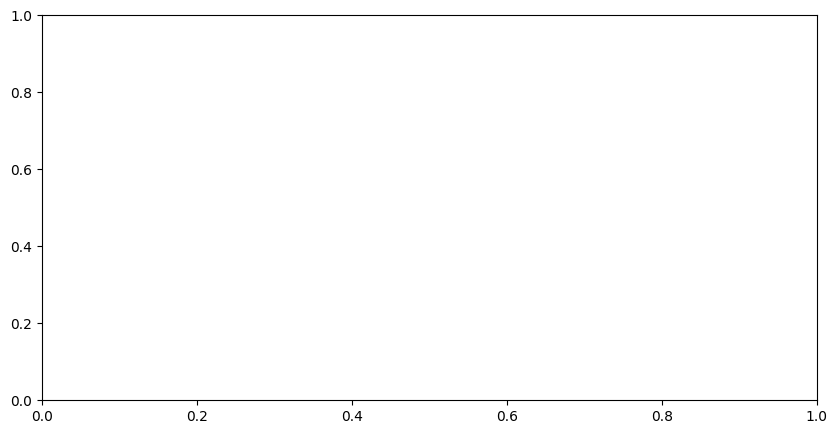

In [ ]:
# TEST
# Mostrar coeficientes
print("\nCoeficientes del modelo Lasso:")
print(lassoCV_test.coef_)
print(lassoCV_test.score(X_test,y_test))

print("\nCoeficientes del modelo Ridge:")
print(ridgeCV_test.coef_)
print(ridgeCV_test.score(X_test,y_test))

print("\nCoeficientes del modelo ElasticNet:")
print(elasticnetCV_test.coef_)
print(elasticnetCV_test.score(X_test,y_test))

# Graficar resultados
plt.figure(figsize=(10, 5))
plt.scatter(X_test, y_test, label='Datos de ejemplo')
plt.plot(X_test, lassoCV_test.predict(X_test), label='Lasso', color='red')
plt.plot(X_test, ridgeCV_test.predict(X_test), label='Ridge', color='blue')
plt.plot(X_test, elasticnetCV_test.predict(X_test), label='ElasticNet', color='yellow')
plt.legend()
plt.title('Comparación de Lasso, Ridge y ElasticNet')
plt.show()

tanto para entrenamiento como para prueba. ¿Por qué para
ambos conjuntos?

## Obtener las métricas adecuadas (entre R2 Score, MSE, RMSE, MAE, MAPE, elegir)

¿Creen que han conseguido un buen fitting?

# Comparación de modelos.

Incluyan en su análisis una comparación de modelos: de todos los modelos
de regresión, ¿cuál es el mejor? Escoger una métrica adecuada para
poder compararlos

# Conclusión del trabajo

Escribir una conclusión del trabajo.